VALORES MISSING, OUTLIERS Y CORRELACIONES

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.impute import KNNImputer
import scipy.stats as ss
import warnings
from scipy.stats import chi2_contingency

FUNCIONES

In [ ]:
import nbimporter
import funciones

In [48]:
def plot_feature(df, col_name, isContinuous, target):
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    count_null = df[col_name].isnull().sum()
    if isContinuous:
        
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name+ ' Numero de nulos: '+str(count_null))
    plt.xticks(rotation = 90)


    if isContinuous:
        sns.boxplot(x=col_name, y=target, data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by '+target)
    else:
        data = df.groupby(col_name)[target].value_counts(normalize=True).to_frame('proportion').reset_index() 
        data.columns = [i, target, 'proportion']
        #sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        ax2.set_ylabel(target+' fraction')
        ax2.set_title(target)
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()

def dame_variables_categoricas(dataset=None):
    if dataset is None:
        print(u'\nFaltan argumentos por pasar a la función')
        return 1
    lista_variables_categoricas = []
    other = []

    for i in dataset.columns:

        if dataset[i].dtype == object:
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 100:
                lista_variables_categoricas.append(i)
            else:
                other.append(i)
        
        if dataset[i].dtype == int:
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 10:
                lista_variables_categoricas.append(i)
            else:
                other.append(i)

    return lista_variables_categoricas, other

def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    # Para obtener la correlación de Spearman, sólo cambiar el metodo por 'spearman'

    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    # Compute the correlation matrix
    corr = dataset.corr(method=metodo) 
    # Set self-correlation to zero to avoid distraction
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size_figure)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) #cbar_kws={"shrink": .5}
    plt.show()
    
    return 0

def get_deviation_of_mean_perc(pd_loan, list_var_continuous, target, multiplier):
    pd_final = pd.DataFrame()
    
    for i in list_var_continuous:
        
        series_mean = pd_loan[i].mean()
        series_std = pd_loan[i].std()
        std_amp = multiplier * series_std
        left = series_mean - std_amp
        right = series_mean + std_amp
        size_s = pd_loan[i].size
        
        perc_goods = pd_loan[i][(pd_loan[i] >= left) & (pd_loan[i] <= right)].size/size_s
        perc_excess = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size/size_s
        
        if perc_excess>0:    
            pd_concat_percent = pd.DataFrame(pd_loan[target][(pd_loan[i] < left) | (pd_loan[i] > right)]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.drop('TARGET',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_outlier_values'] = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size
            pd_concat_percent['porcentaje_sum_null_values'] = perc_excess
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final

def get_percent_null_values_target(pd_loan, list_var_continuous, target):

    pd_final = pd.DataFrame()
    for i in list_var_continuous:
        if pd_loan[i].isnull().sum()>0:
            pd_concat_percent = pd.DataFrame(pd_loan[target][pd_loan[i].isnull()]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.drop('TARGET',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_null_values'] = pd_loan[i].isnull().sum()
            pd_concat_percent['porcentaje_sum_null_values'] = pd_loan[i].isnull().sum()/pd_loan.shape[0]
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final

def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def cramers_v(matrix):
    chi2, p, dof, ex = chi2_contingency(matrix)  # Chi-squared test
    return np.sqrt(chi2 / (matrix.sum().sum() * (min(matrix.shape) - 1)))




Con estas funciones estamos tratando de hacer varias cosas:

1. plot_feature: va a generar gráficos específicos para cada variable donde hará un histograma para analizar la distribución y boxplot para ver cómo se distribuyen los valores en base a la variable TARGET para las variables contínuas. Para las variables categóricas va a crear dos gráficos de barras, para la frecuencia de la variable y otro con las proporciones por categoría de TARGET

2. dame_variables_categoricas: trata de identificar variables categóricas y separarlas en dos: aquellas variables que tienen menos de 100 valores únicos (estas pueden ser muy útiles en nuestro análisis), y aquellas que tienen más de 100 registros únicos

3. get_corr_matrix: para visualizar la matriz de correlación para variables numéricas 

4. get_deviation_of_mean_perc: crea un rango de valores alrededor de la media con la desviación típica y encuentra la proporción de valores dentro y fuera de este intervalo, para así poder ver los valores atípicos y la relación que tienen con la variable TARGET.

5. get_percent_values_target: es para analizar la relación que hay entre valores nulos y la variable TARGET. 

6. cramers_v: para ver la relación entre variables categóricas usando la estadística de Cramer

LECTURA DE DATOS DEL PREPROCESADO INICIAL

In [76]:
path_folder = "../data/"
pd_loan = pd.read_csv(path_folder +"pd_data_preprocessing.csv", low_memory=False).set_index('SK_ID_CURR')

pd_loan.drop(['Unnamed: 0'], axis= 'columns', inplace=True)
pd_loan.head(15)


COMMONAREA_MEDI  COMMONAREA_AVG  COMMONAREA_MODE  \
SK_ID_CURR                                                     
100002               0.0144          0.0143           0.0144   
100003               0.0608          0.0605           0.0497   
100004                  NaN             NaN              NaN   
100006                  NaN             NaN              NaN   
100007                  NaN             NaN              NaN   
100008                  NaN             NaN              NaN   
100009                  NaN             NaN              NaN   
100010                  NaN             NaN              NaN   
100011                  NaN             NaN              NaN   
100012                  NaN             NaN              NaN   
100014                  NaN             NaN              NaN   
100015                  NaN             NaN              NaN   
100016                  NaN             NaN              NaN   
100017               0.0585          0.0582           0.0587   
100018               0.1150          0.1143           0.1153   

            NONLIVINGAPARTMENTS_MODE  NONLIVINGAPARTMENTS_AVG  \
SK_ID_CURR                                                      
100002                        0.0000                   0.0000   
100003                        0.0000                   0.0039   
100004                           NaN                      NaN   
100006                           NaN                      NaN   
100007                           NaN                      NaN   
100008                           NaN                      NaN   
100009                           NaN                      NaN   
100010                           NaN                      NaN   
100011                           NaN                      NaN   
100012                           NaN                      NaN   
100014                           NaN                      NaN   
100015                           NaN                      NaN   
100016                           NaN                      NaN   
100017                        0.0000                   0.0000   
100018                        0.0195                   0.0193   

            NONLIVINGAPARTMENTS_MEDI FONDKAPREMONT_MODE  \
SK_ID_CURR                                                
100002                        0.0000   reg oper account   
100003                        0.0039   reg oper account   
100004                           NaN                NaN   
100006                           NaN                NaN   
100007                           NaN                NaN   
100008                           NaN                NaN   
100009                           NaN                NaN   
100010                           NaN                NaN   
100011                           NaN                NaN   
100012                           NaN                NaN   
100014                           NaN                NaN   
100015                           NaN                NaN   
100016                           NaN   reg oper account   
100017                        0.0000   reg oper account   
100018                        0.0194   reg oper account   

            LIVINGAPARTMENTS_MODE  LIVINGAPARTMENTS_AVG  \
SK_ID_CURR                                                
100002                     0.0220                0.0202   
100003                     0.0790                0.0773   
100004                        NaN                   NaN   
100006                        NaN                   NaN   
100007                        NaN                   NaN   
100008                        NaN                   NaN   
100009                        NaN                   NaN   
100010                        NaN                   NaN   
100011                        NaN                   NaN   
100012                        NaN                   NaN   
100014                        NaN                   NaN   
100015                        NaN             

En el siguiente código, estamos empleando las funciones que hemos creado en el principio del notebook para separar las variables categóricas y contínuas. 

In [ ]:
list_var_cat, other = funciones.dame_variables_categoricas(dataset=pd_loan)
pd_loan[list_var_cat] = pd_loan[list_var_cat].astype("category")
list_var_continuous = list(pd_loan.select_dtypes('float').columns)
pd_loan[list_var_continuous] = pd_loan[list_var_continuous].astype(float)
pd_loan.dtypes

Unnamed: 0                     int64
COMMONAREA_MEDI              float64
COMMONAREA_AVG               float64
COMMONAREA_MODE              float64
NONLIVINGAPARTMENTS_MODE     float64
                              ...   
NAME_HOUSING_TYPE           category
NAME_FAMILY_STATUS          category
NAME_EDUCATION_TYPE         category
NAME_INCOME_TYPE            category
NWEEKDAY_PROCESS_START      category
Length: 123, dtype: object

Algunas variables clasificadas inicialmente como enteras son de carácter booleano, lo que las hace categóricas. 

In [51]:
pd_loan.head()


Unnamed: 0  COMMONAREA_MEDI  COMMONAREA_AVG  COMMONAREA_MODE  \
SK_ID_CURR                                                                 
100002               0           0.0144          0.0143           0.0144   
100003               1           0.0608          0.0605           0.0497   
100004               2              NaN             NaN              NaN   
100006               3              NaN             NaN              NaN   
100007               4              NaN             NaN              NaN   

            NONLIVINGAPARTMENTS_MODE  NONLIVINGAPARTMENTS_AVG  \
SK_ID_CURR                                                      
100002                           0.0                   0.0000   
100003                           0.0                   0.0039   
100004                           NaN                      NaN   
100006                           NaN                      NaN   
100007                           NaN                      NaN   

            NONLIVINGAPARTMENTS_MEDI FONDKAPREMONT_MODE  \
SK_ID_CURR                                                
100002                        0.0000   reg oper account   
100003                        0.0039   reg oper account   
100004                           NaN                NaN   
100006                           NaN                NaN   
100007                           NaN                NaN   

            LIVINGAPARTMENTS_MODE  LIVINGAPARTMENTS_AVG  ...  DAYS_ID_PUBLISH  \
SK_ID_CURR                                               ...                    
100002                      0.022                0.0202  ...            -2120   
100003                      0.079                0.0773  ...             -291   
100004                        NaN                   NaN  ...            -2531   
100006                        NaN                   NaN  ...            -2437   
100007                        NaN                   NaN  ...            -3458   

            DAYS_REGISTRATION  DAYS_EMPLOYED  DAYS_BIRTH  \
SK_ID_CURR                                                 
100002                -3648.0           -637       -9461   
100003                -1186.0          -1188      -16765   
100004                -4260.0           -225      -19046   
100006                -9833.0          -3039      -19005   
100007                -4311.0          -3038      -19932   

            REGION_POPULATION_RELATIVE  NAME_HOUSING_TYPE  \
SK_ID_CURR                                                  
100002                        0.018801  House / apartment   
100003                        0.003541  House / apartment   
100004                        0.010032  House / apartment   
100006                        0.008019  House / apartment   
100007                        0.028663  House / apartment   

              NAME_FAMILY_STATUS            NAME_EDUCATION_TYPE  \
SK_ID_CURR                                                        
100002      Single / not married  Secondary / secondary special   
100003                   Married               Higher education   
100004      Single / not married  Secondary / secondary special   
100006            Civil marriage  Secondary / secondary special   
100007      Single / not married  Secondary / secondary special   

            NAME_INCOME_TYPE  NWEEKDAY_PROCESS_START  
SK_ID_CURR                                            
100002               Working                       3  
100003         State servant                       1  
100004               Working                       1  
100006               Working                       3  
100007               Working                       4  

[5 rows x 123 columns]

Utilizamos el ID de cliente como el índice del Dataframe. A continuación, identificamos las variables continuas y categóricas dentro del conjunto de datos

SEPARACIÓN EN TRAIN Y TEST ESTRATIFICADO

En este código estamos tratando de realizar un gráfico que nos muestre la proporción de la variable TARGET mediante un conteo de valores. 

In [52]:
pd_plot_target = pd_loan['TARGET'].value_counts(normalize=False).reset_index()

pd_plot_target.columns = ['TARGET', 'count']

fig = px.bar(pd_plot_target, x='TARGET', y='count')
fig.update_xaxes(tickvals=[0, 1])
fig.show()

Se observa que el muestreo está desbalanceado, ya que la mayoría de los clientes no tienen dificultades para pagar el préstamo. (0 = pagado y 1 = no pagado)
El 20% de los datos se asignan al conjunto de prueba y el 80% al conjunto de entrenamiento para entrenar el modelo.

In [53]:
from sklearn.model_selection import train_test_split
X_pd_loan, X_pd_loan_test, y_pd_loan, y_pd_loan_test = train_test_split(pd_loan.drop('TARGET',axis=1), 
                                                                     pd_loan['TARGET'], 
                                                                     stratify=pd_loan['TARGET'], 
                                                                     test_size=0.2)
pd_loan_train = pd.concat([X_pd_loan, y_pd_loan],axis=1)
pd_loan_test = pd.concat([X_pd_loan_test, y_pd_loan_test],axis=1)

In [54]:
print('== Train\n', pd_loan_train['TARGET'].value_counts(normalize=True))
print('== Test\n', pd_loan_test['TARGET'].value_counts(normalize=True))

== Train
 TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64
== Test
 TARGET
0    0.919272
1    0.080728
Name: proportion, dtype: float64


Aquí podemos ver que en la separación en train y test ha salido bien ya que con el argumento 'stratify' hemos puesto que queremos que en el train y en el test haya la misma proporción de la variable TARGET, lo que permite que el modelo tenga ejemplos de todas las clases en ambos conjuntos y así evita que el modelo tenga un sesgo hacia una clase en particular.

VISUALIZACIÓN DESCRIPTIVA DE LOS DATOS

Aquí vamos a realizar la suma de la cantidad de valores nulos que hay por filas y por columnas. 

pd_null_columnas contiene el número de valores nulos por columna y el % de valores nulos respecto al total de filas.
pd_null_filas contiene el número de valores nulos por filas y el porcentaje de valores nulos respecto al total de columnas, y la relación con la variable TARGET

In [55]:
pd_series_null_columns = pd_loan_train.isnull().sum().sort_values(ascending=False)
pd_series_null_rows = pd_loan_train.isnull().sum(axis=1).sort_values(ascending=False)
print(pd_series_null_columns.shape, pd_series_null_rows.shape)

pd_null_columnas = pd.DataFrame(pd_series_null_columns, columns=['nulos_columnas'])     
pd_null_filas = pd.DataFrame(pd_series_null_rows, columns=['nulos_filas'])  
pd_null_filas['TARGET'] = pd_loan['TARGET'].copy()
pd_null_columnas['porcentaje_columnas'] = pd_null_columnas['nulos_columnas']/pd_loan_train.shape[0]
pd_null_filas['porcentaje_filas']= pd_null_filas['nulos_filas']/pd_loan_train.shape[1]

(123,) (246008,)


In [56]:
pd_null_columnas.head()

nulos_columnas  porcentaje_columnas
COMMONAREA_MEDI                   171941             0.698924
COMMONAREA_AVG                    171941             0.698924
COMMONAREA_MODE                   171941             0.698924
NONLIVINGAPARTMENTS_AVG           170849             0.694486
NONLIVINGAPARTMENTS_MODE          170849             0.694486

In [57]:
pd_null_filas.head()

nulos_filas TARGET  porcentaje_filas
SK_ID_CURR                                      
235599               61      0          0.495935
329262               61      0          0.495935
315294               61      0          0.495935
274127               61      0          0.495935
412312               61      0          0.495935

Hemos hecho un conteo y porcentaje de valores nulos por filas y columnas para identificar qué columnas y filas tienen más valores nulos por si hubiese que tomar la decisión de imputarlas o eliminarlas

TRATAMIENTO DE VARIABLES CATEGÓRICAS

In [58]:
list_var_cat

['FONDKAPREMONT_MODE',
 'WALLSMATERIAL_MODE',
 'HOUSETYPE_MODE',
 'EMERGENCYSTATE_MODE',
 'OCCUPATION_TYPE',
 'NAME_TYPE_SUITE',
 'FLAG_DOCUMENT_8',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_21',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_OWN_REALTY',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_12',
 'FLAG_PHONE',
 'LIVE_CITY_NOT_WORK_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'TARGET',
 'REG_CITY_NOT_LIVE_CITY',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'REG_REGION_NOT_LIVE_REGION',
 'WEEKDAY_APPR_PROCESS_START',
 'REGION_RATING_CLIENT_W_CITY',
 'REGION_RATING_CLIENT',
 'FLAG_EMAIL',
 'FLAG_CONT_MOBILE',
 'ORGANIZATION_TYPE',
 'FLAG_WORK_PHONE',
 'FLAG_EMP_PHON

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



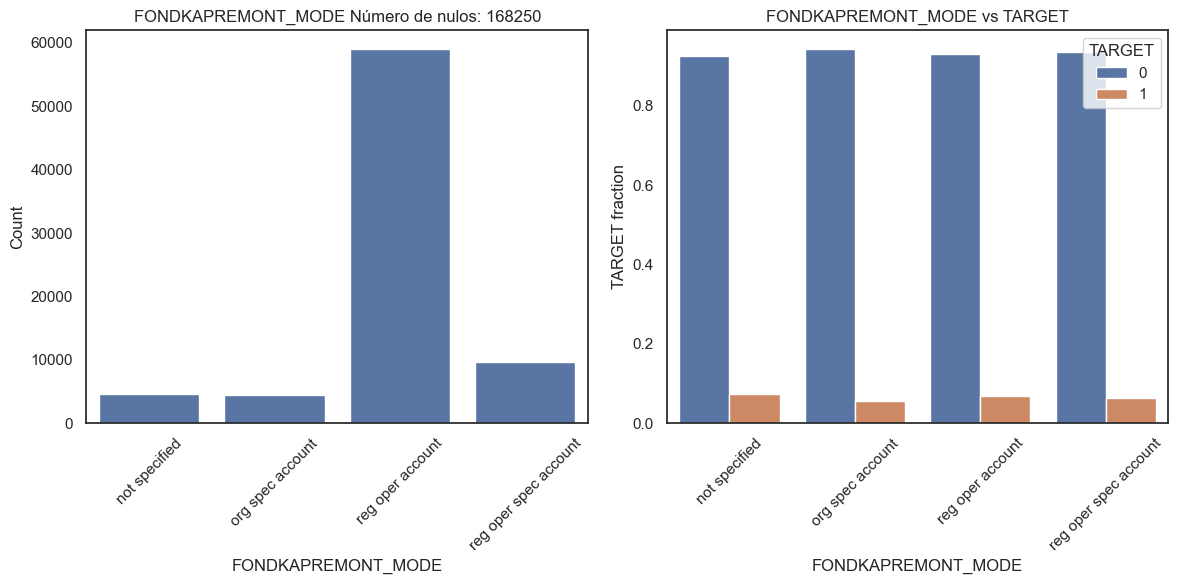

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



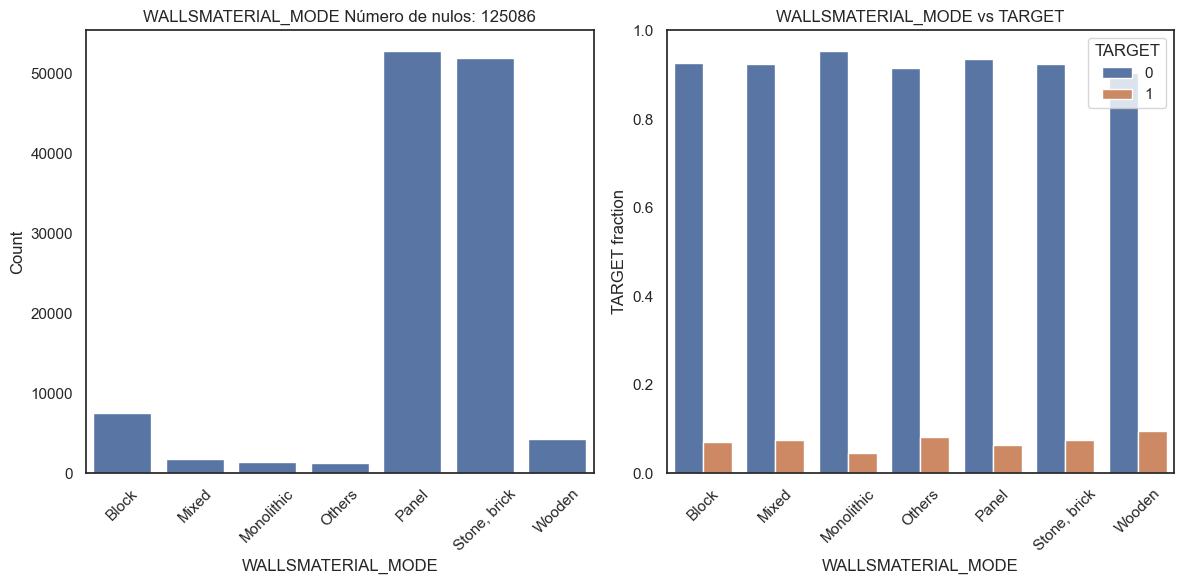

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



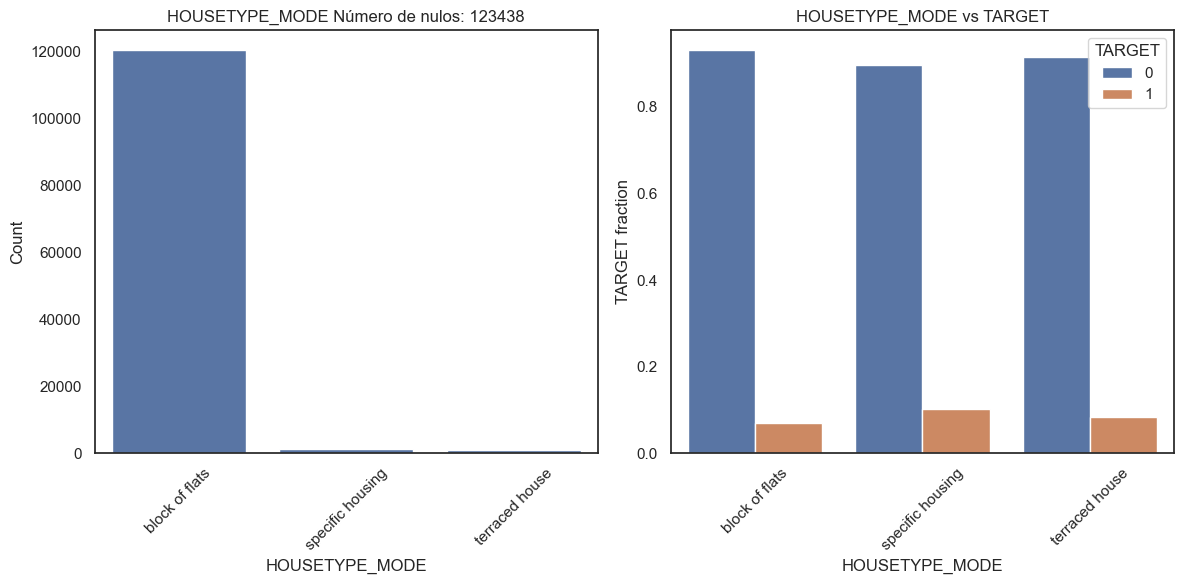

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



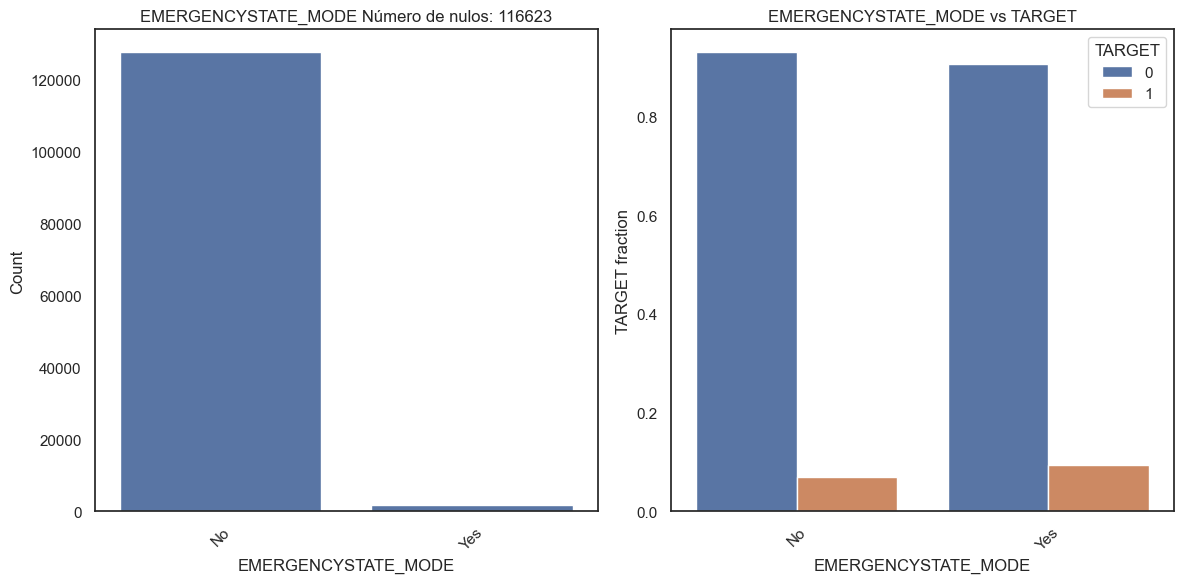

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



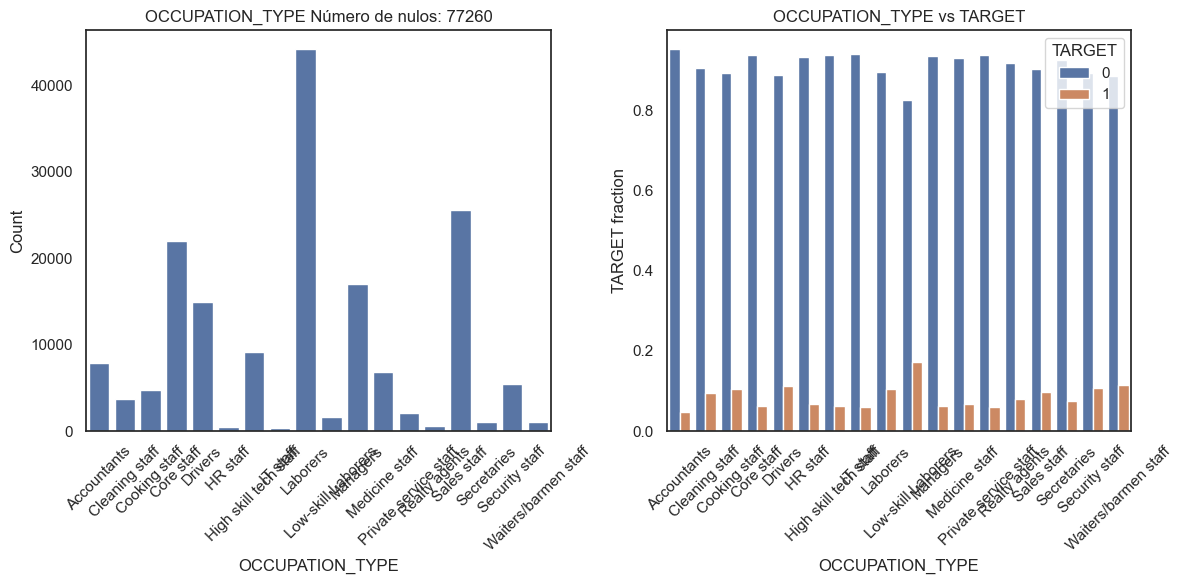

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



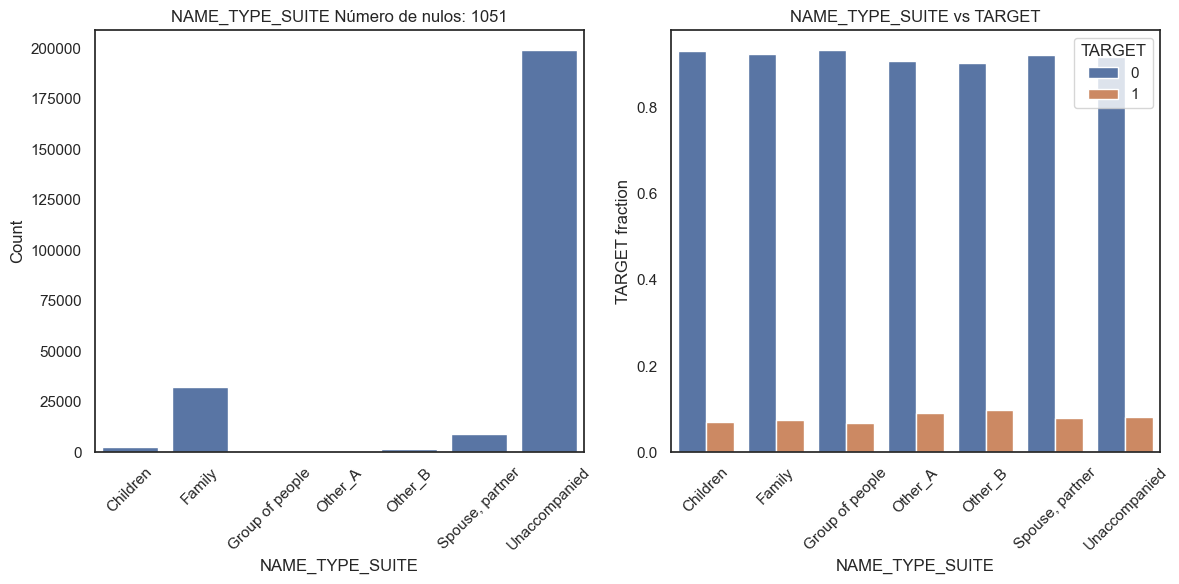

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



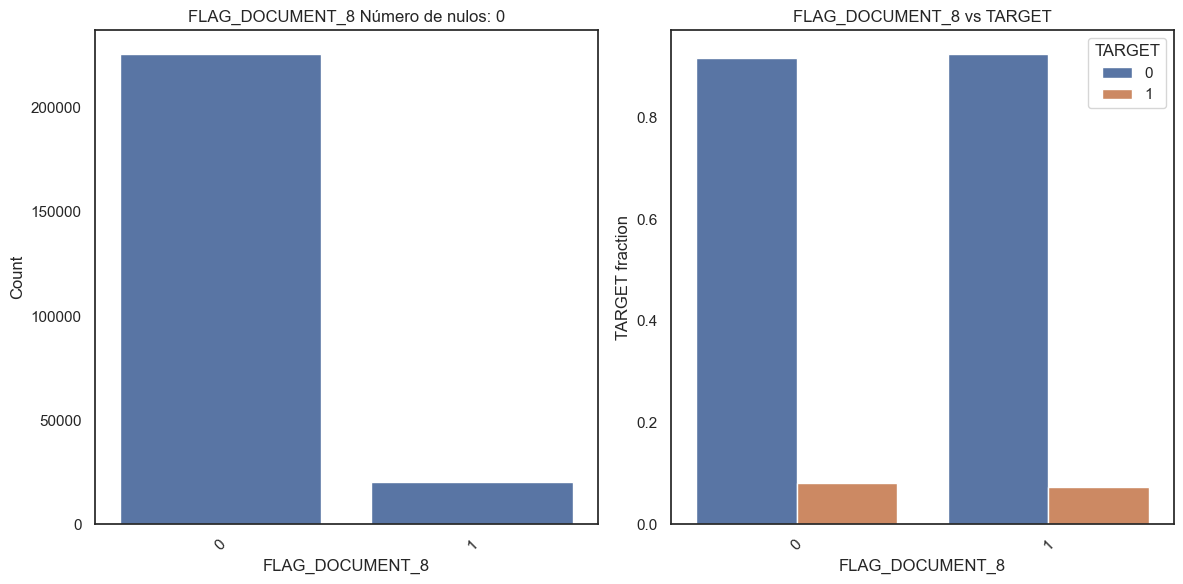

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



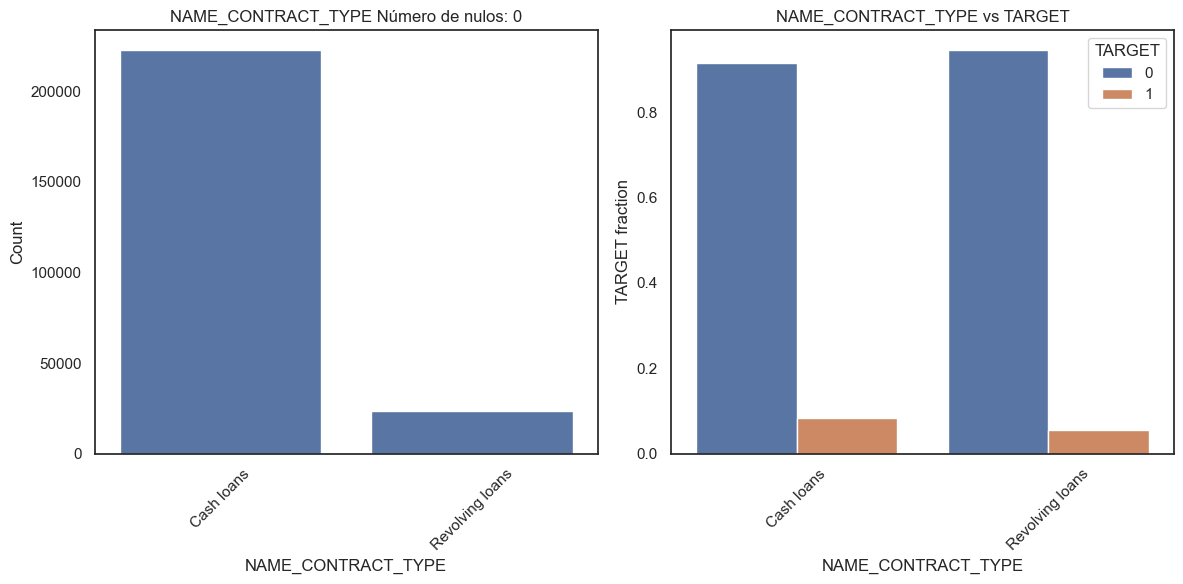

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



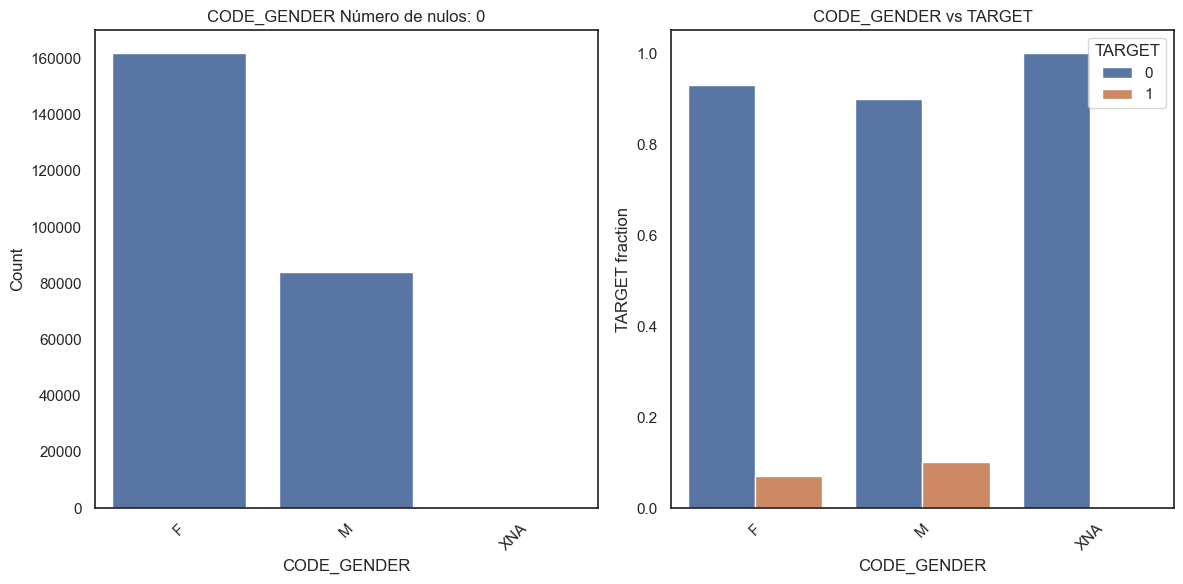

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



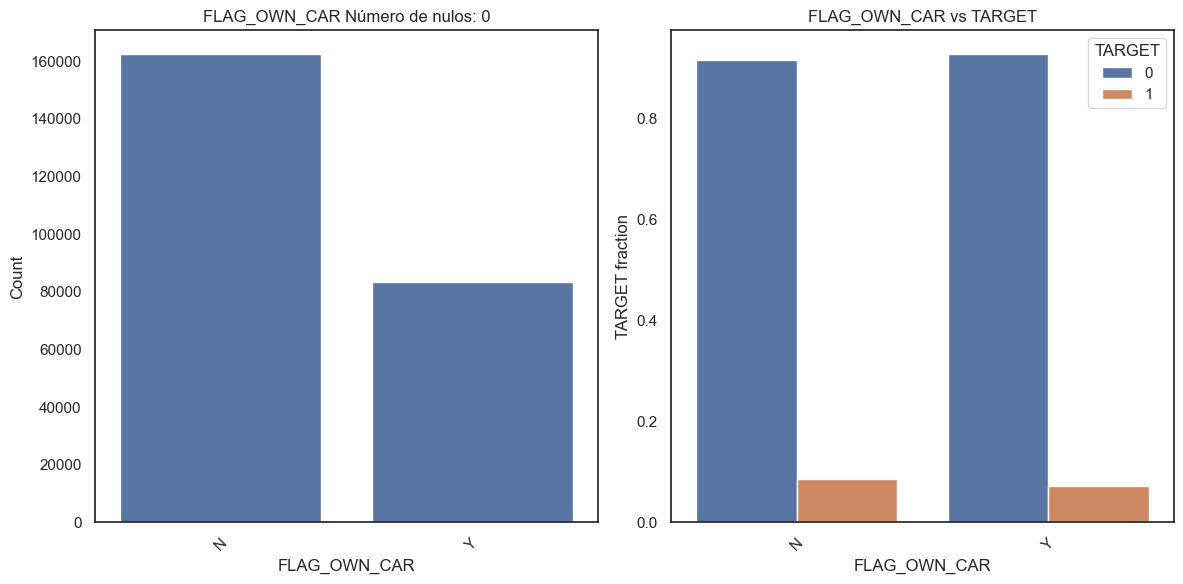

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



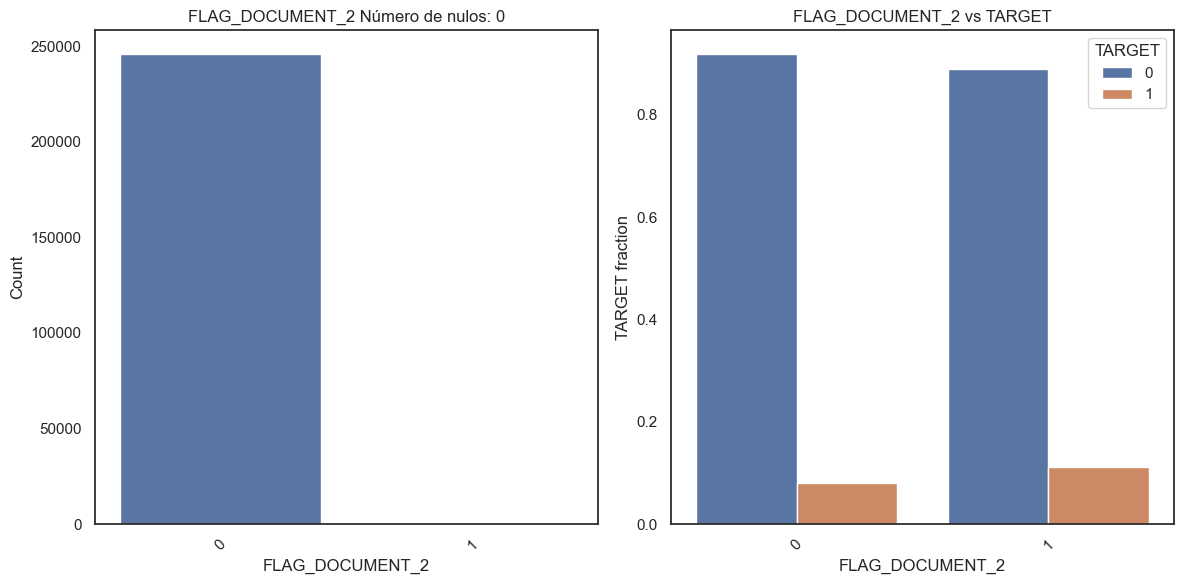

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



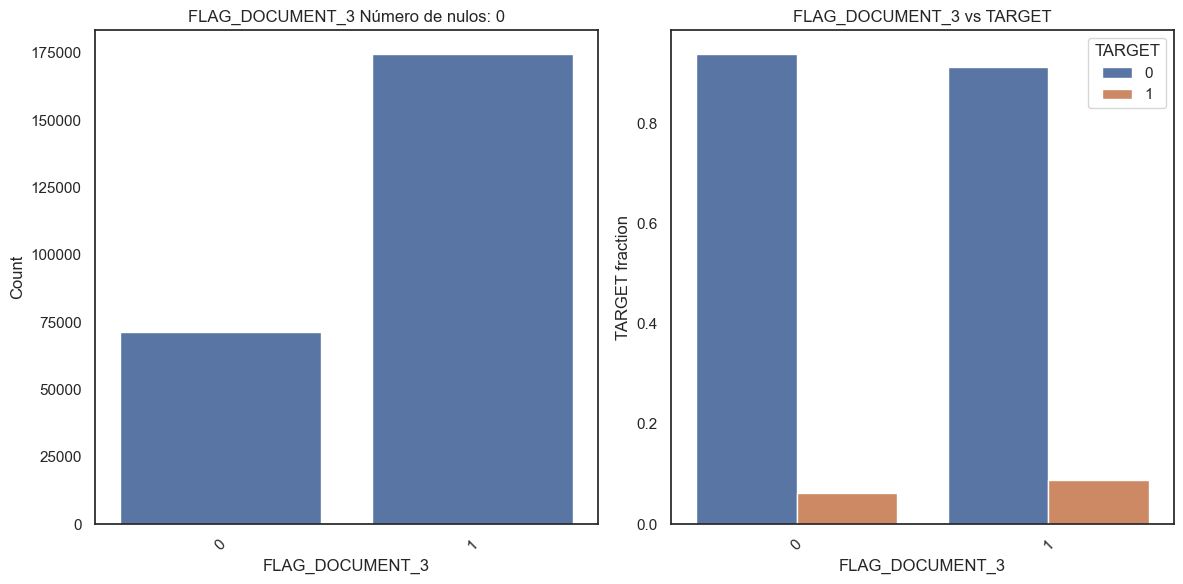

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



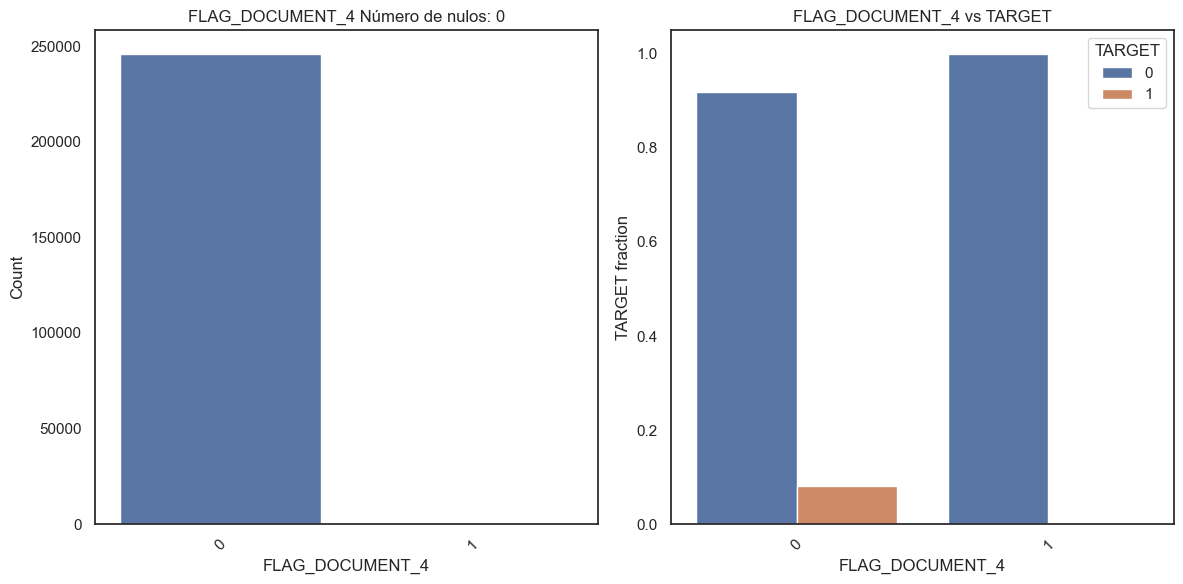

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



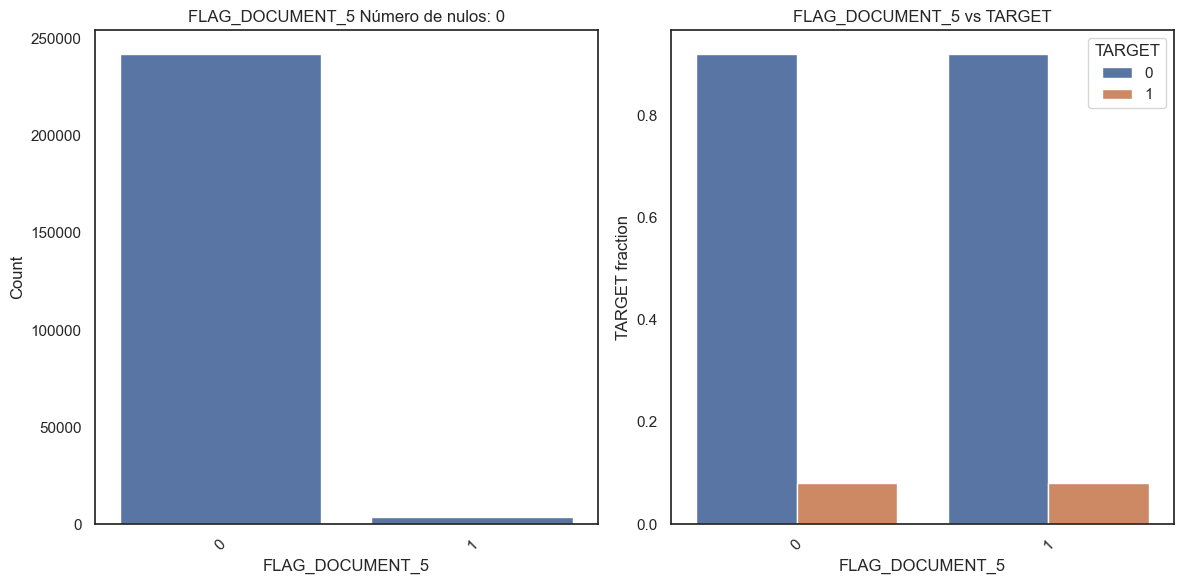

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



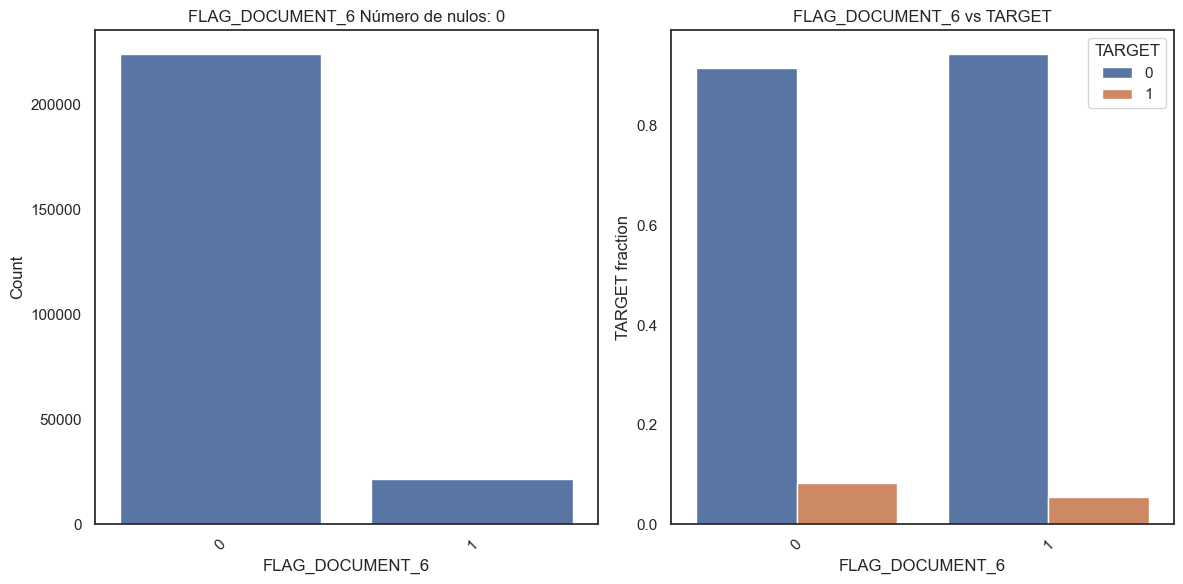

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



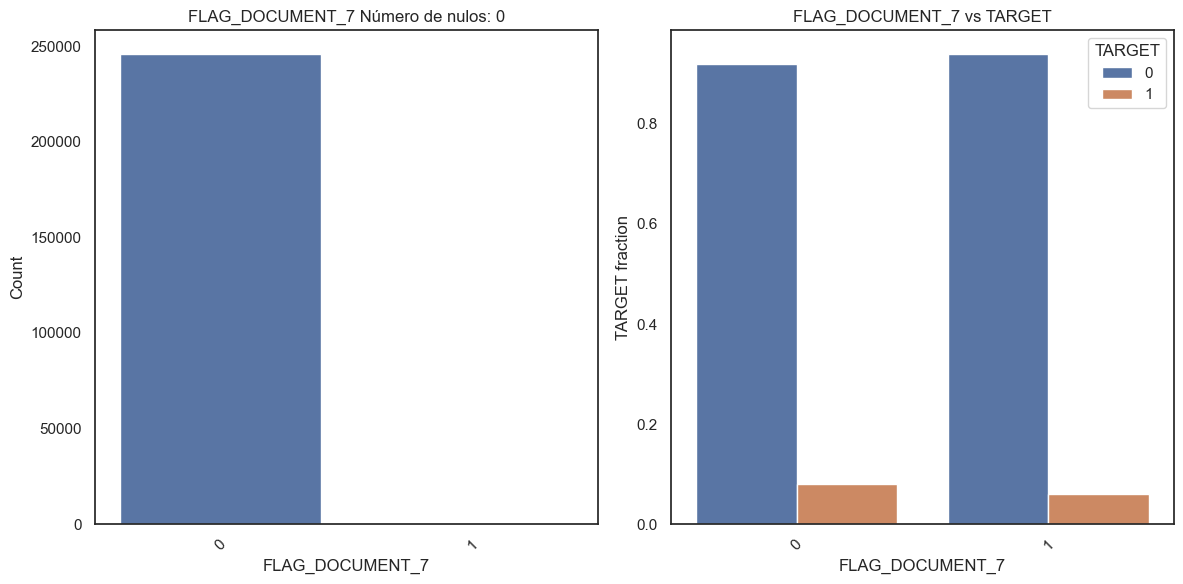

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



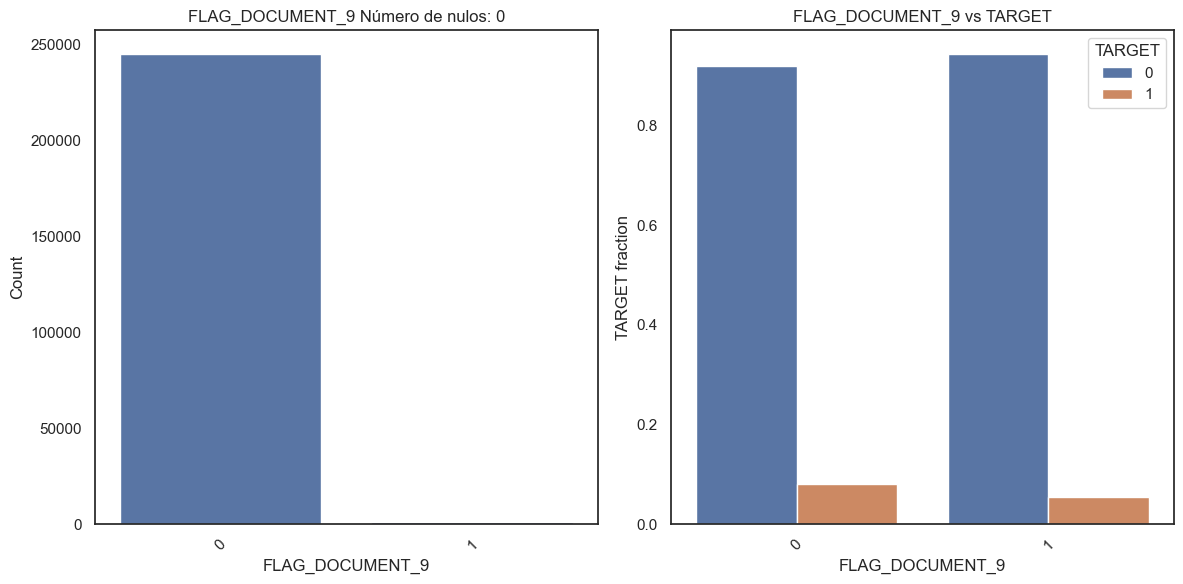

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



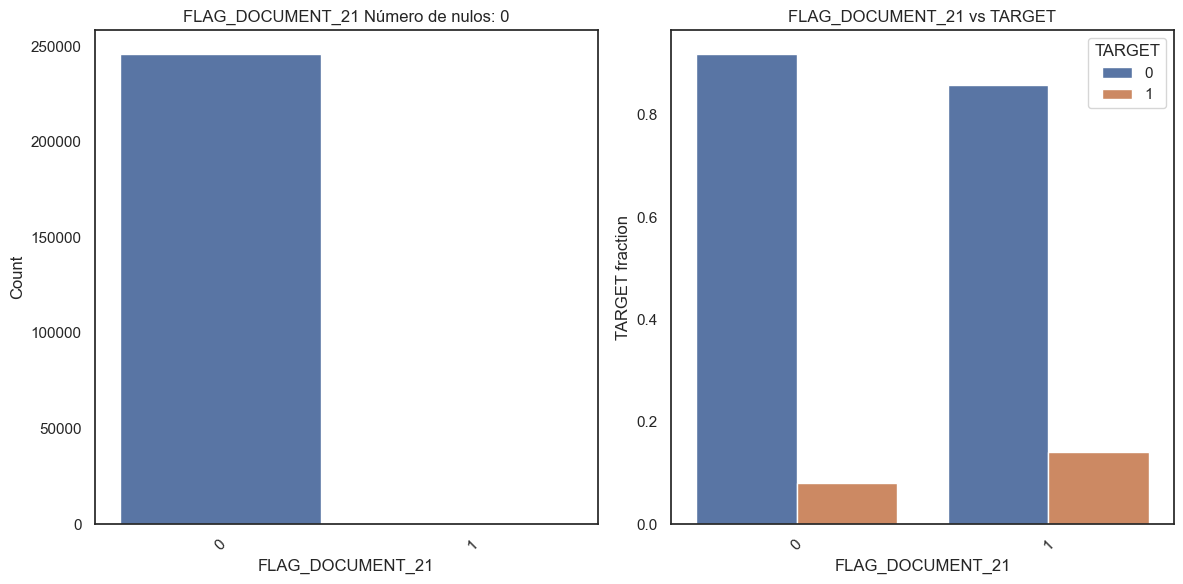

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



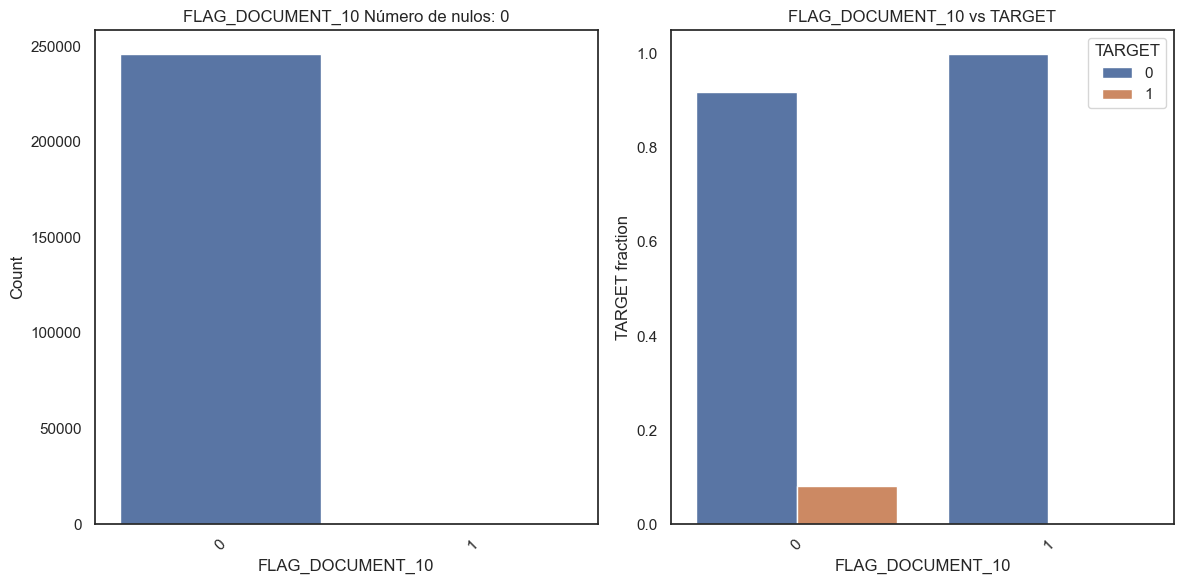

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



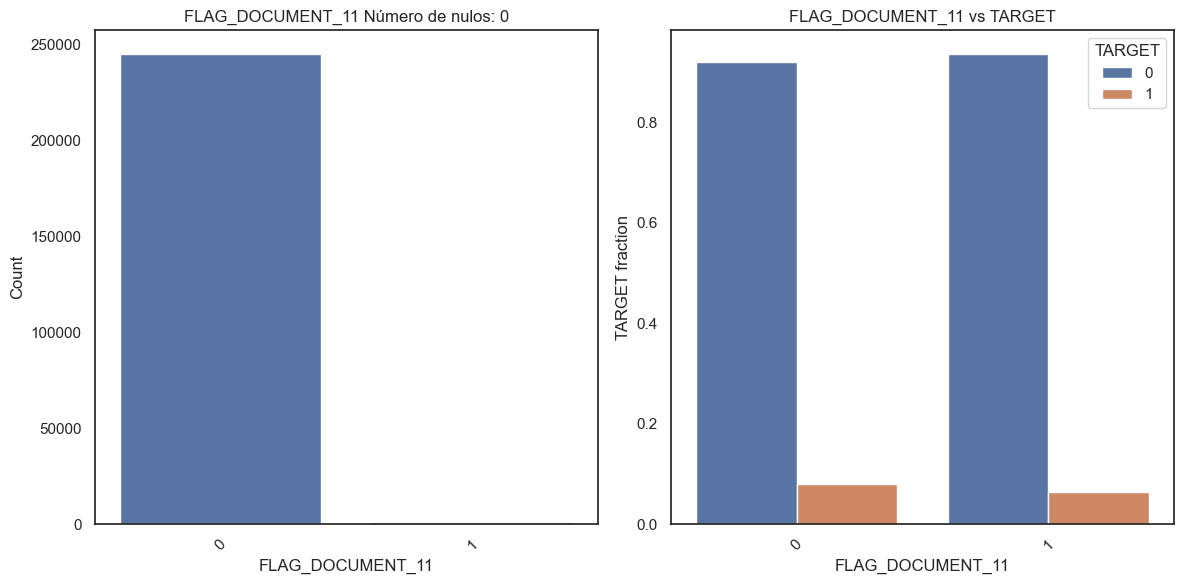

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



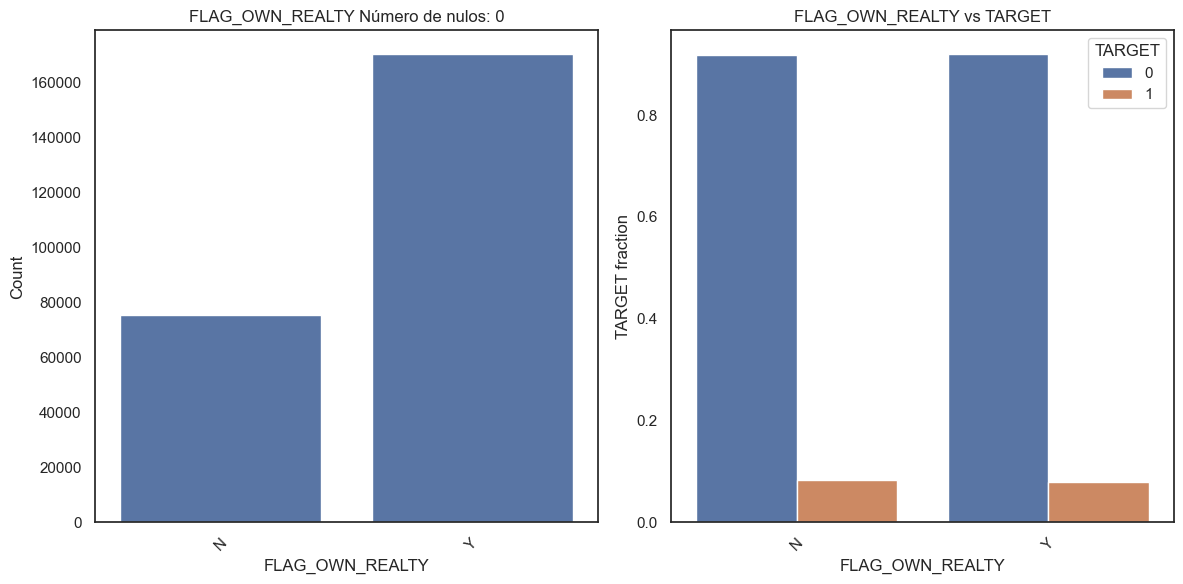

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



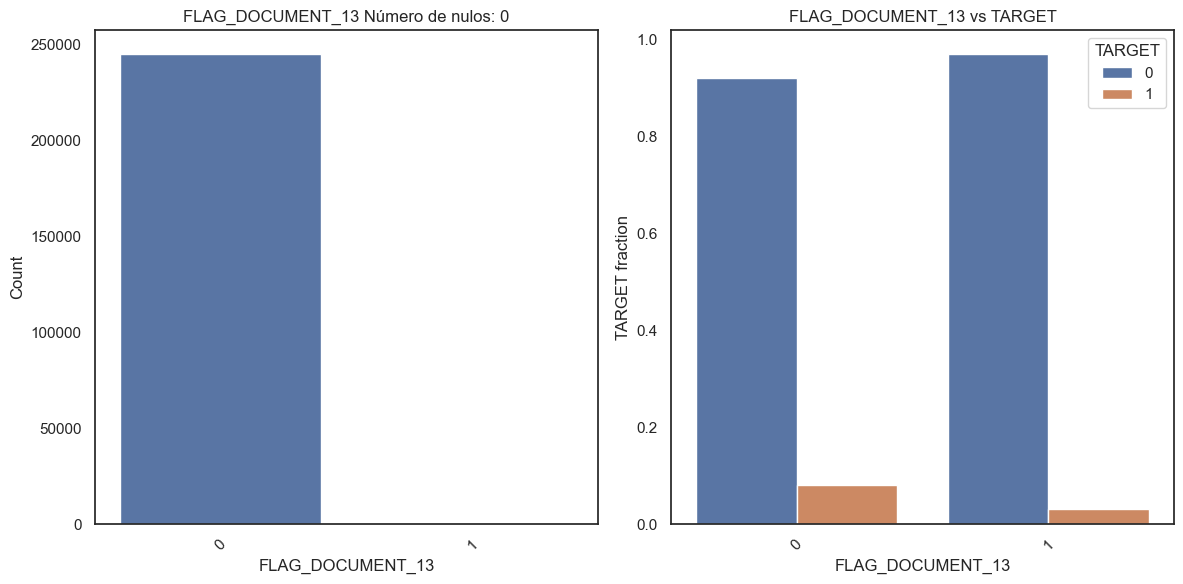

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



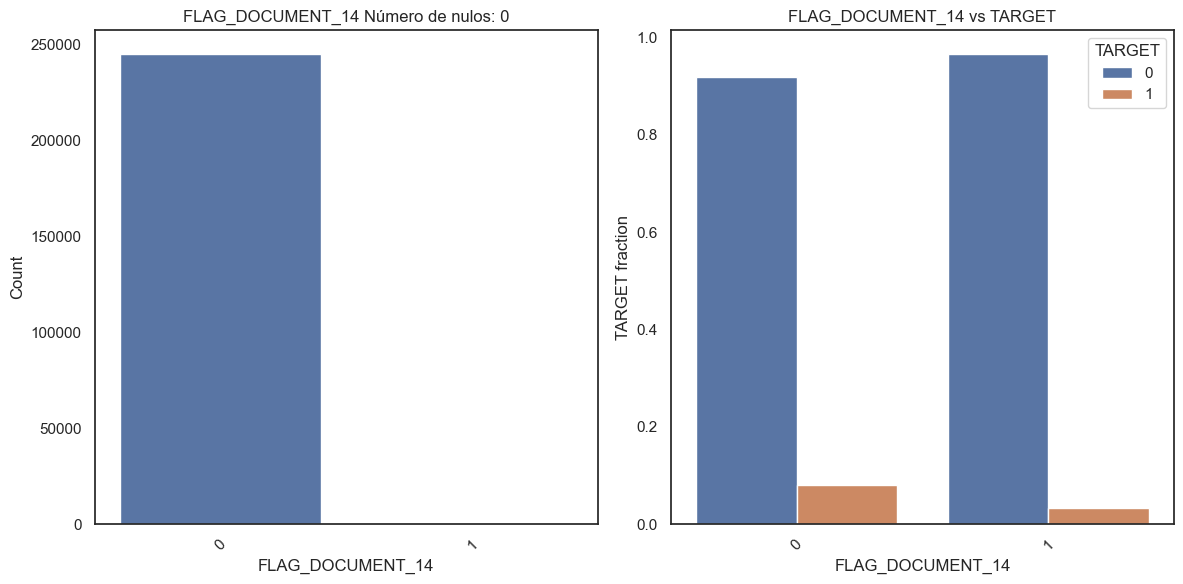

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



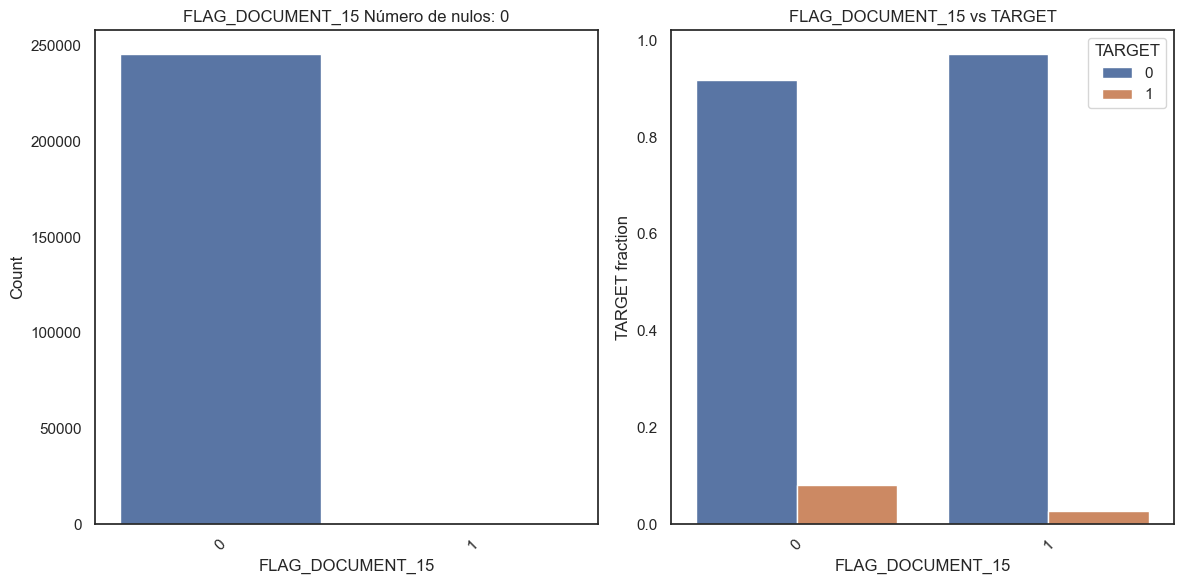

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



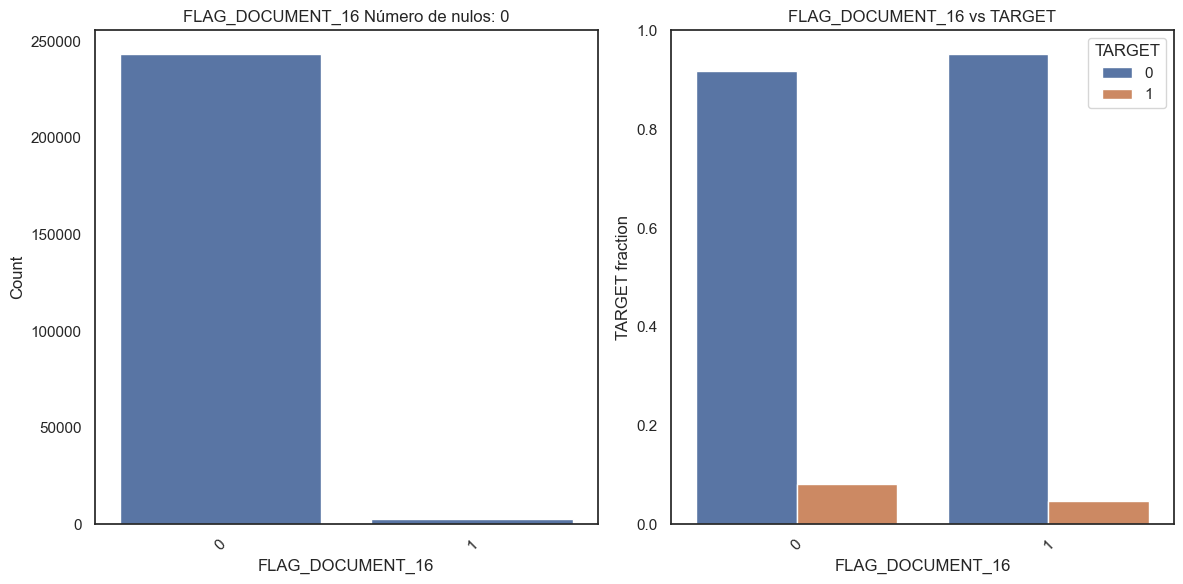

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



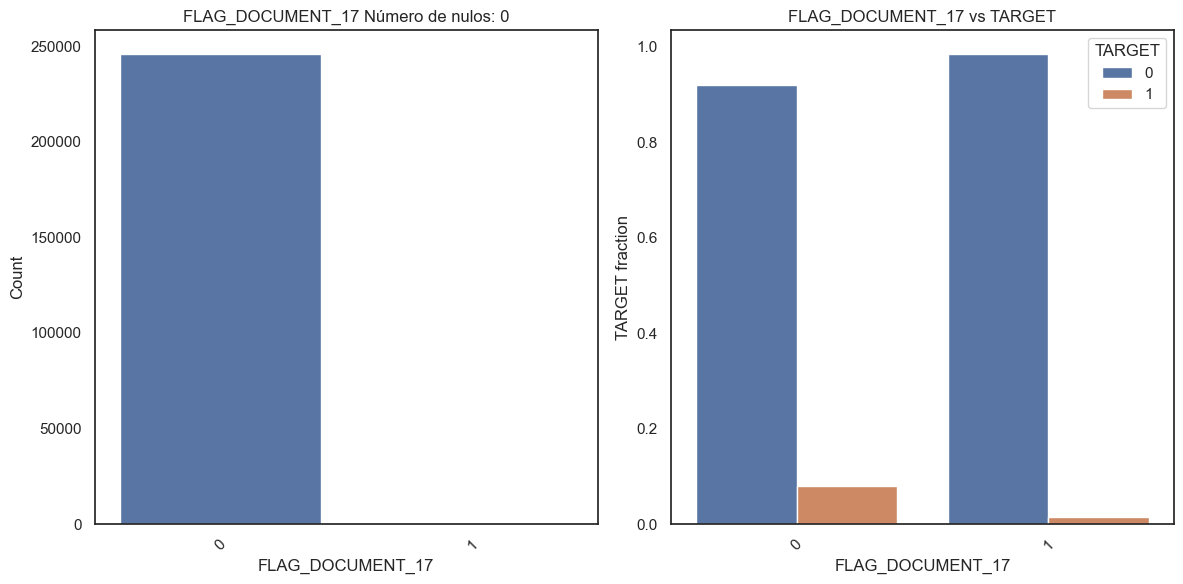

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



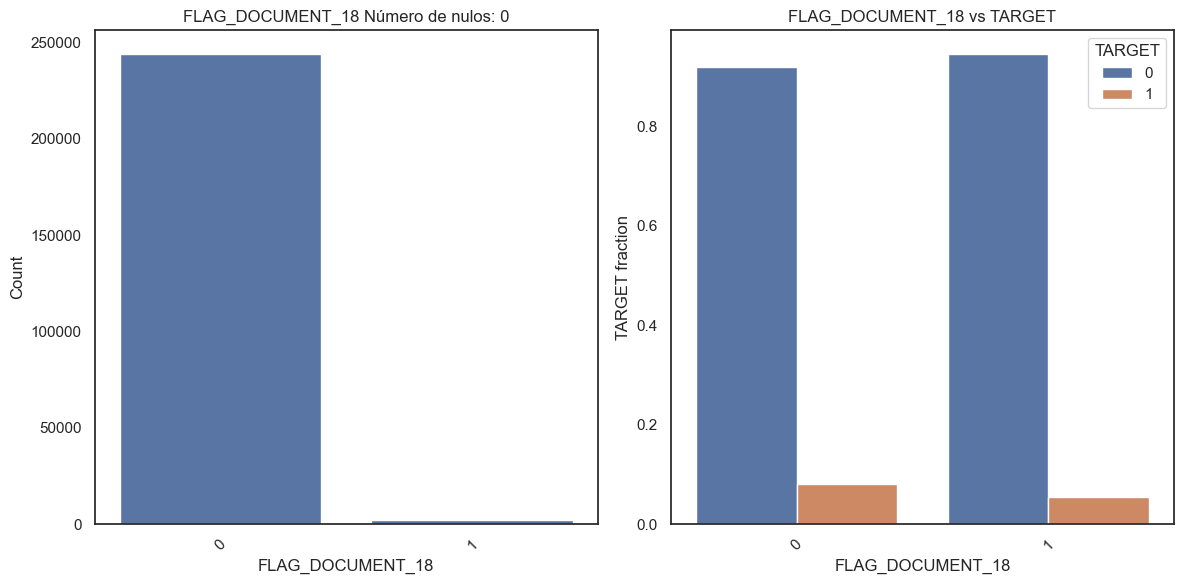

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



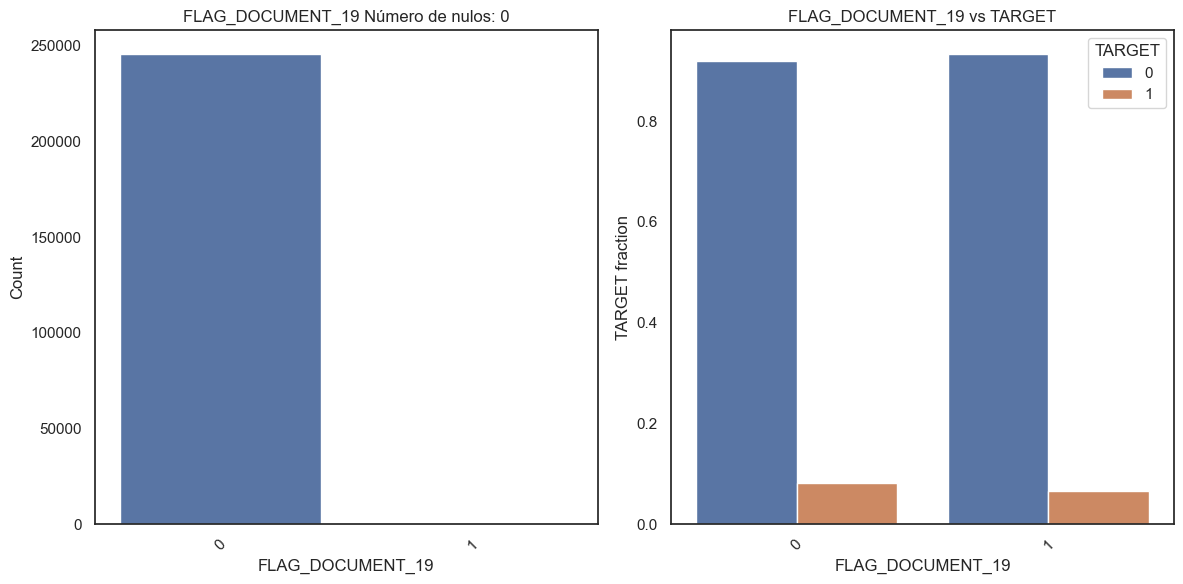

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



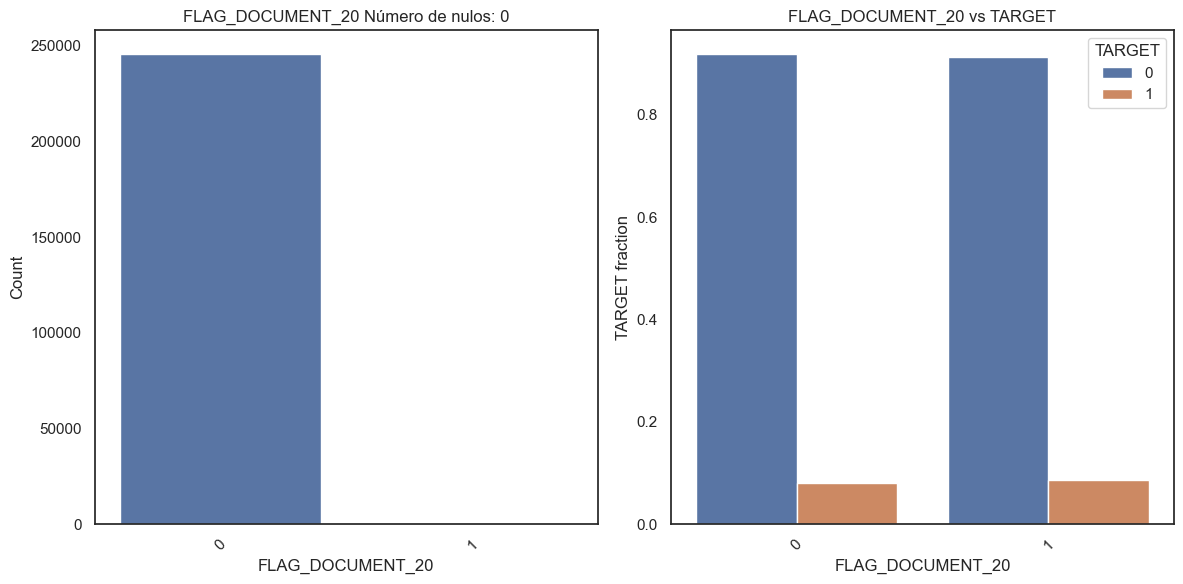

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



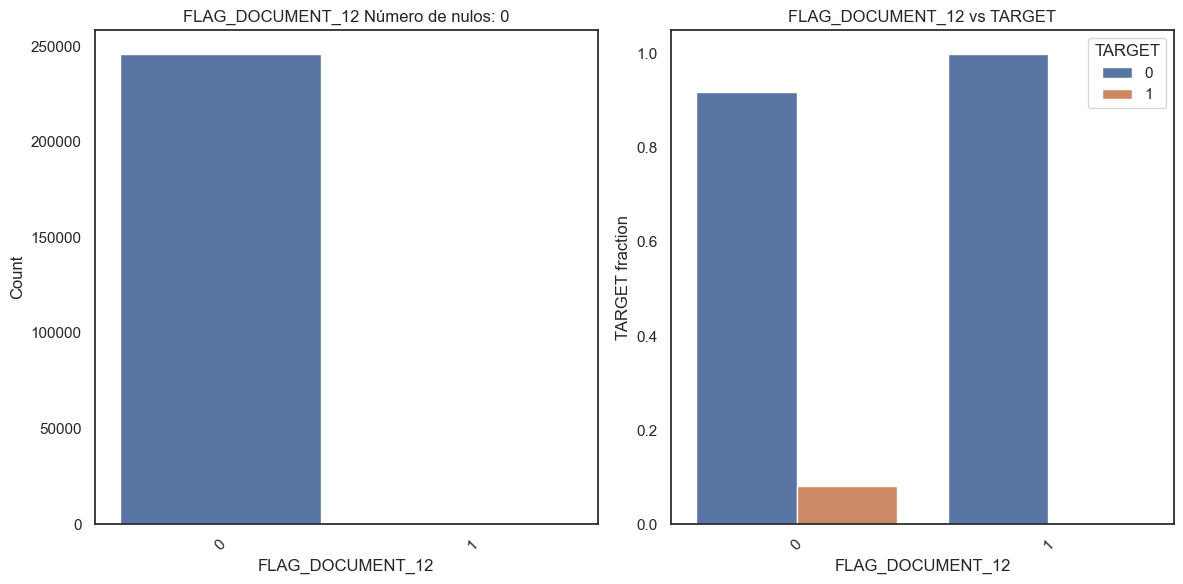

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



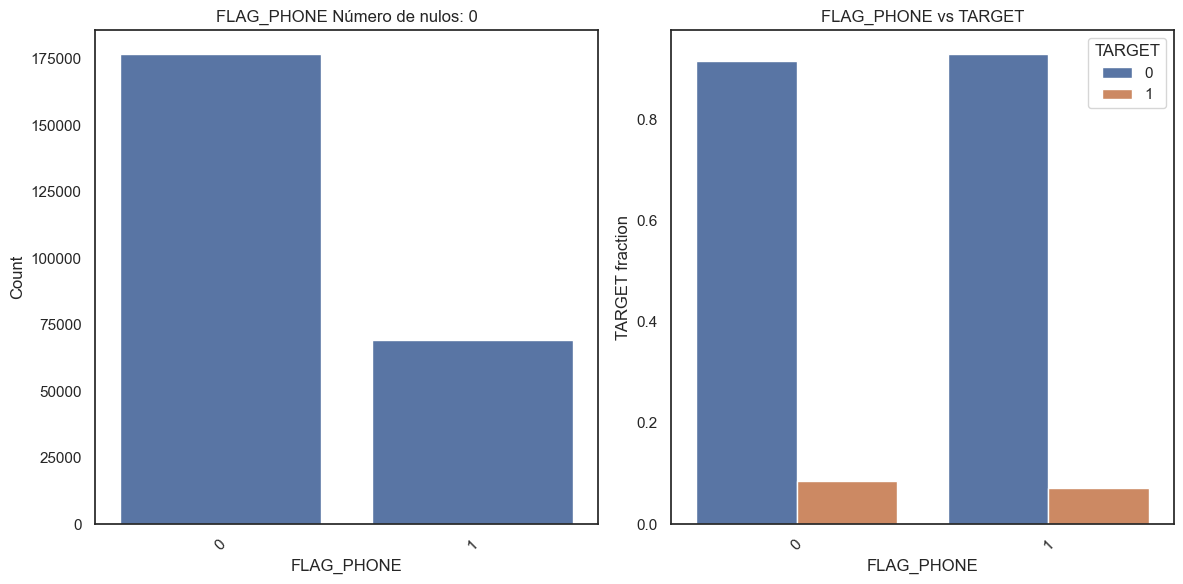

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



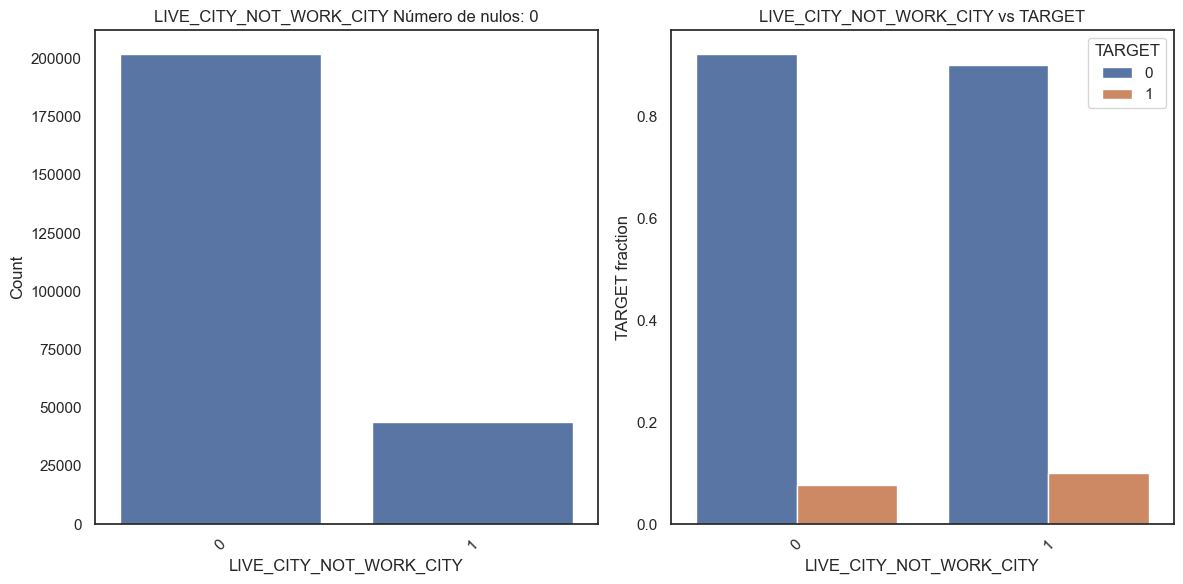

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



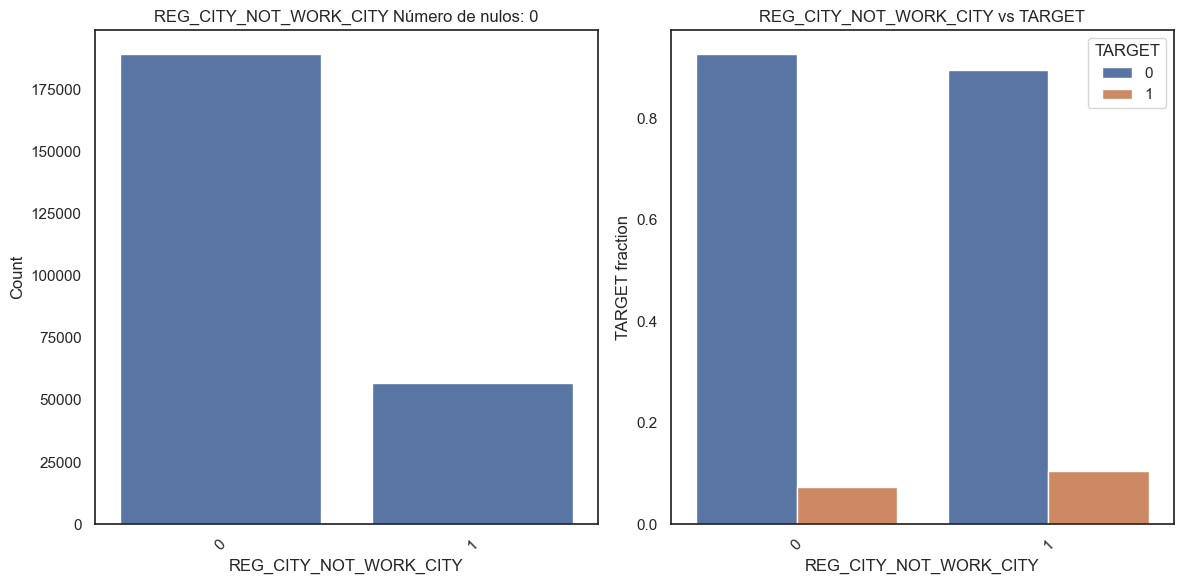

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



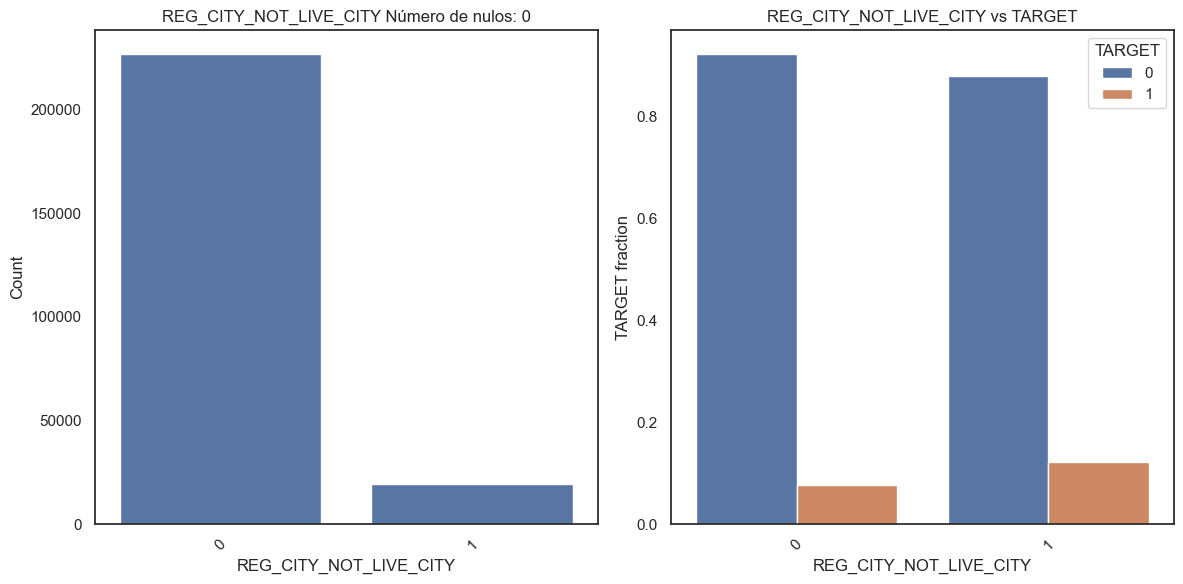

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



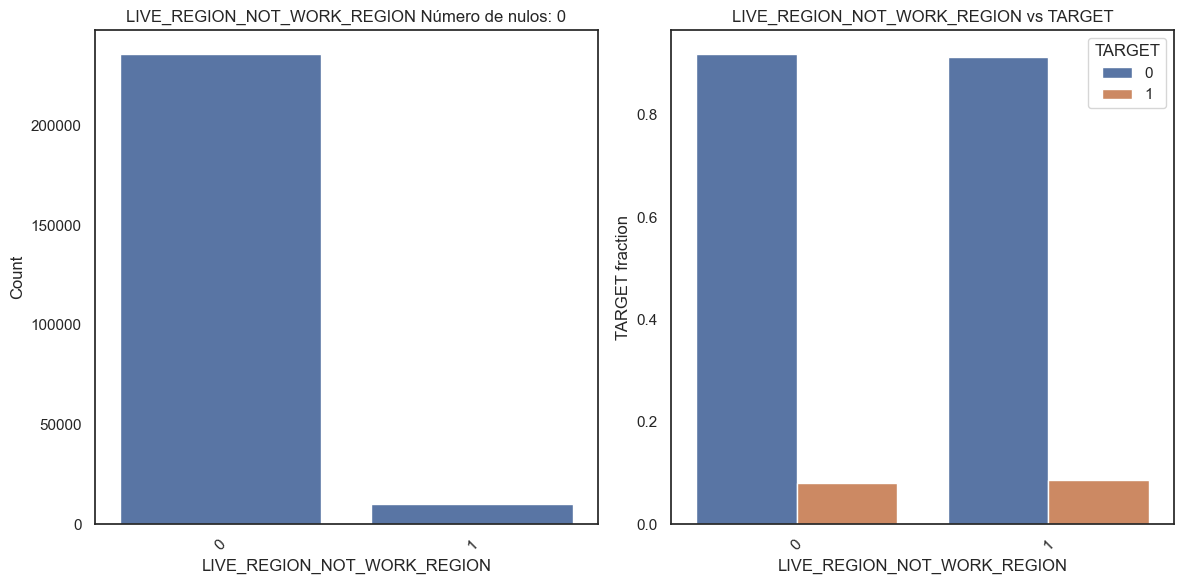

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



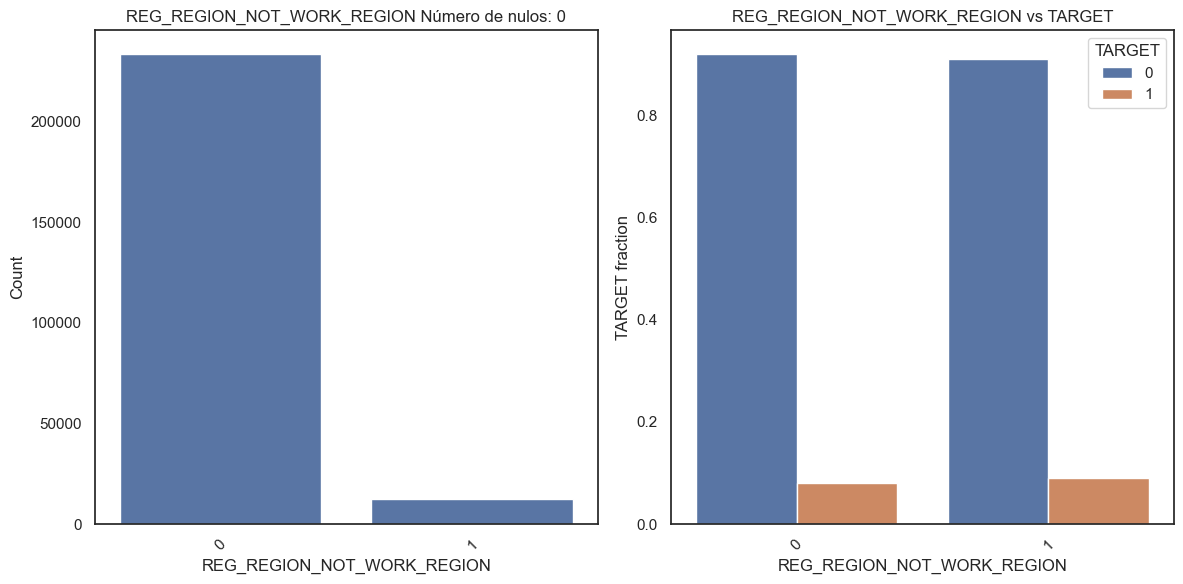

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



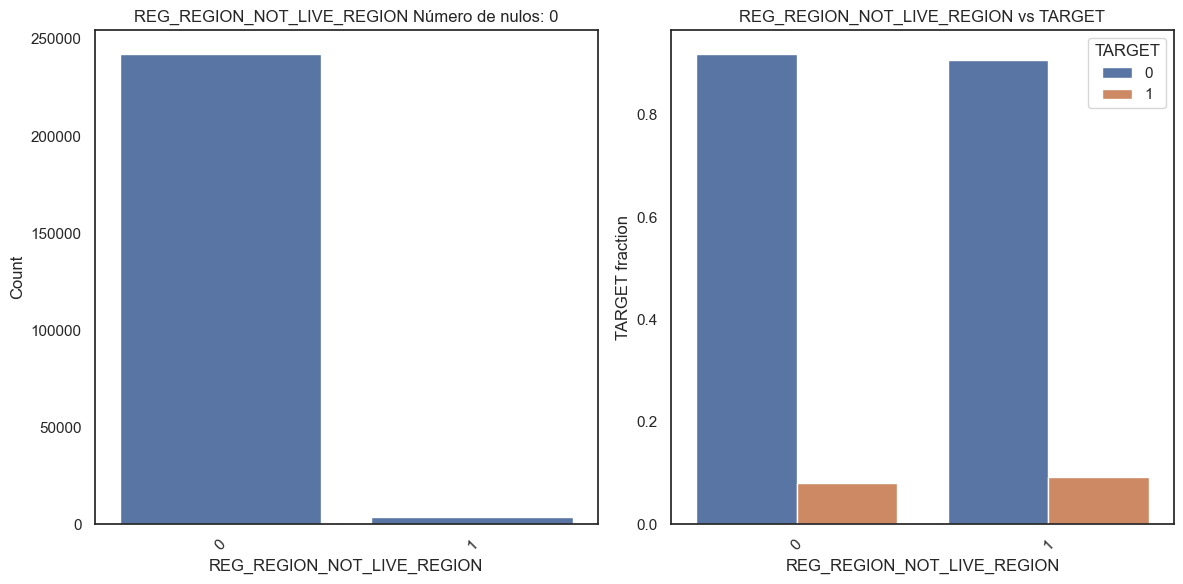

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



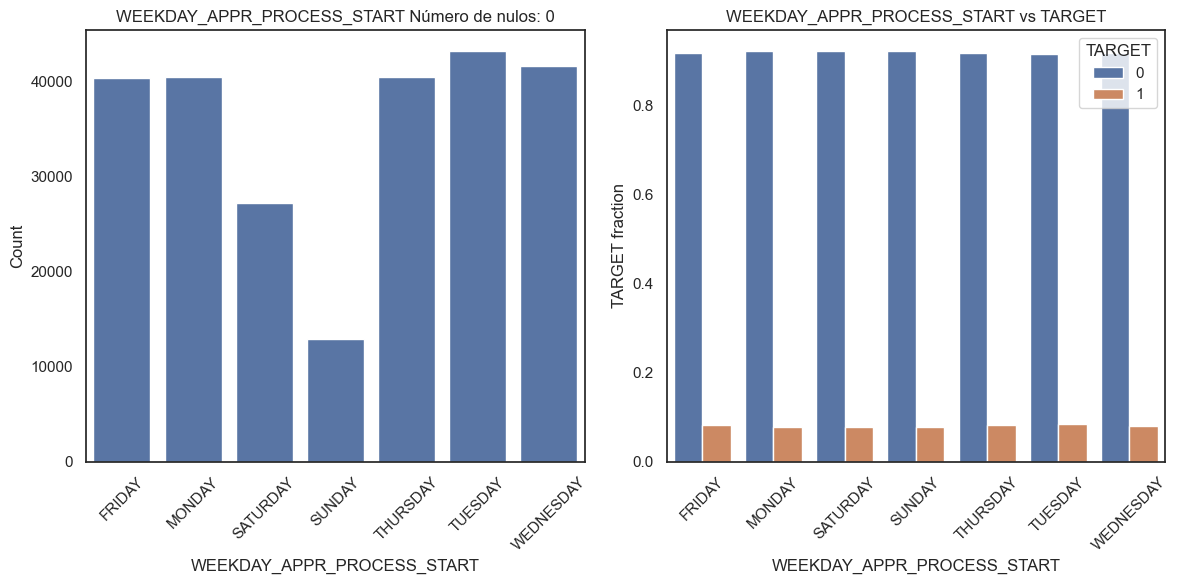

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



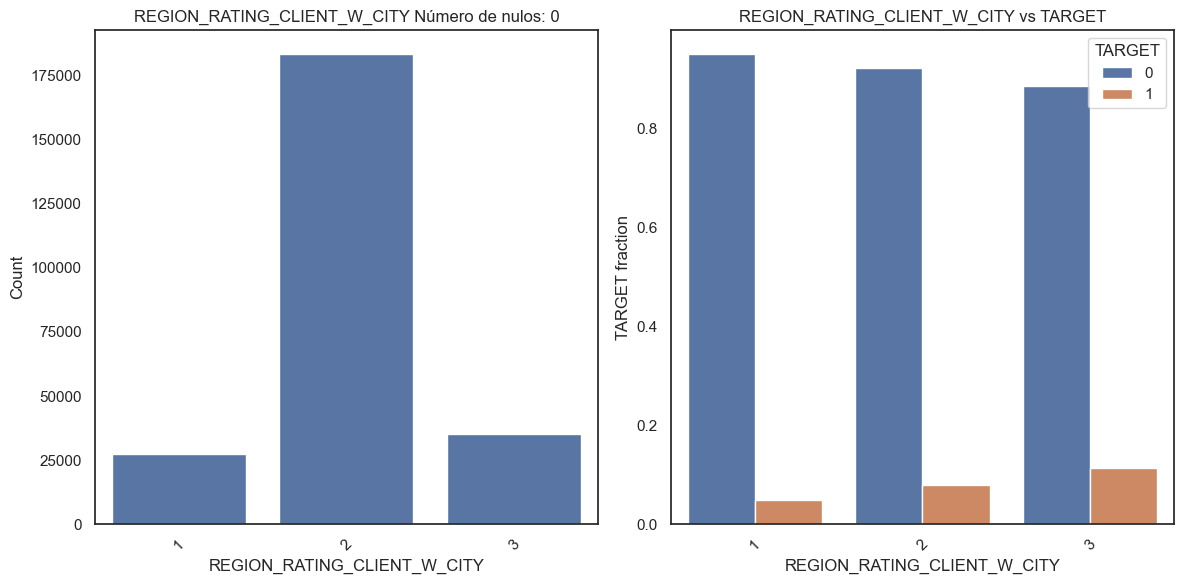

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



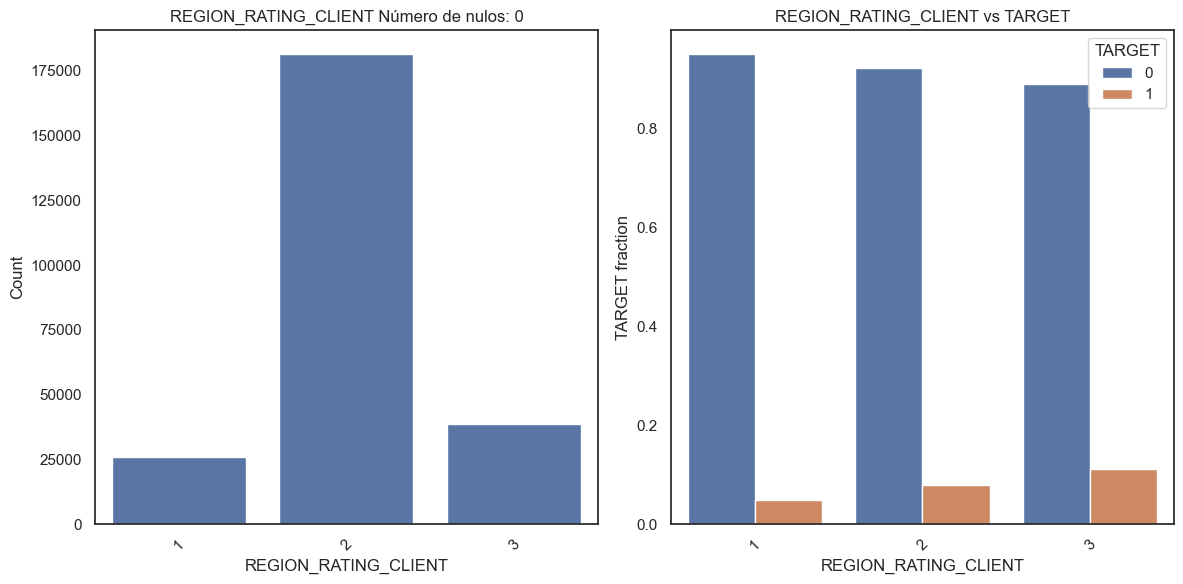

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



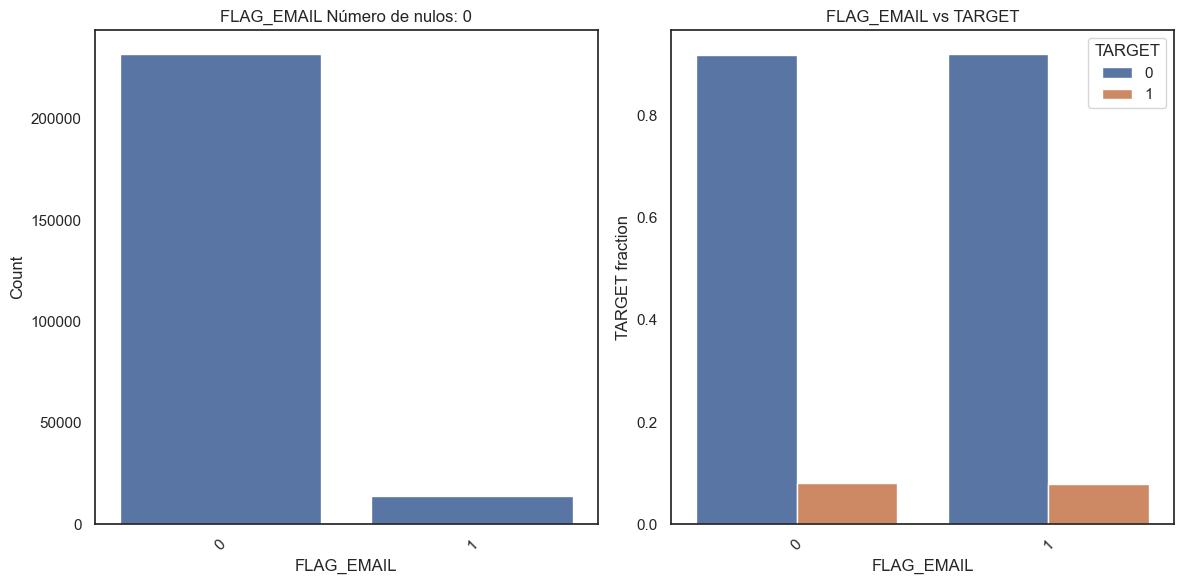

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



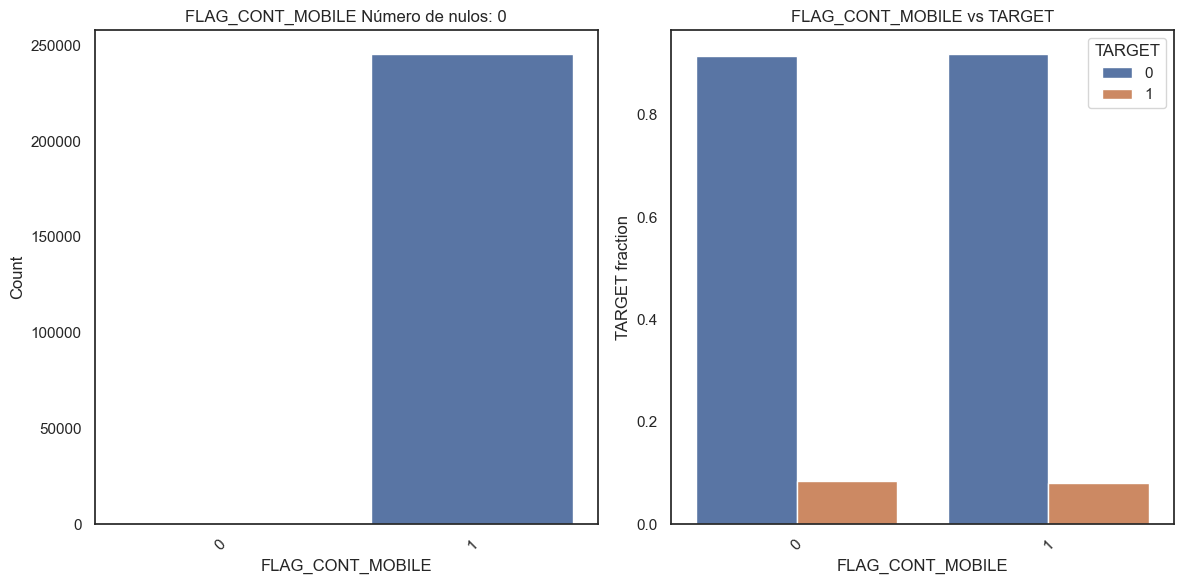

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



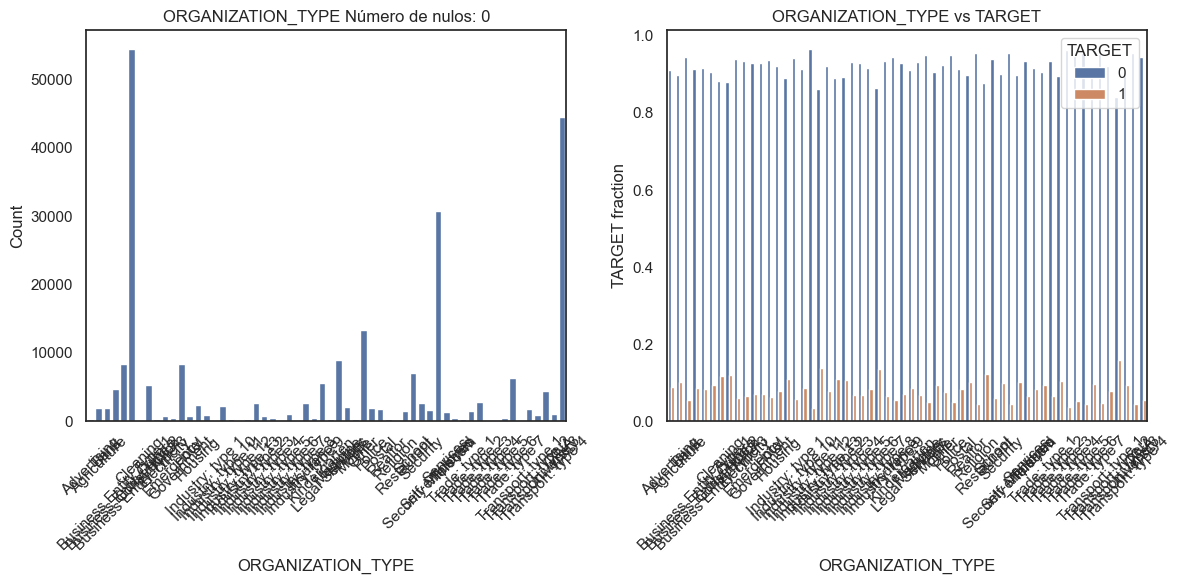

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



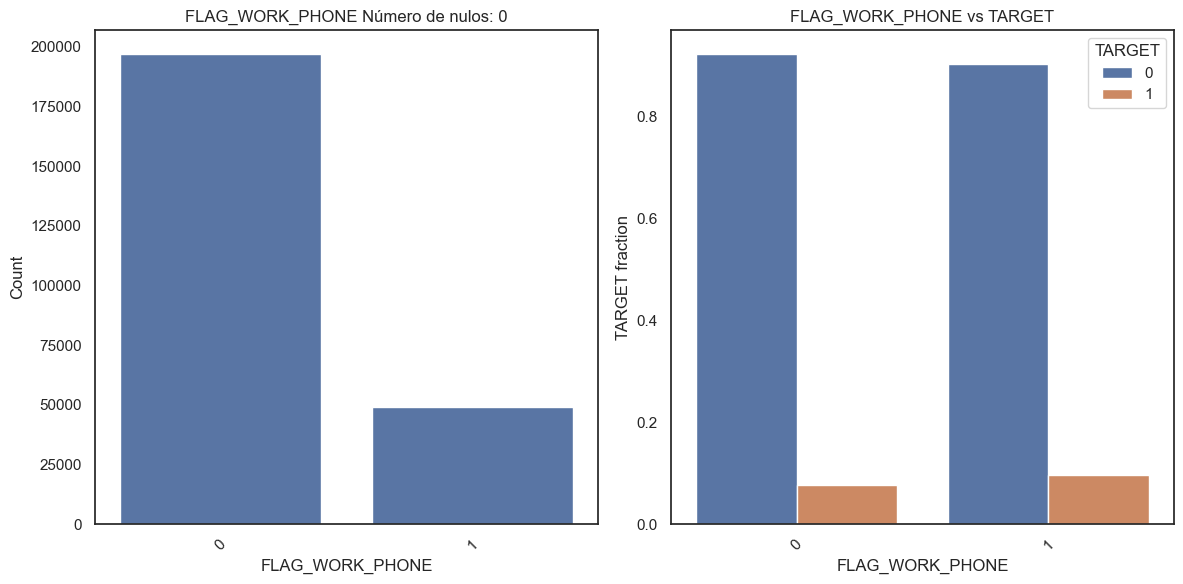

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



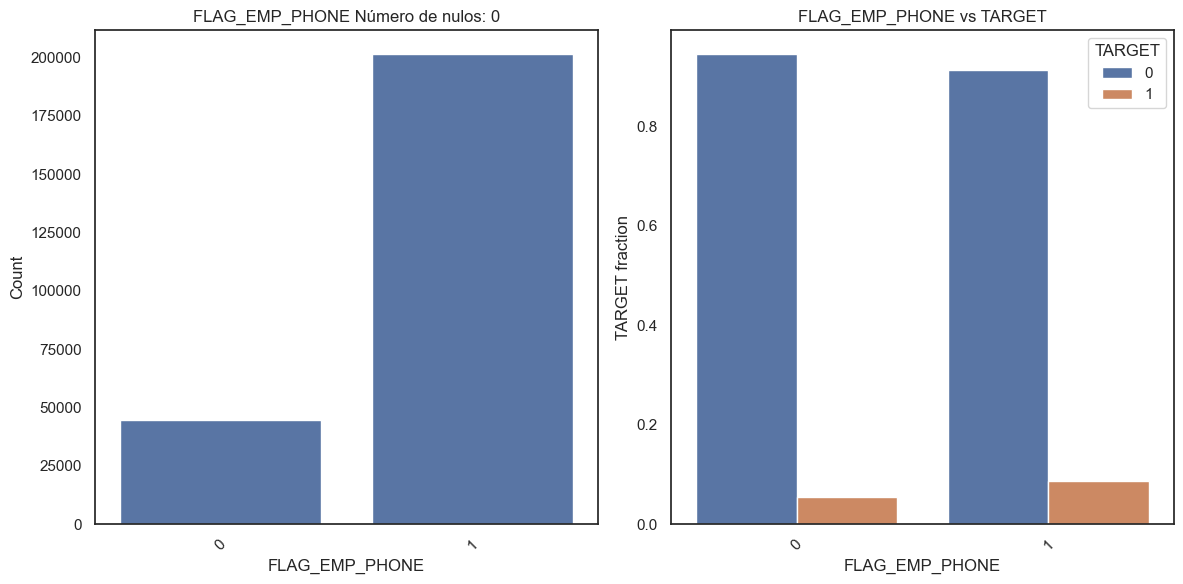

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



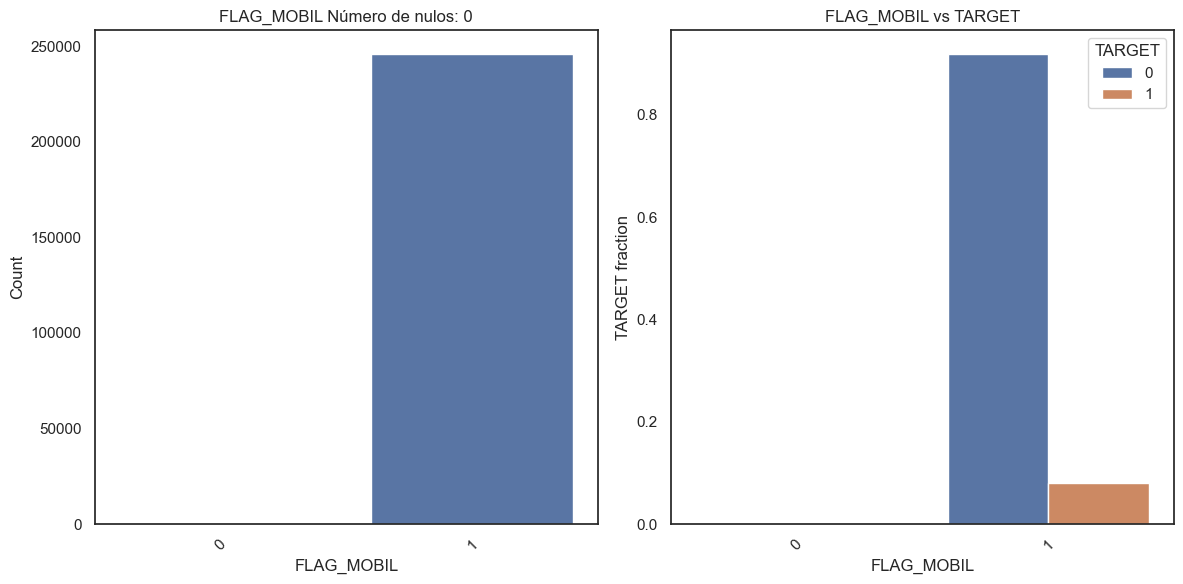

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



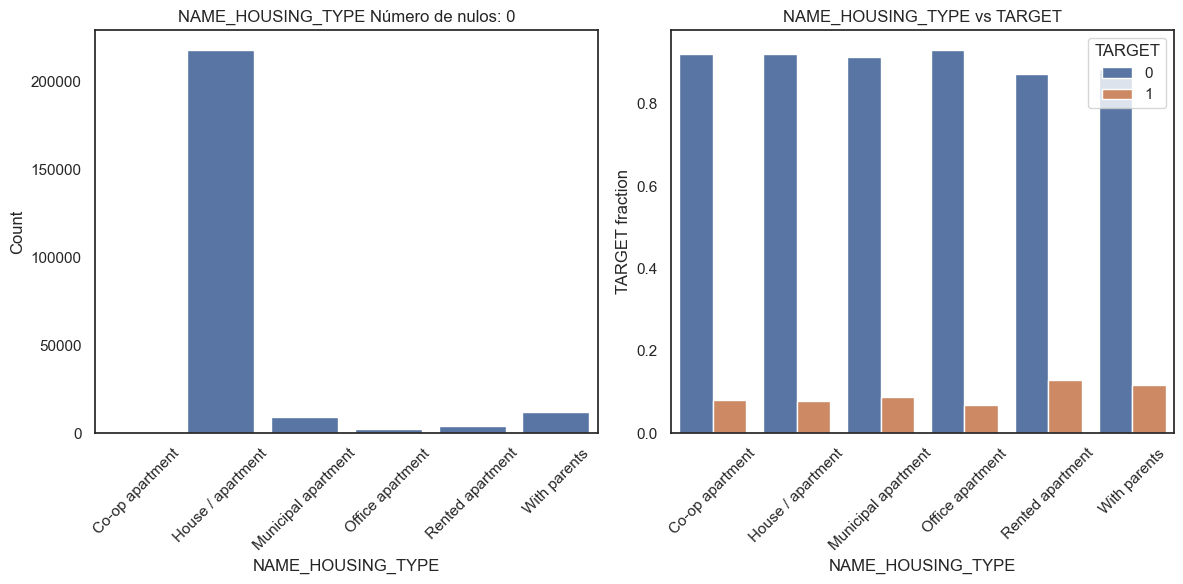

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



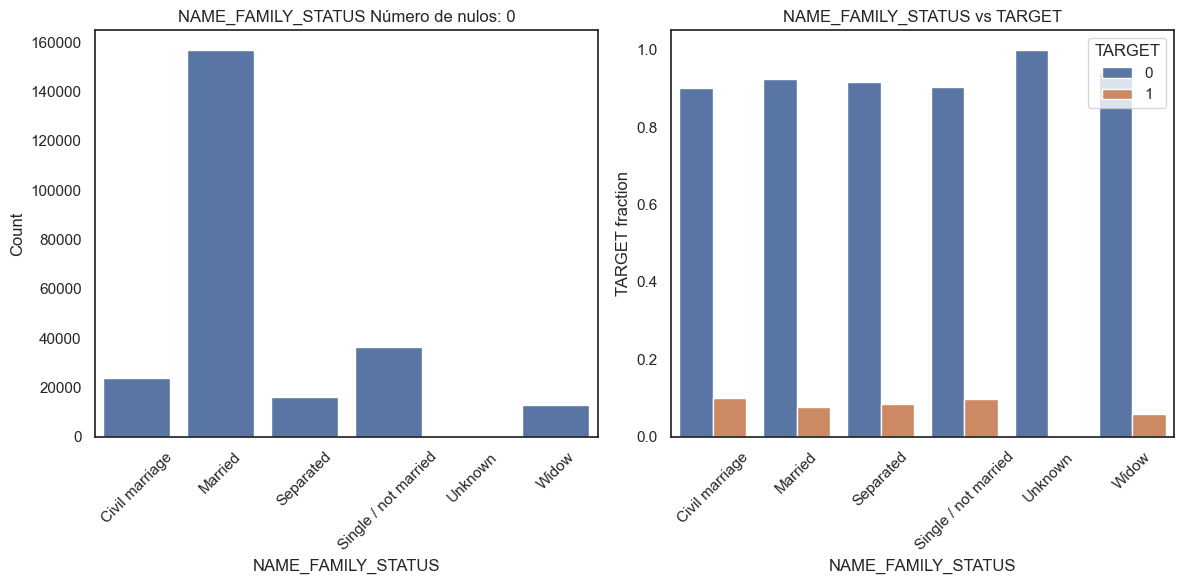

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



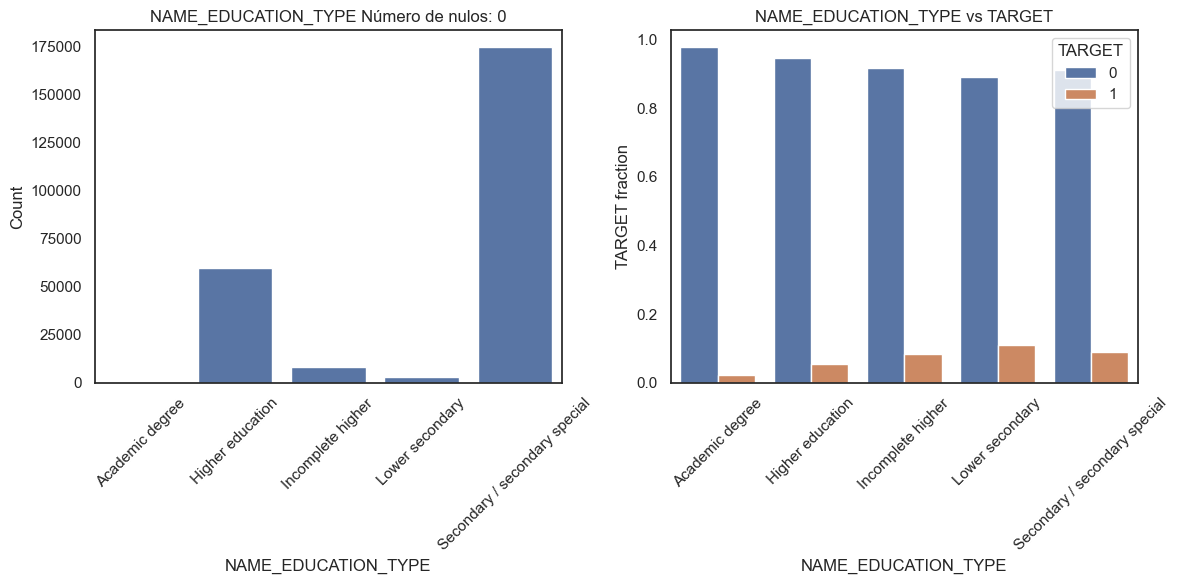

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



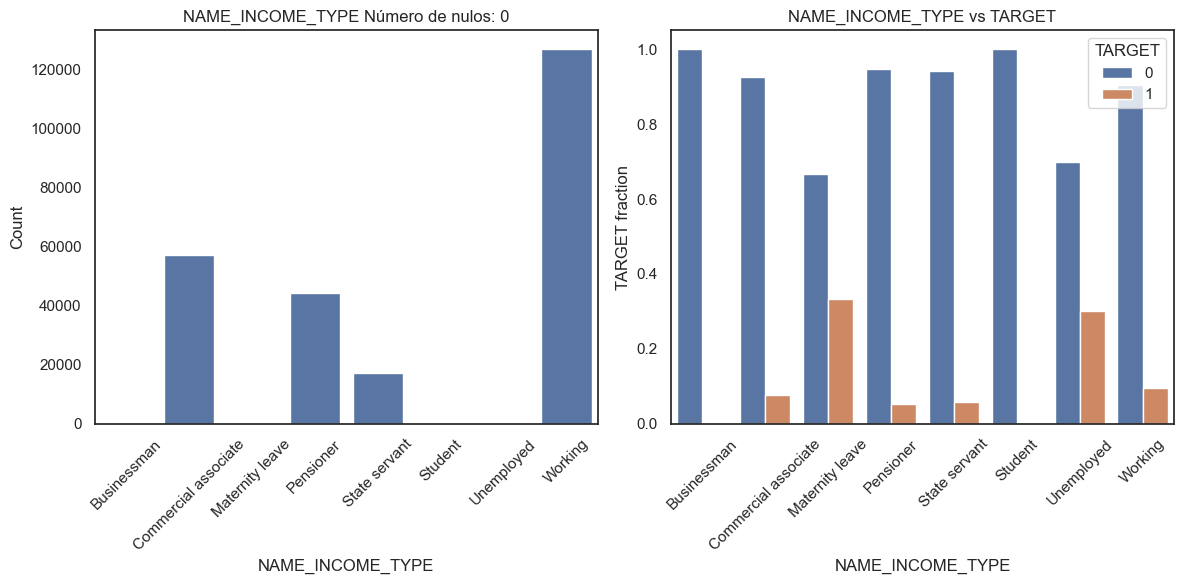

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



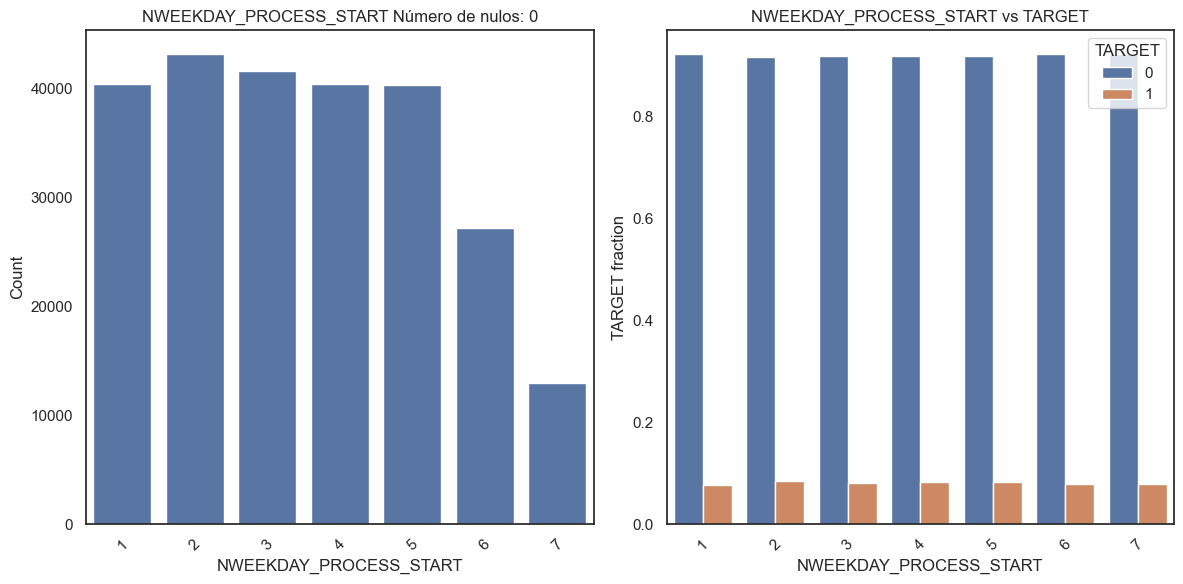

In [59]:
#Realizamos un bucle para las variables categóricas

for variable in list_var_cat:
    if variable != "TARGET":
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Gráfico de conteo
        sns.countplot(data=pd_loan_train, x=variable, ax=axes[0])
        axes[0].set_title(f'{variable} Número de nulos: {pd_loan_train[variable].isna().sum()}')
        axes[0].set_ylabel('Count')

        # Rotar etiquetas del eje X
        axes[0].tick_params(axis='x', rotation=45)

        # Para cada categoría: gráfico de fracciones
        pd_loan_df = pd_loan_train.groupby([variable, 'TARGET']).size().reset_index(name='count')
        pd_loan_df['fraction'] = pd_loan_df['count'] / pd_loan_df.groupby(variable)['count'].transform('sum')

        sns.barplot(data=pd_loan_df, x=variable, y='fraction', hue='TARGET', ax=axes[1])
        axes[1].set_title(f'{variable} vs TARGET')
        axes[1].set_ylabel('TARGET fraction')

        # Rotar etiquetas del eje X
        axes[1].tick_params(axis='x', rotation=45)

        # Ajustar diseño
        plt.tight_layout()
        plt.show()

A partir de estos gráficos, podemos ver a la izquierda el número de valores nulos para cada categoría de las variables, y en el de la derecha, cómo se distribuye una variable en función de la variable TARGET. Por lo general, vemos que los datos están bastante desbalanceados, pues hay muchas variables que no vemos que tengan un impacto fuerte en el impago del préstamo. A continuación, vamos a comentar algunas variables que puedan ser significativas en el impago del préstamo.

NAME_INCOME_TYPE (Situación laboral del solicitante)
En el gráfico de la izquierda vemos que la mayoría de los datos se asocian con 'Working', es decir, personas que tienen un empleo. Otras categorías presentan también una parte de los datos, como 'Pensioner' o 'Commercial Associate'. Otras categorías como 'Student' o 'Unemployed' presentan muy poca distribución de los datos, o ninguna. En el gráfico de la derecha, que muestra la fracción de incumplimiento para cada categoría, vemos que las personas desempleadas o las que están de baja por maternidad, tienen un porcentaje alto de incumplimiento. Los desempleados parece lógico, pues se asocia con la falta de un trabajo estable. Otras categorías como los pensionistas o los trabajadores presentan un grado bajo de incumplimiento, pues están asociados con un salario o pensión.

NAME_EDUCATION_TYPE(Nivel de educación)
En el gráfico de la izquierda vemos que los datos se distribuyen sobre todo en clientes que tienen 'Secondary/Secondary Special', seguidos de 'Higher Education'. 'Academid degree' o 'Lower Secundary' son menos comunes.En el gráfico de la derecha se muestra las fracciones de incumplimiento para cada nivel educativo. Como vemos, secundaria, secundaria especial o secundaria baja son los niveles que más probabilidad de incumplimiento tienen, algo que puede estar relacionado por el tipo de empleo que estos clientes tienen, asociado con la baja formación académica recibida. Los clientes con un grado o educación superior presentan menor riesgo de incumplimiento, algo que también puede estar relacionado por el caso contrario al anterior.Podemos concluir que el nivel educativo influye en la capacidad de incumplimiento del solicitante.

NAME_HOUSING_TYPE(Tipo de vivienda)
En el gráfico de la izquierda vemos que la mayoría de los datos se asocian con clientes que vivene un apartameto o casa, que por otra parte es lo más normal. Otras categorías presentan una distribución de los datos mucho menor, como 'Municipal Apartment', 'With Parents' o 'Rented Apartment'. En cuanto a su relación con TARGET, vemos que la fracción de incumplimineto es algo mayor para aquellos solicitantes que viven con los padres o de alquiler. Esto puede estar relacionado con un menor grado de cumplimineto, pues los que viven con sus padres es posible que no tengan una ocupación, aunque también pueden ser aún jóvenes para independizarse. Aun así, no parece una variable muy significativa en cuanto al grado de incumplimiento del préstamo.

OCCUPATYON_TYPE (Tipo de trabajo)
Al observar la variable, vemos que presenta una buena cantidad de nulos que podríamos imputar para mejorar el análisis. En el gráfico de la izquierda, vemos que la mayoría de los solicitantes pertenecen a 'Laborers'(en mayor proporción), 'Core Staff' y 'Sales Staff'. Como vemos en el gráfico de la derecha, los trabajadores dedicados a actividades manuales o físicas como la construcción, fabricación, agaricultura, así como aquellos con una baja especialización, como por ejemplo, ayudante de obra, presentan mayor incumplimineto de devolver el préstamo. Otros gremios, como los conductores o los vigilantes de seguridad presentan un grado de incumplimiento menor, aunque mayor que el resto. Esto puede estar debido a la formación educativa, ya que estos trabajos no requieren de una cualificación para dedicarse a ellos. Podemos concluir que el tipo de ocupación puede influir en el grado de incumplimiento del préstamo.

CODE_GENDER(Género)
Como vemos en el gráfico de la izquierda, hay mayor proporción de clientes femeninos que masculinos.En el gráfico de la derecha no parece haber una diferencia extremadamente significativa entre el grado de incumplimineto de hombres y mujeres, aunque si nos fijamos el grado de incumplimiento mayor es ligeramente masculino. Esto puede deberse a muchas razones como el tipo de trabajo, mentalidad o tipo de educación, entre otras. En conclusión, esta variable tiene una relación moderada con la probabilidad de incumplkimiento, siendo importante considerar cómoa actúa con otras variables.

NAME_CONTRACT_TYPE (Tipo de contrato)
En el gráfico de la izquierda vemos que la mayoría de los préstamos pertenecen a 'Cash Loans', mientras que los 'Revolving Loans' tienen una proproción mucho menor. Con respecto a la variable TARGET, vemos que no hay una gran diferencia en la probabilidad de incumplimiento entre ambos préstamos, pero sí que es verdad que los 'Cash Loans' tienen una probabilidad mayor, cosa que tiene sentido al ser mucho más comunes en el día a día.


TRATAMIENTO DE VARIABLES CONTINUAS

A continuación se tratarán tres aspectos clave del análisis de los datos: los valores missing, los outliers y las correlaciones entre las variables continuas

In [60]:
list_var_continuous

['COMMONAREA_MEDI',
 'COMMONAREA_AVG',
 'COMMONAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_MEDI',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_MEDI',
 'FLOORSMIN_AVG',
 'FLOORSMIN_MODE',
 'FLOORSMIN_MEDI',
 'YEARS_BUILD_MEDI',
 'YEARS_BUILD_MODE',
 'YEARS_BUILD_AVG',
 'OWN_CAR_AGE',
 'LANDAREA_MEDI',
 'LANDAREA_MODE',
 'LANDAREA_AVG',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MODE',
 'EXT_SOURCE_1',
 'NONLIVINGAREA_MODE',
 'NONLIVINGAREA_AVG',
 'NONLIVINGAREA_MEDI',
 'ELEVATORS_MEDI',
 'ELEVATORS_AVG',
 'ELEVATORS_MODE',
 'APARTMENTS_MEDI',
 'APARTMENTS_AVG',
 'APARTMENTS_MODE',
 'ENTRANCES_MEDI',
 'ENTRANCES_AVG',
 'ENTRANCES_MODE',
 'LIVINGAREA_AVG',
 'LIVINGAREA_MODE',
 'LIVINGAREA_MEDI',
 'FLOORSMAX_MODE',
 'FLOORSMAX_MEDI',
 'FLOORSMAX_AVG',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BEGINEXPLUATATION_AVG',
 'TOTALAREA_MODE',
 'EXT_SOURCE_3',
 'AMT_REQ_CREDIT_BURE

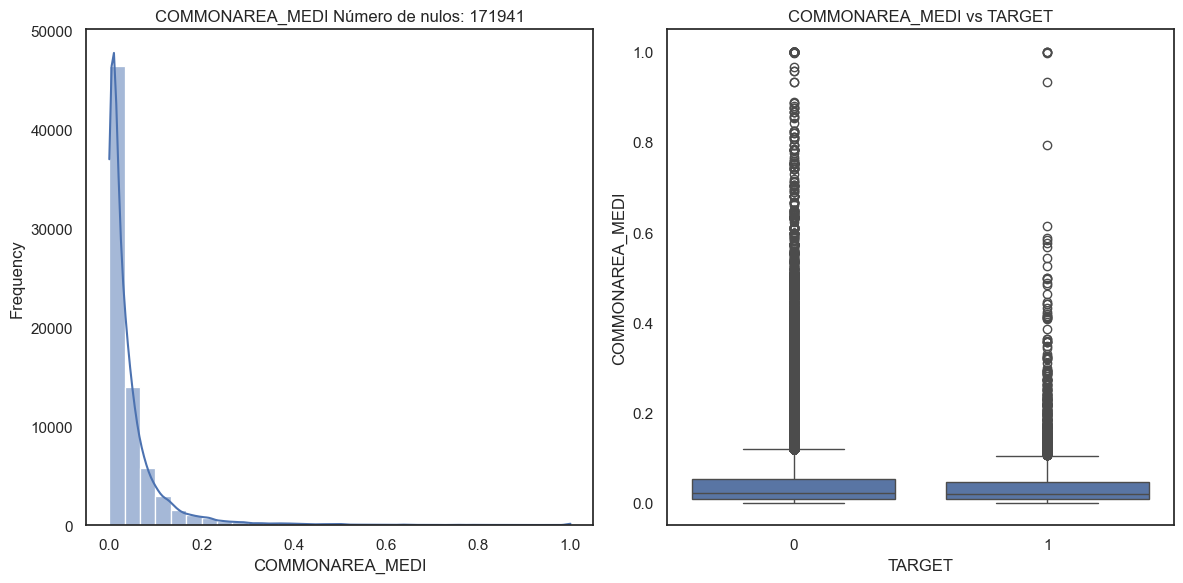

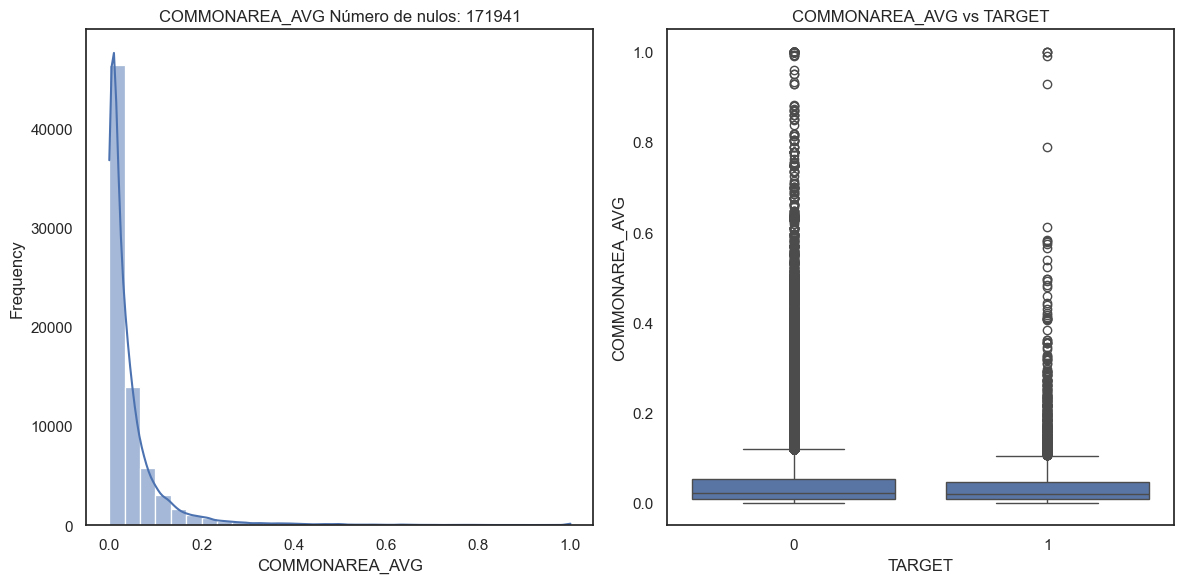

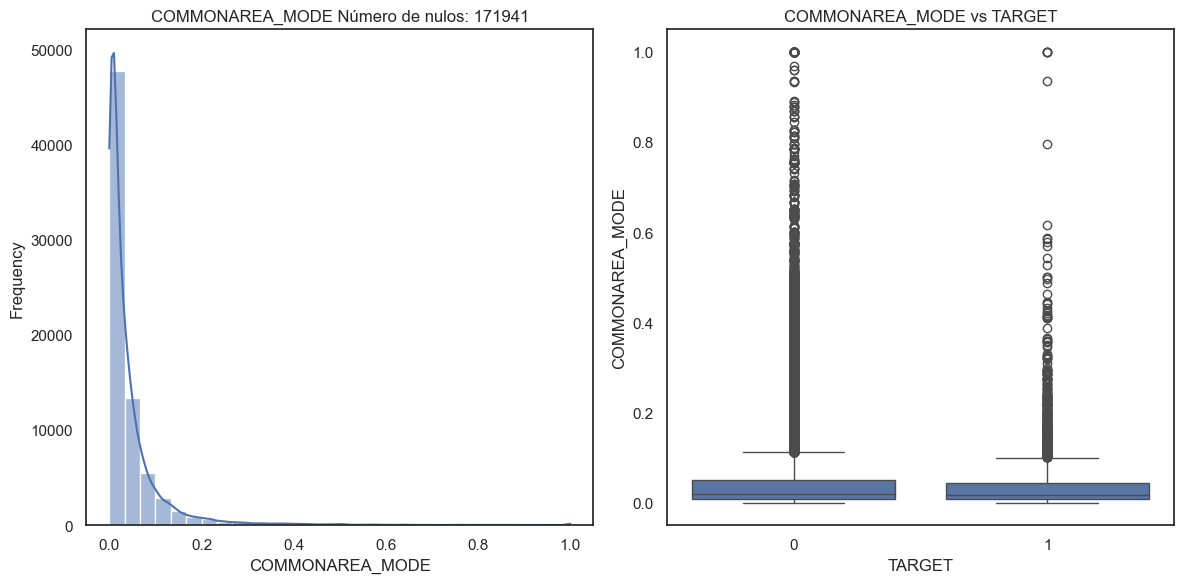

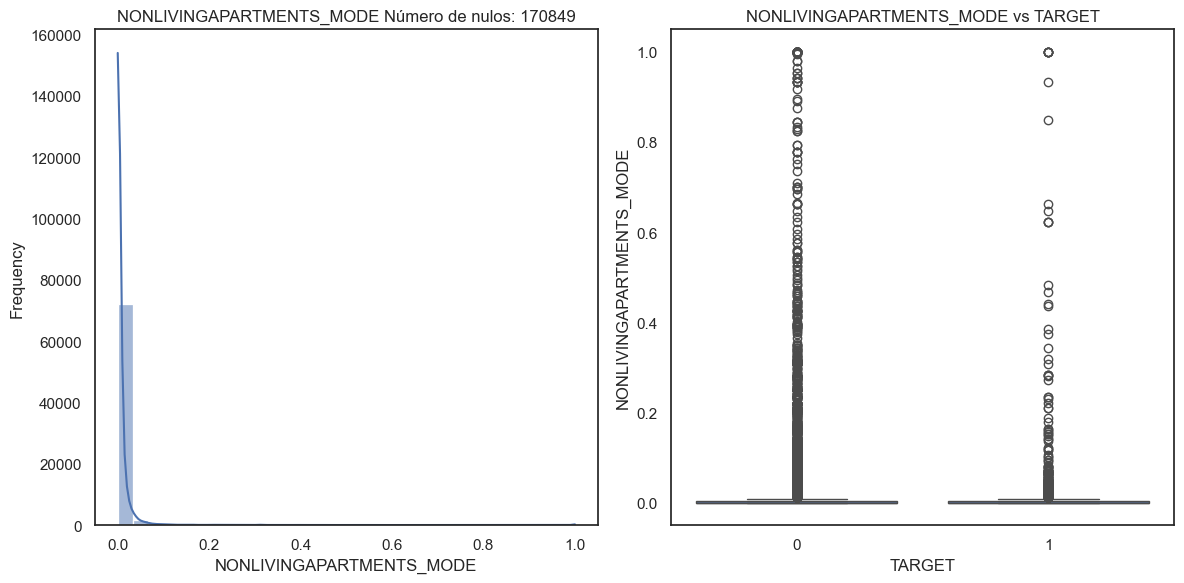

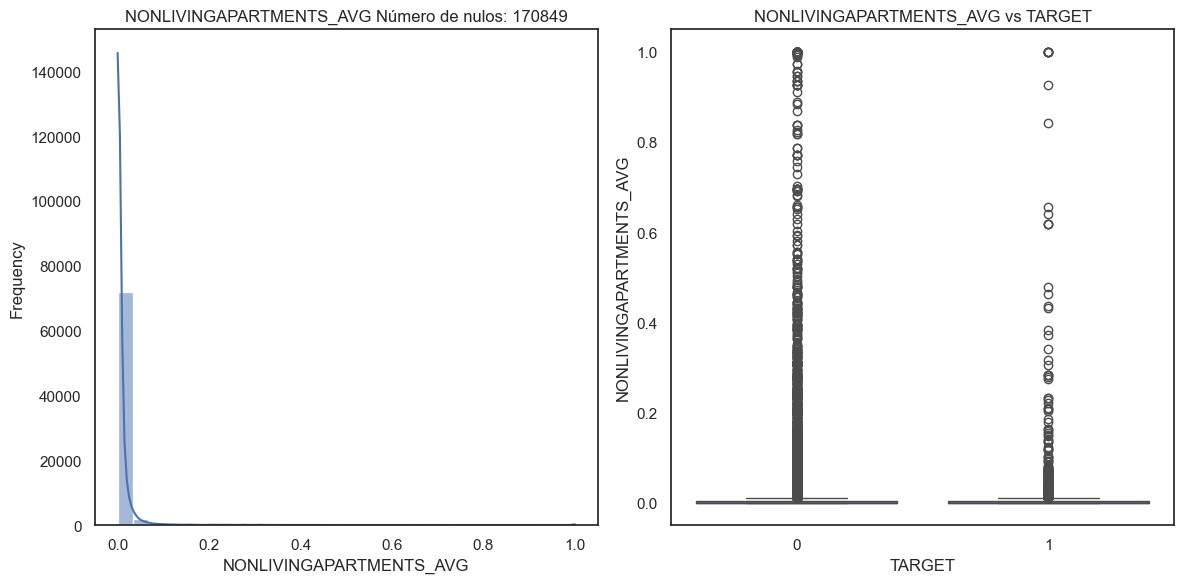

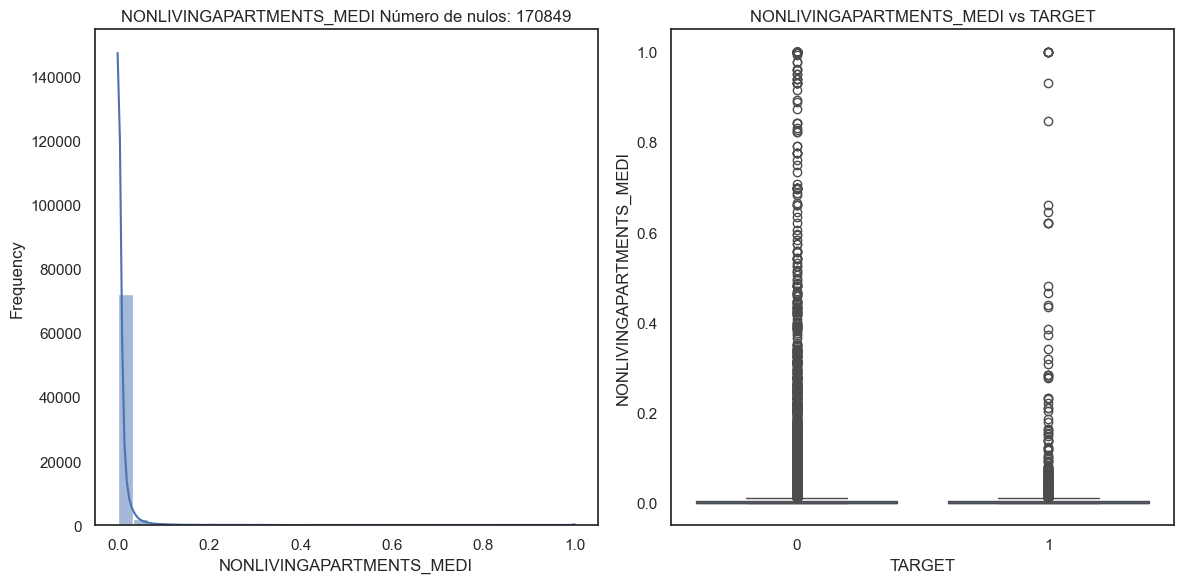

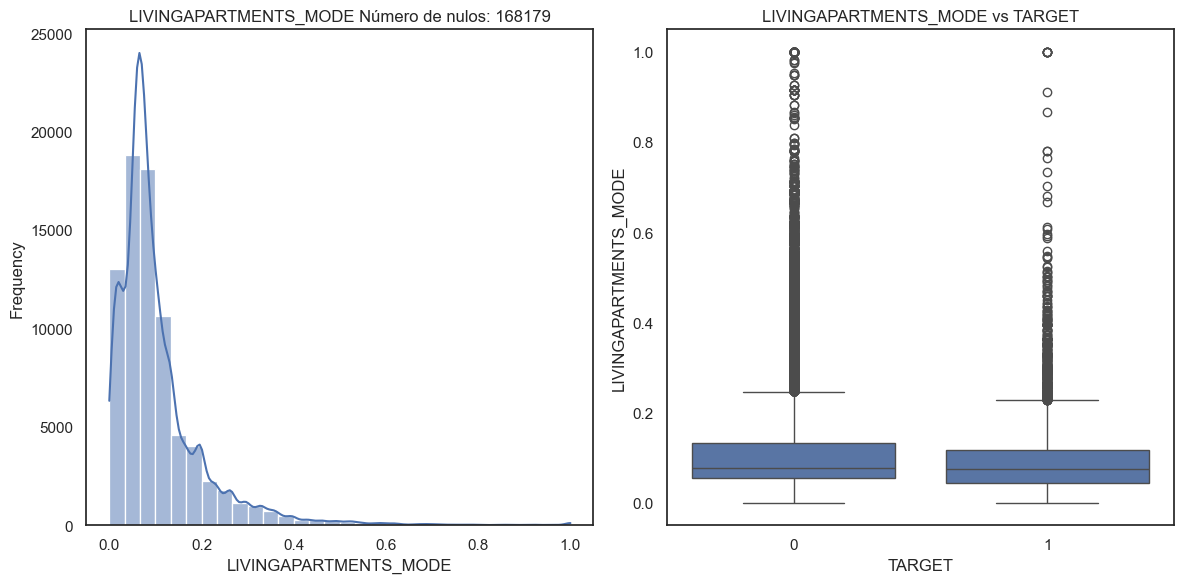

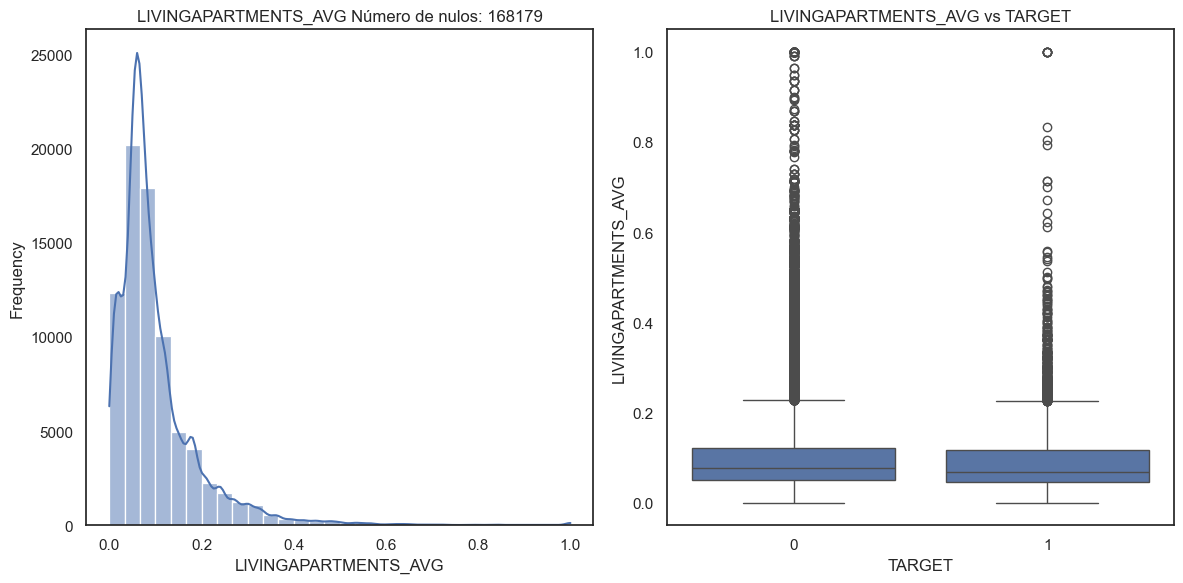

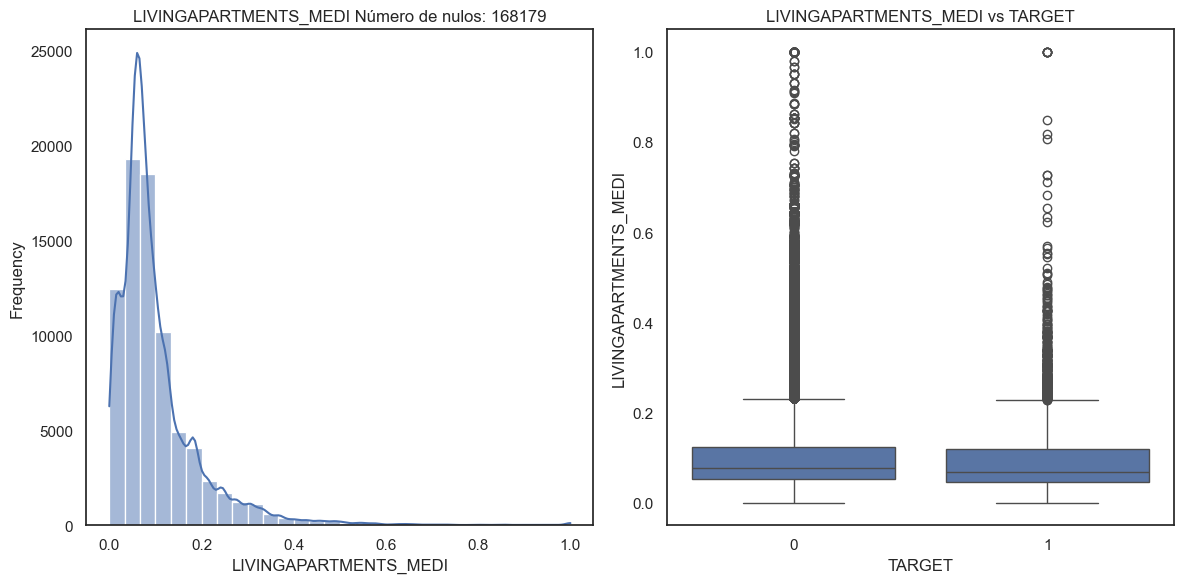

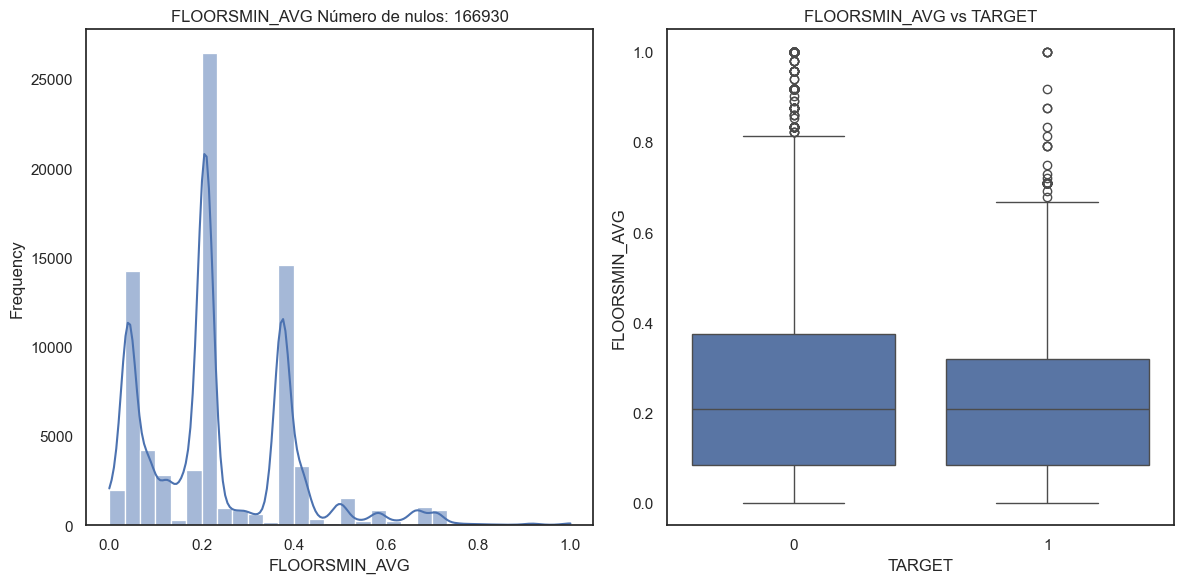

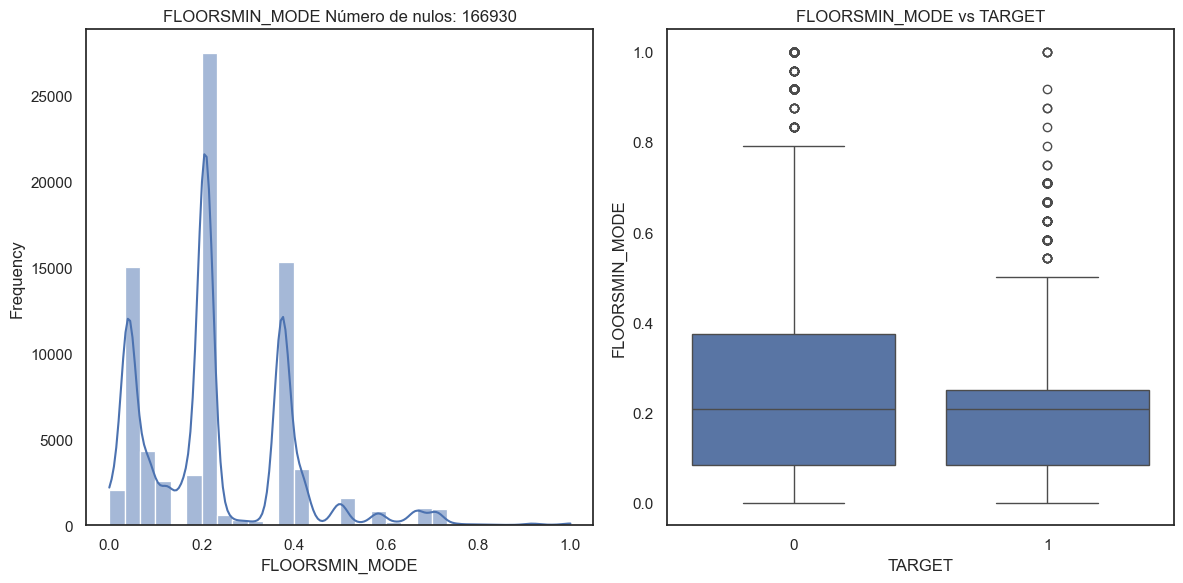

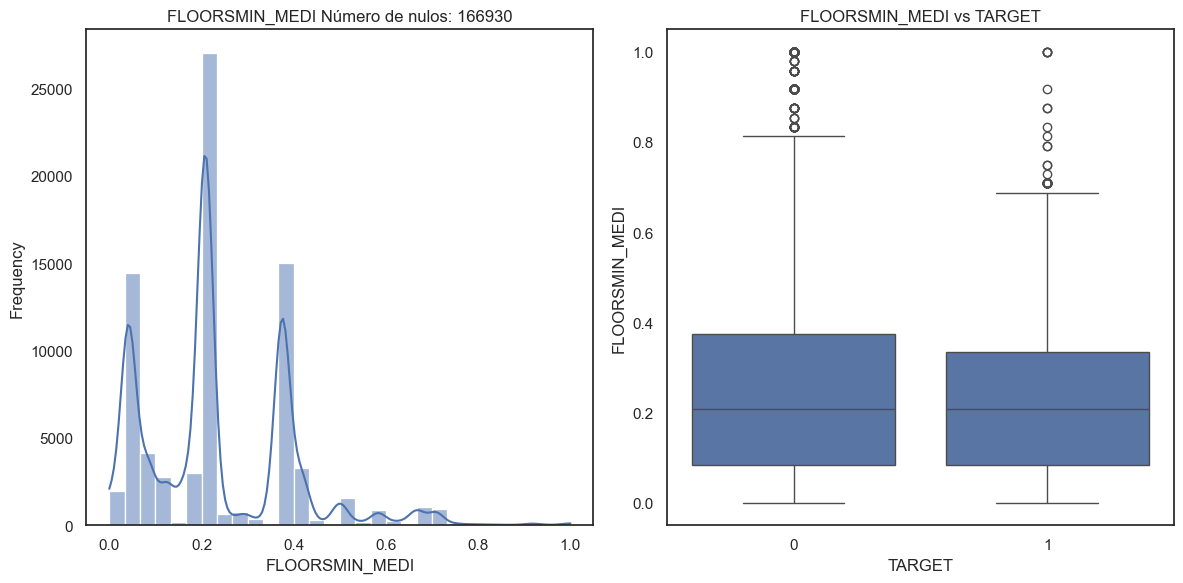

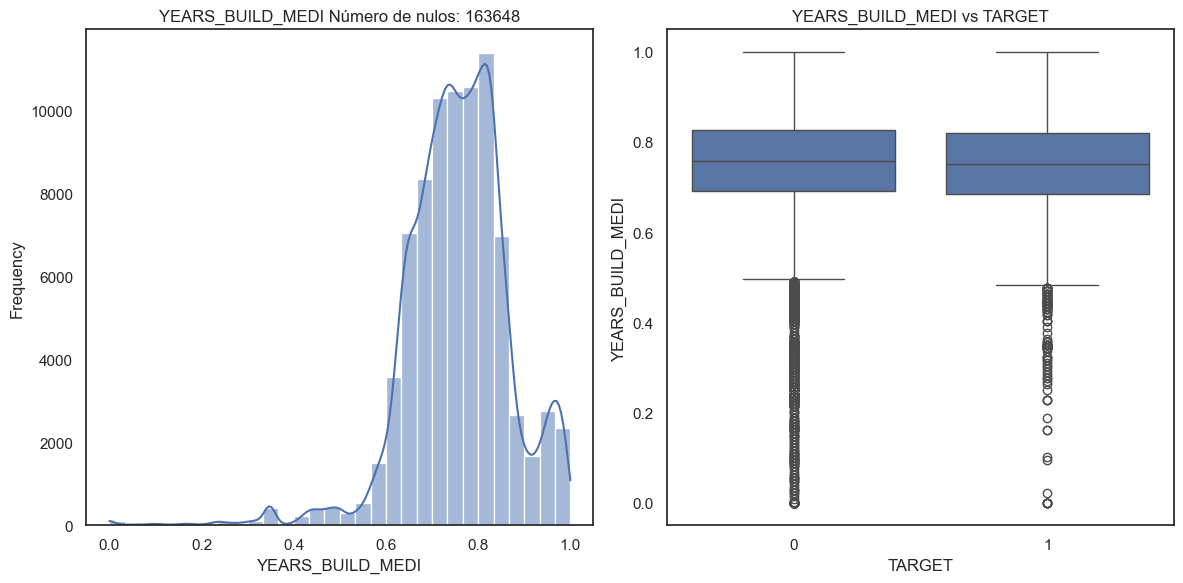

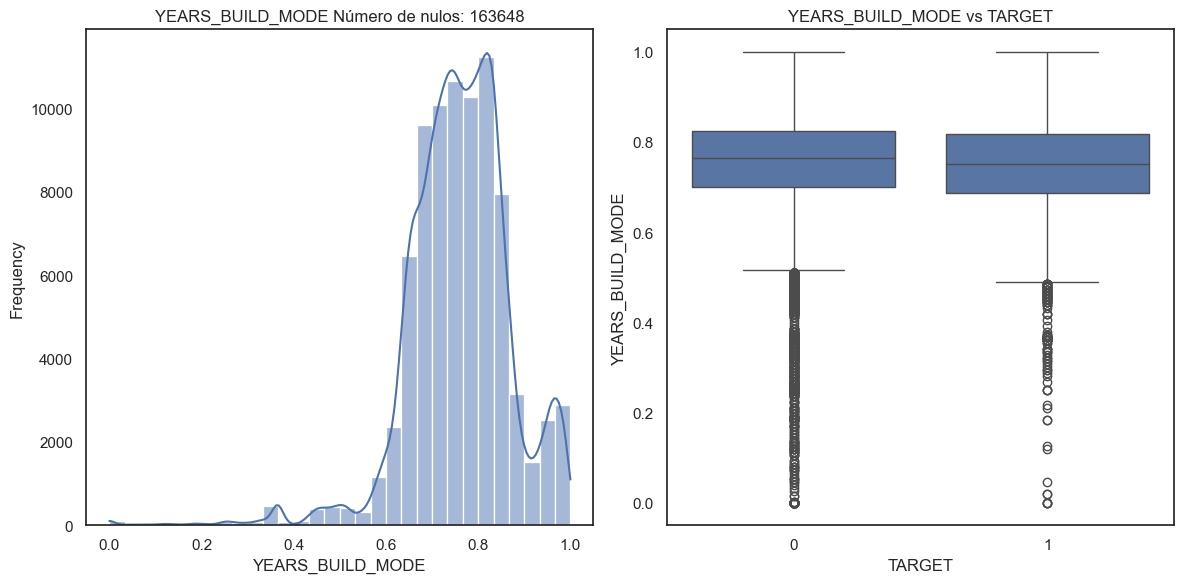

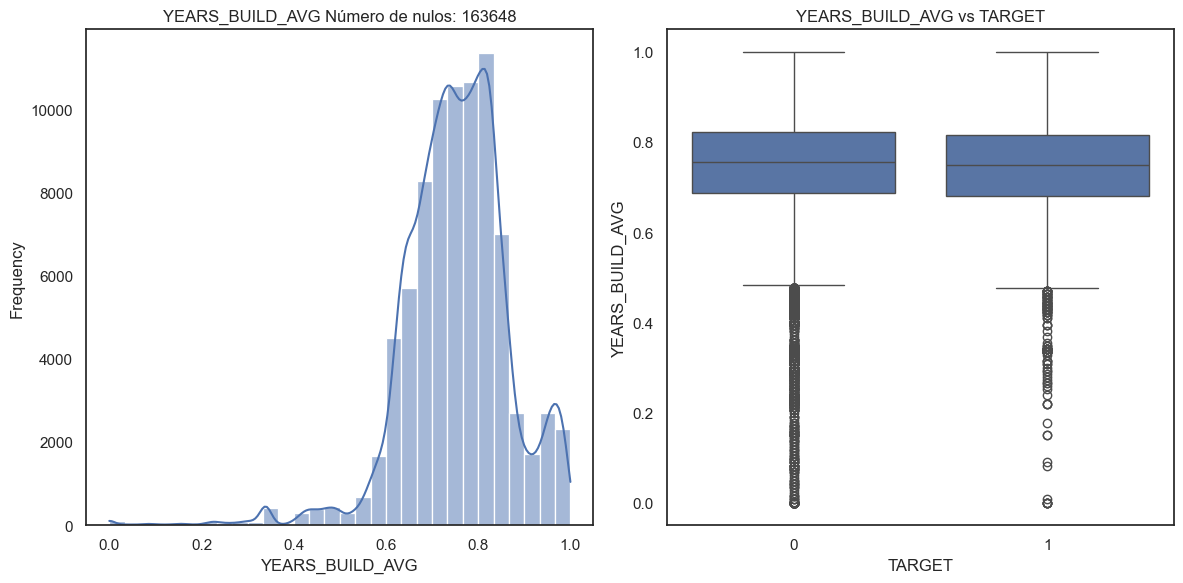

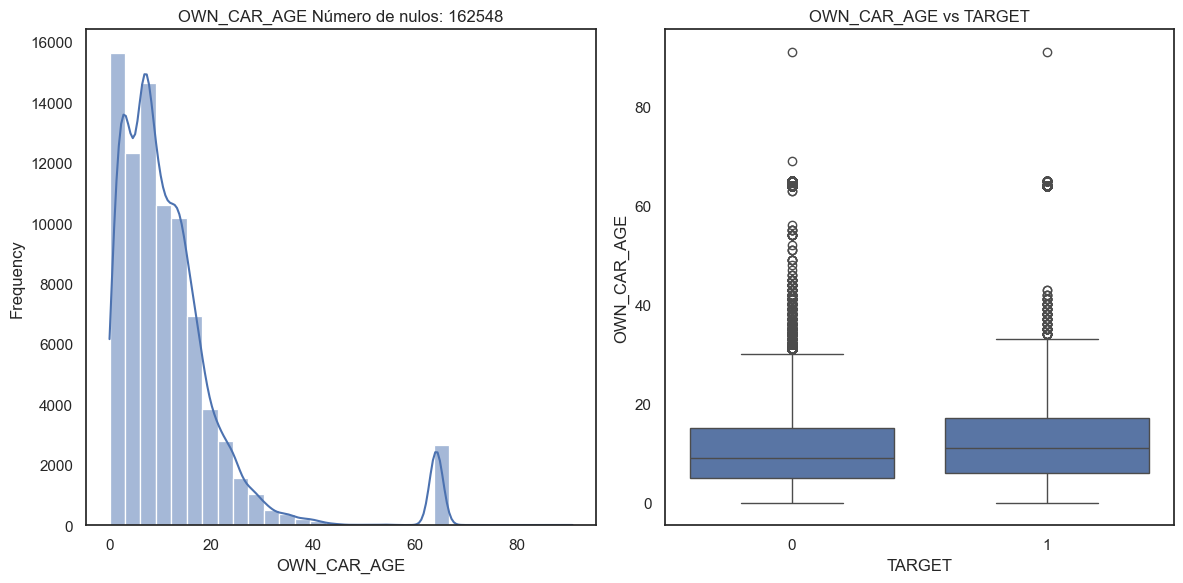

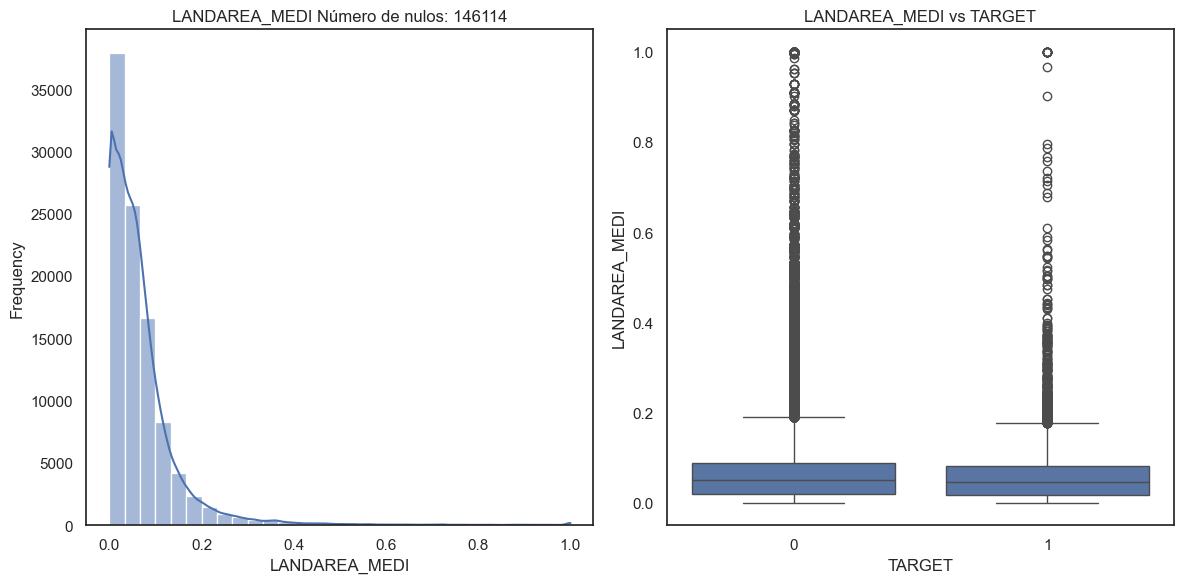

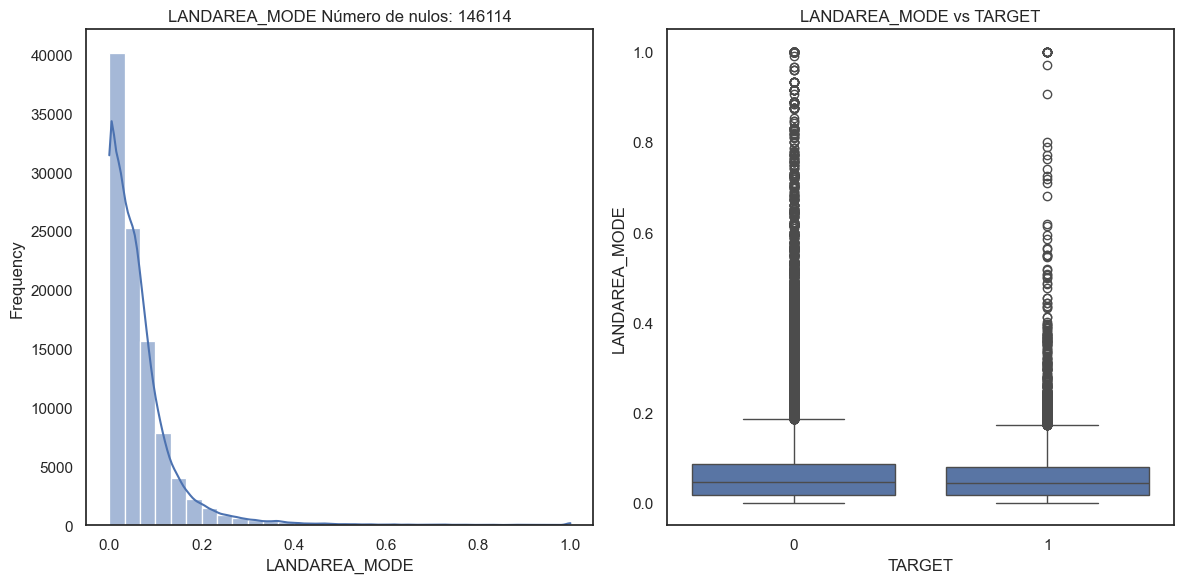

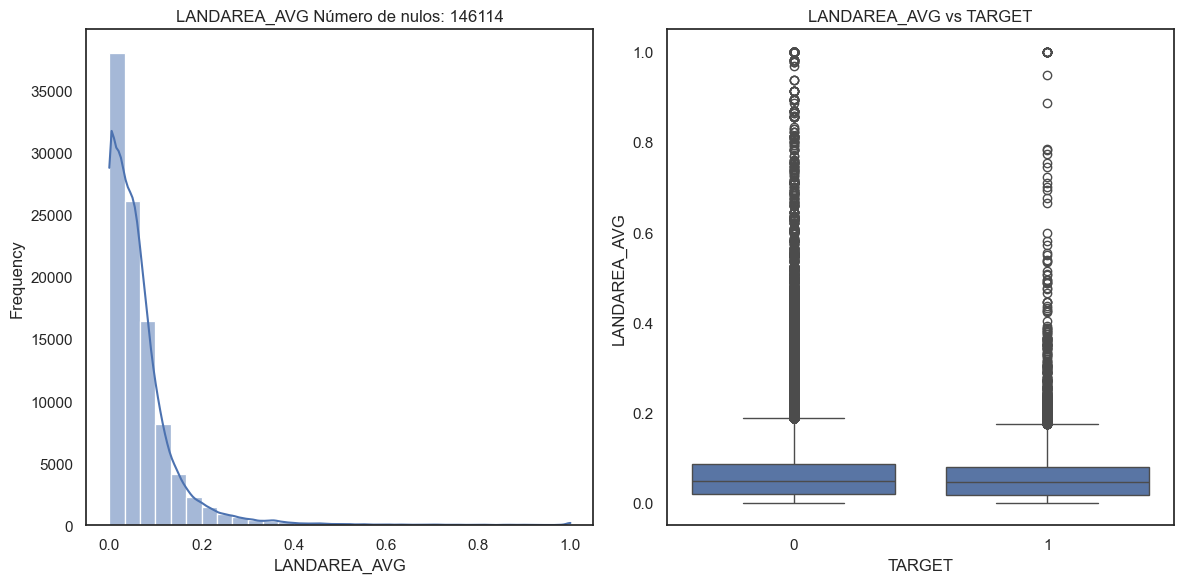

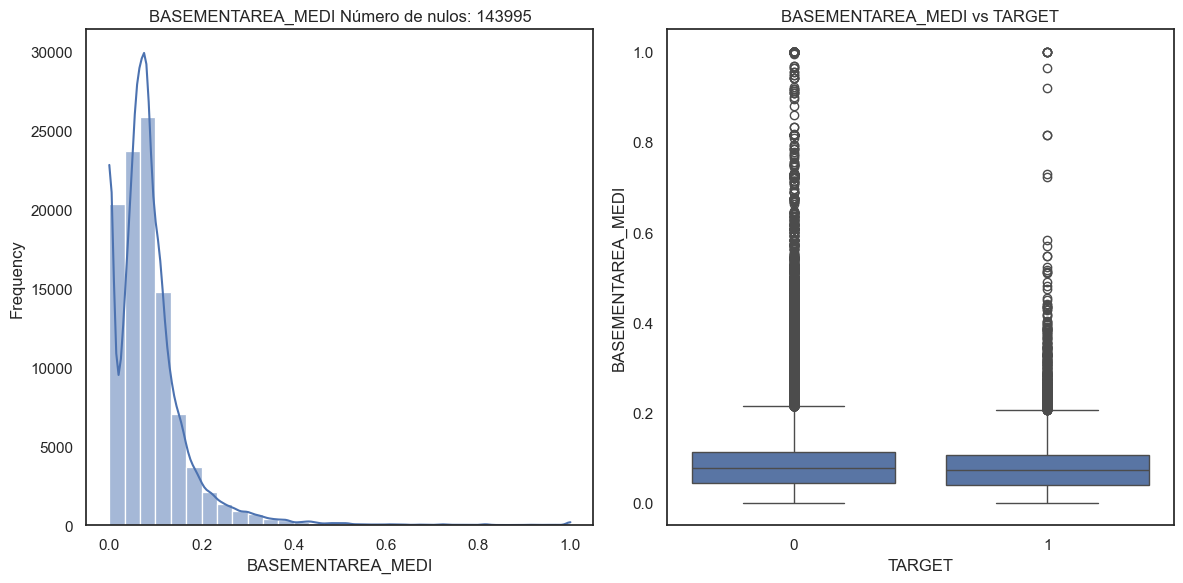

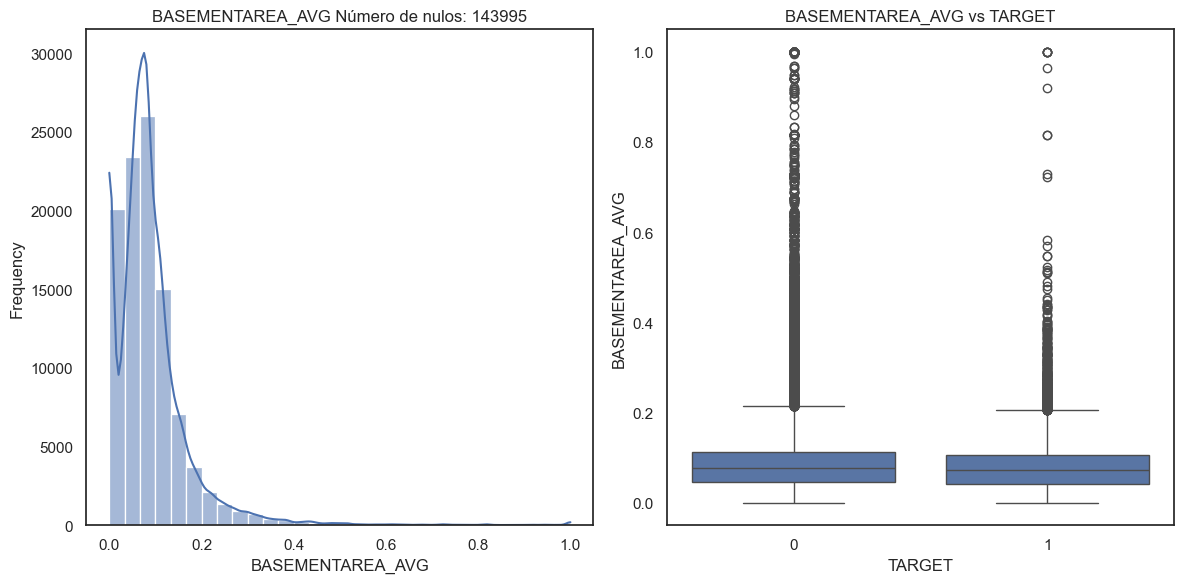

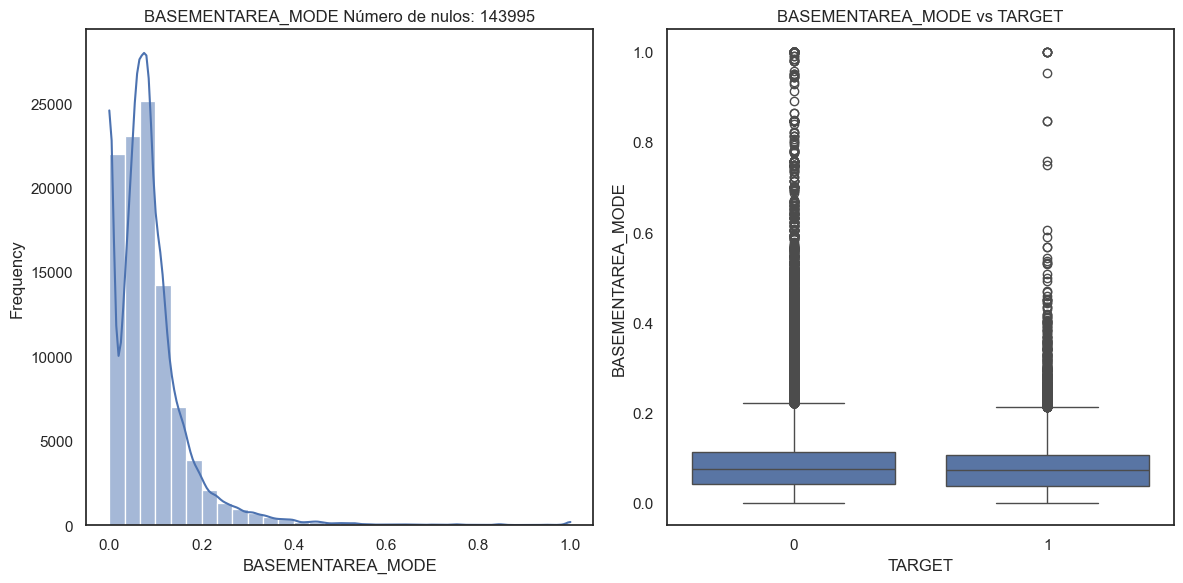

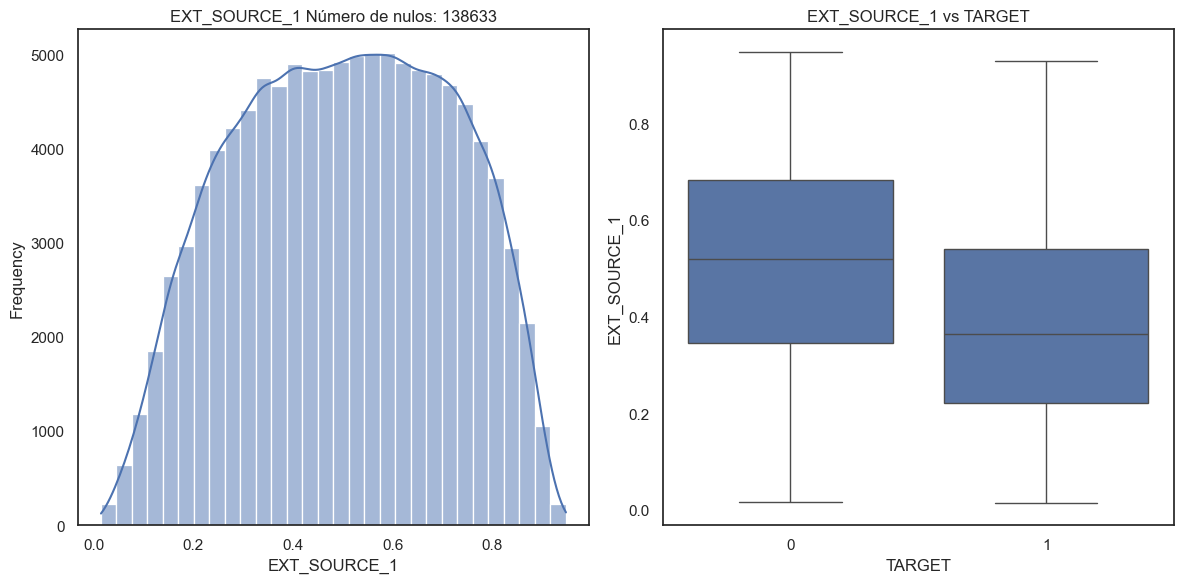

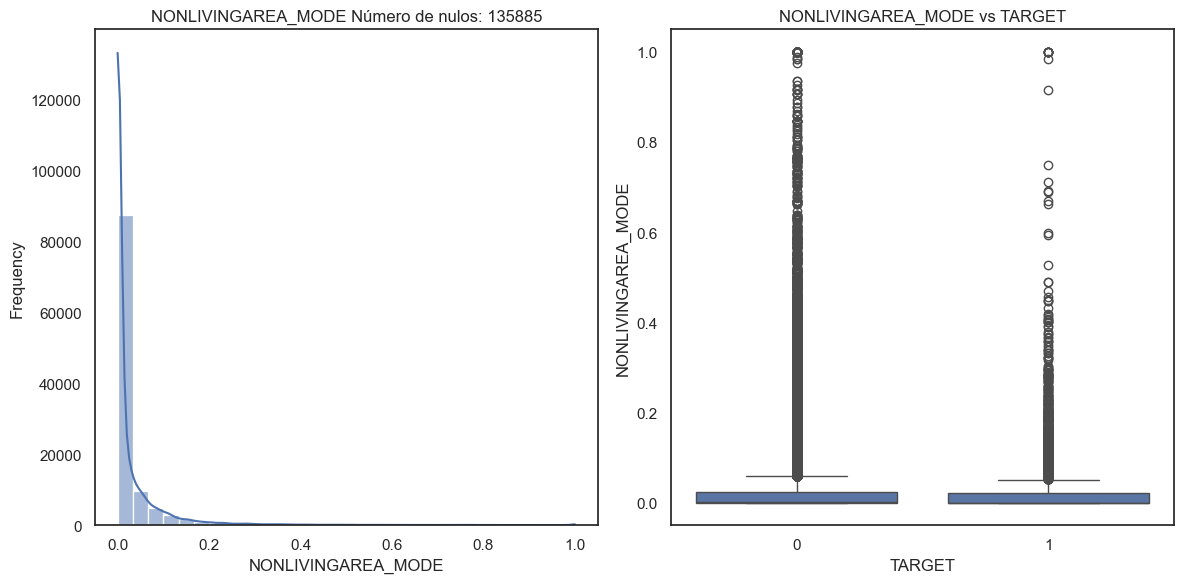

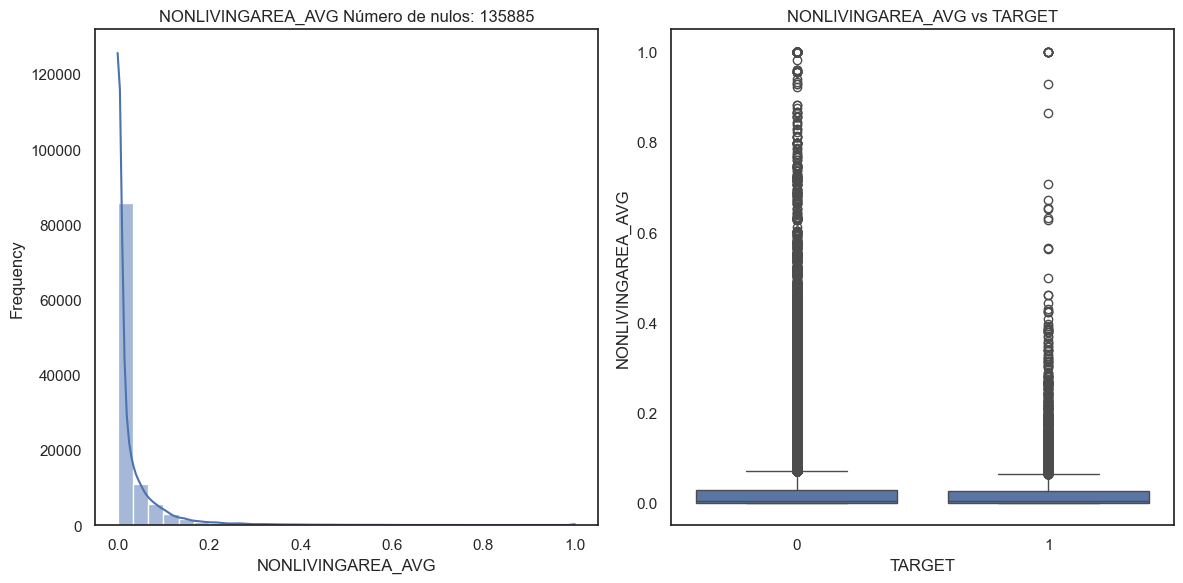

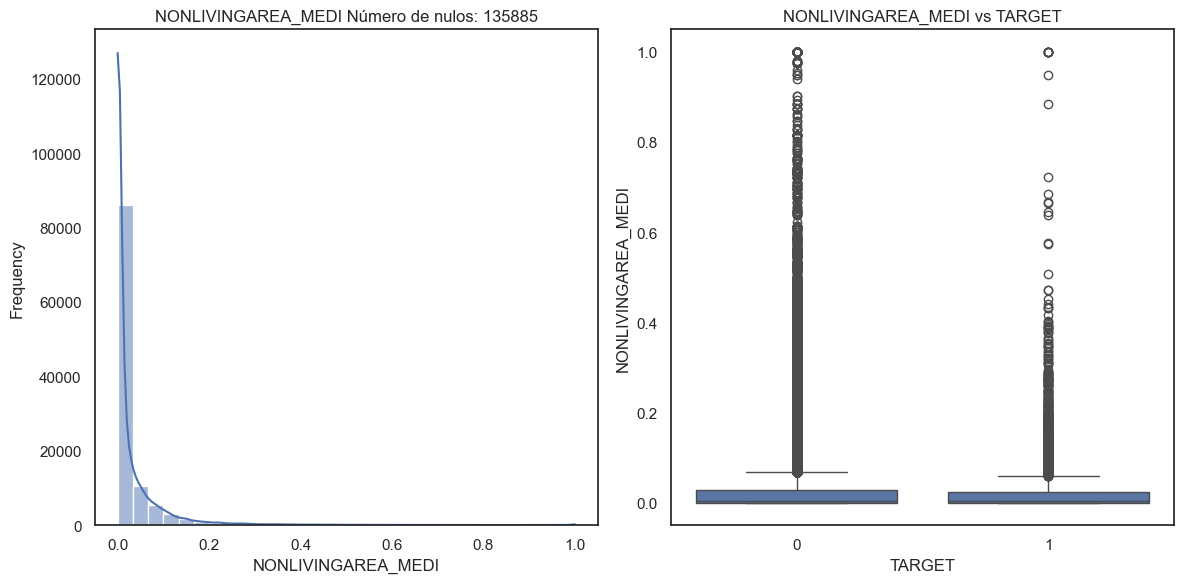

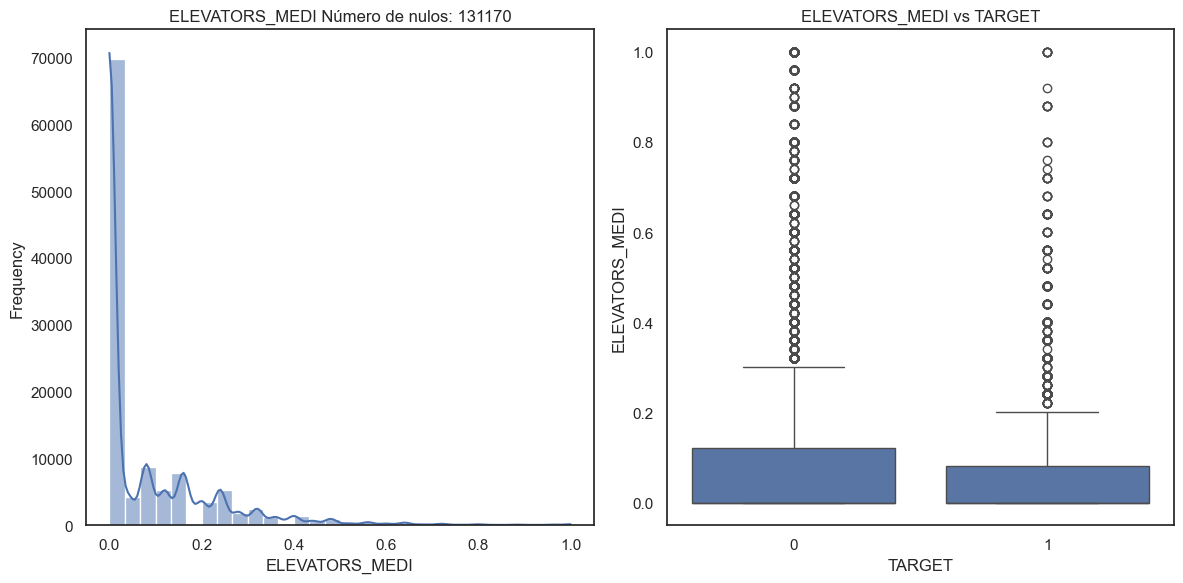

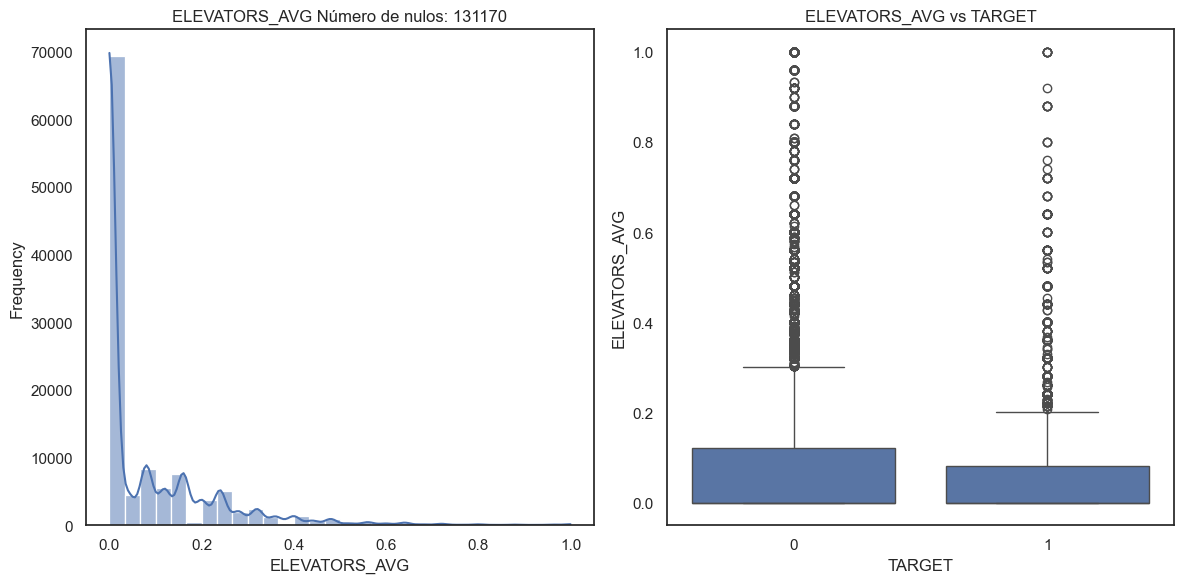

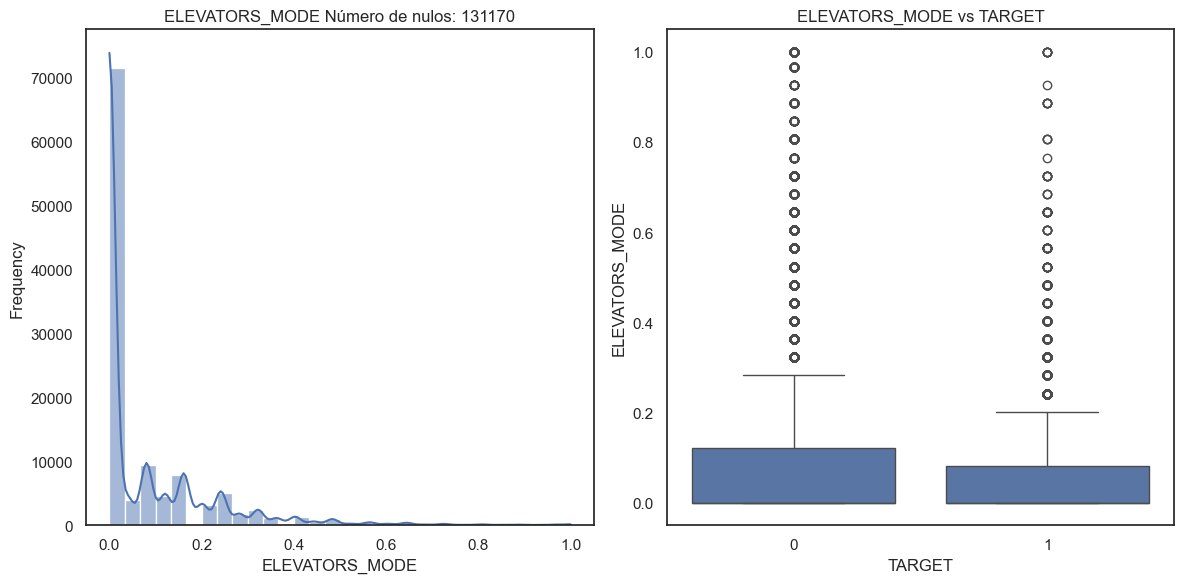

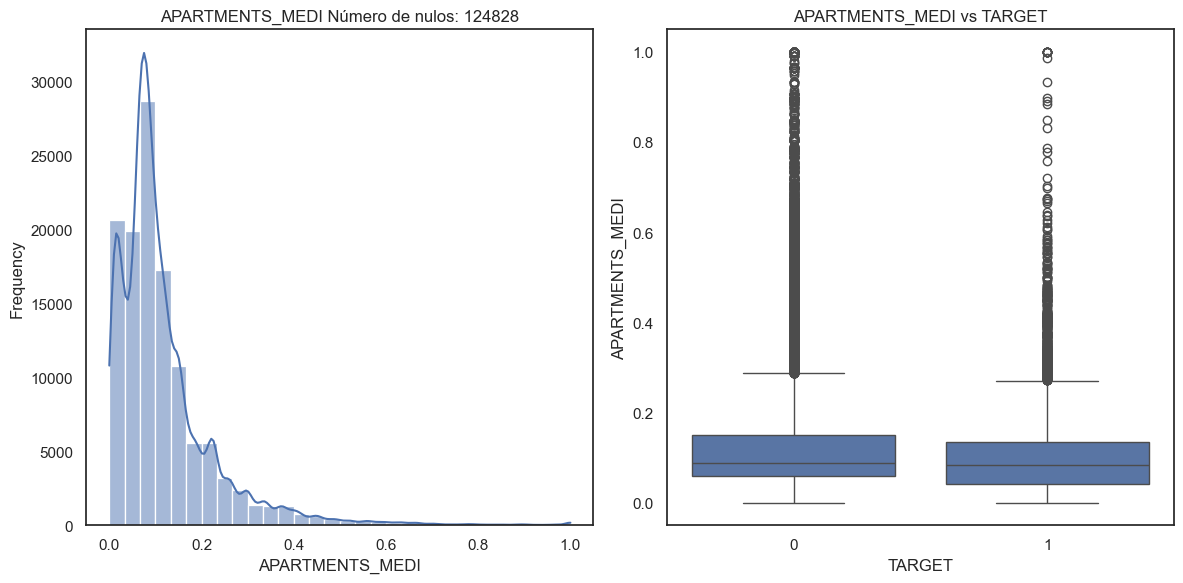

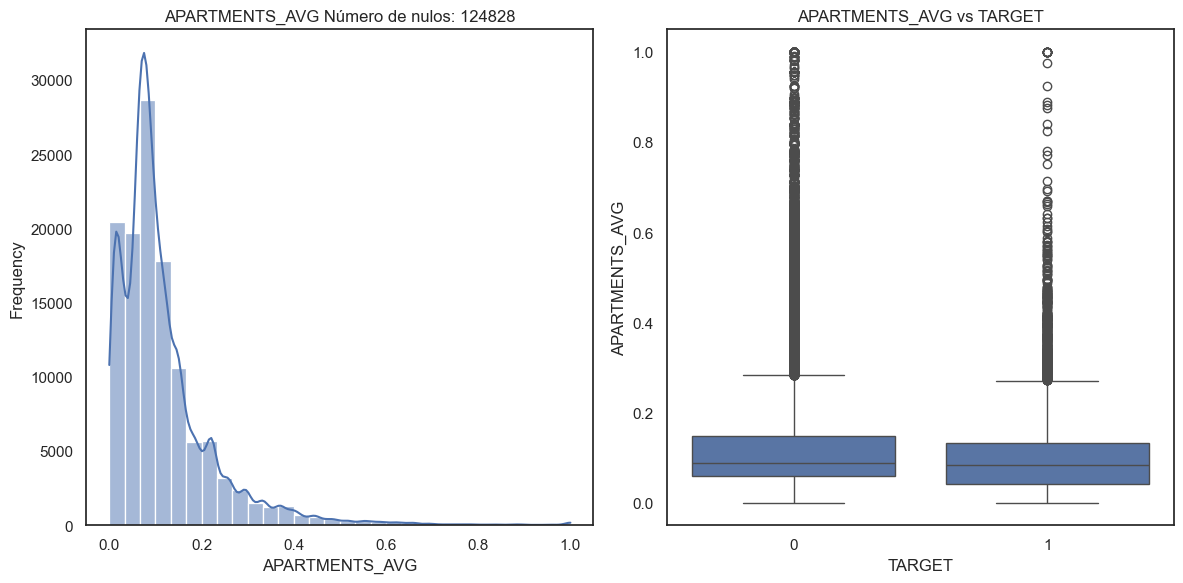

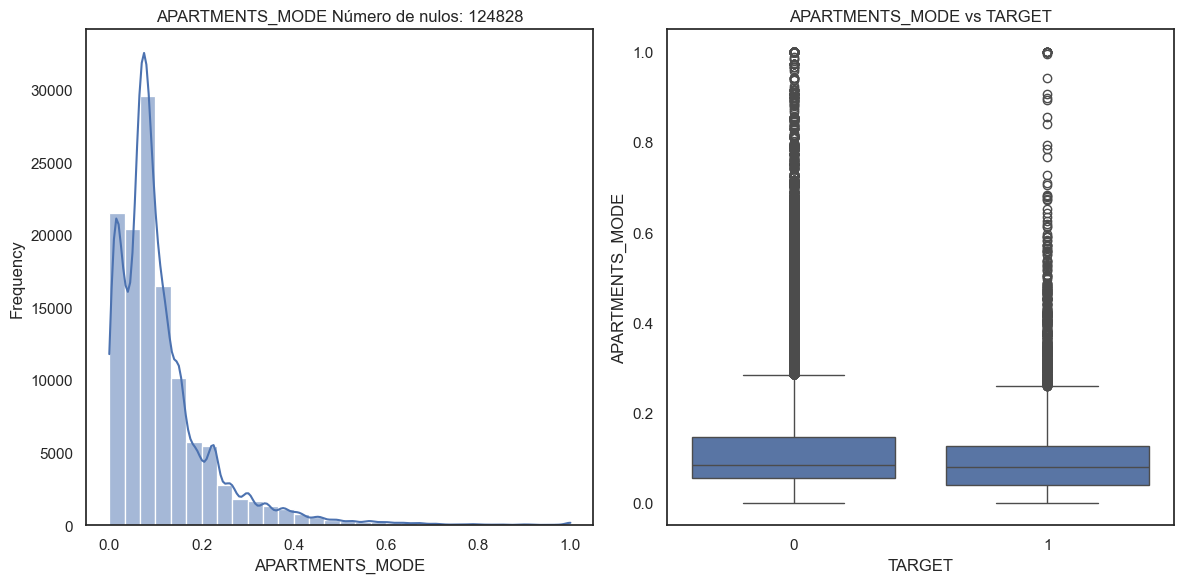

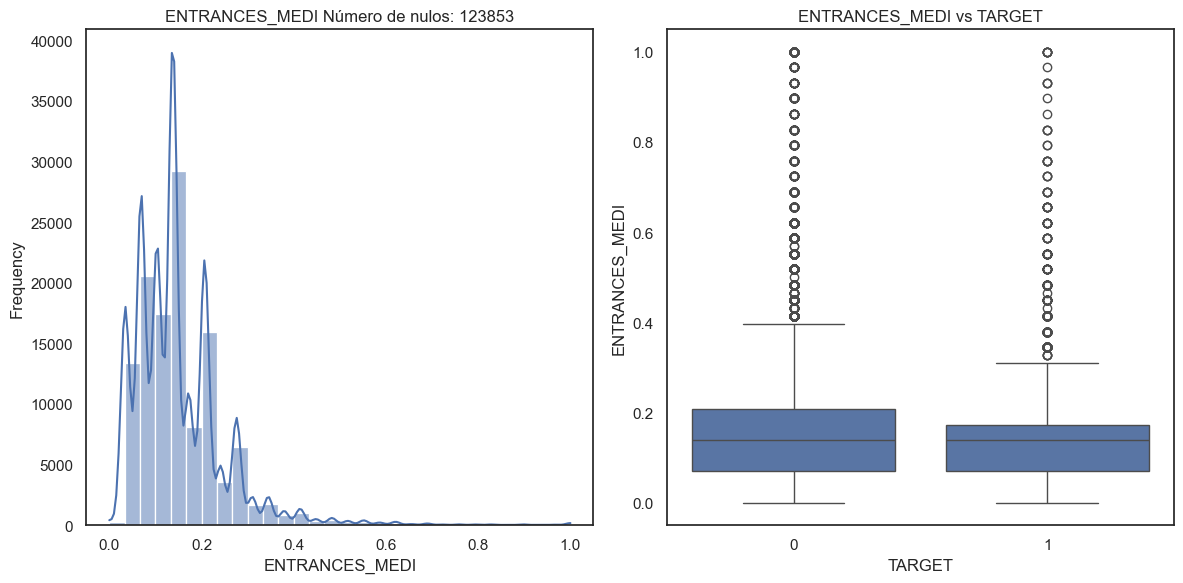

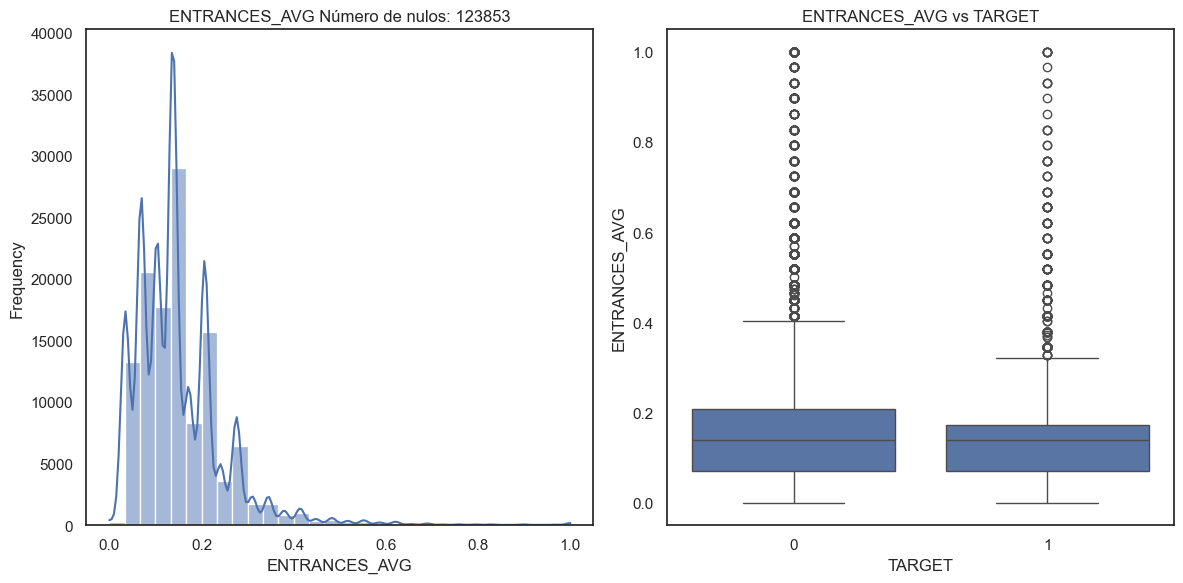

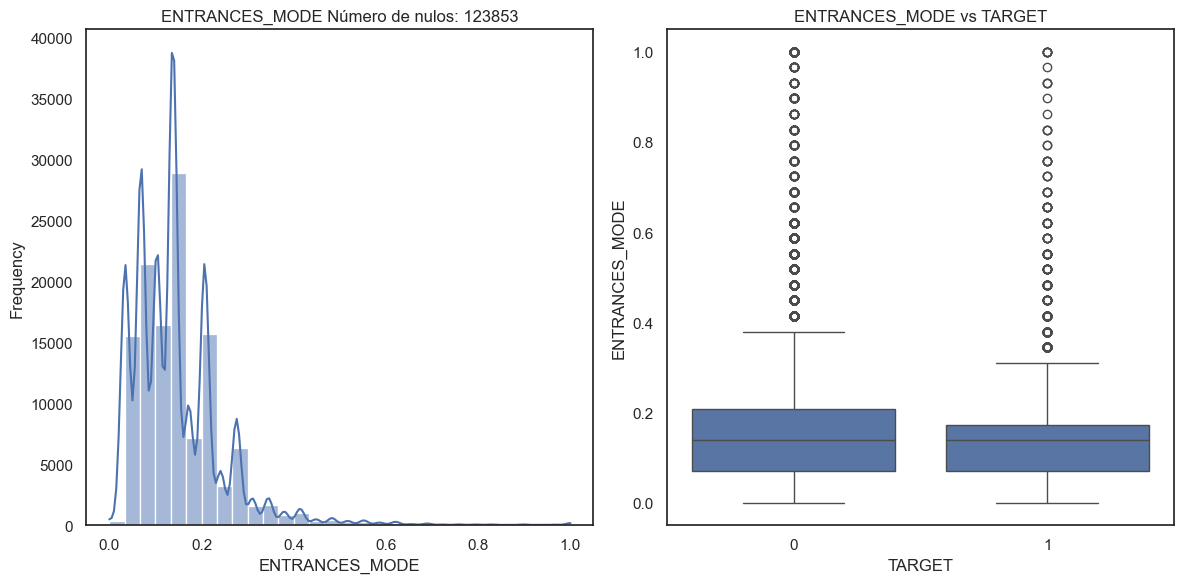

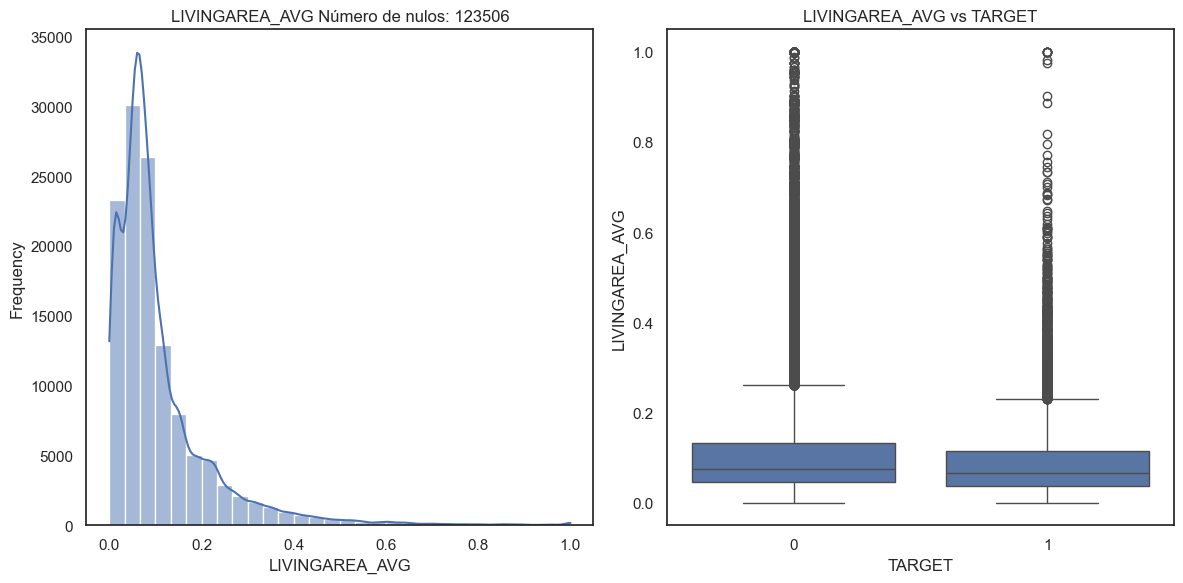

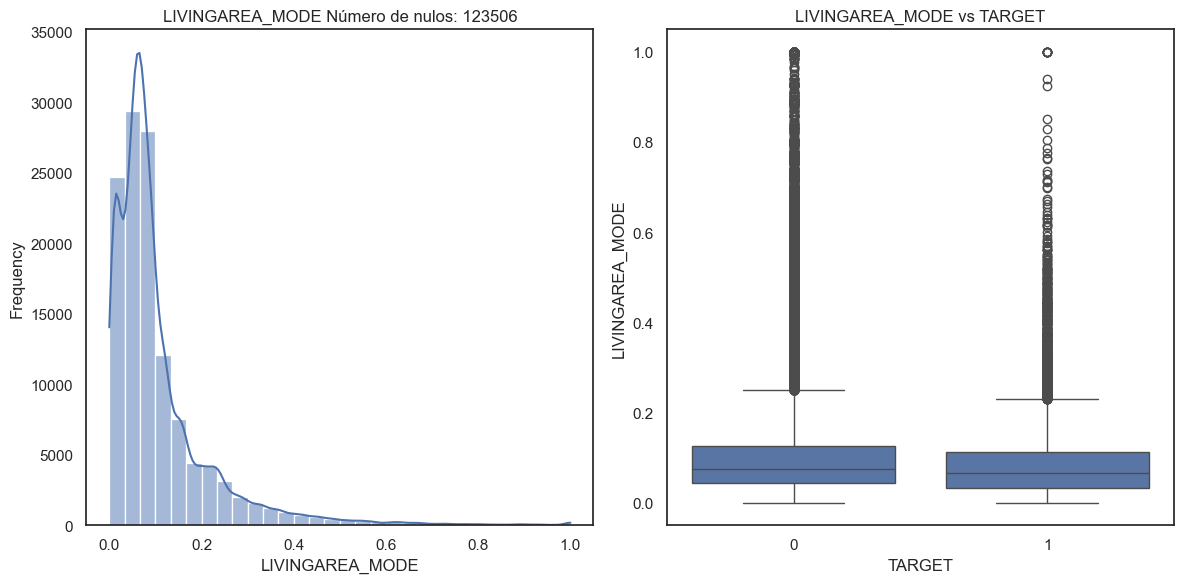

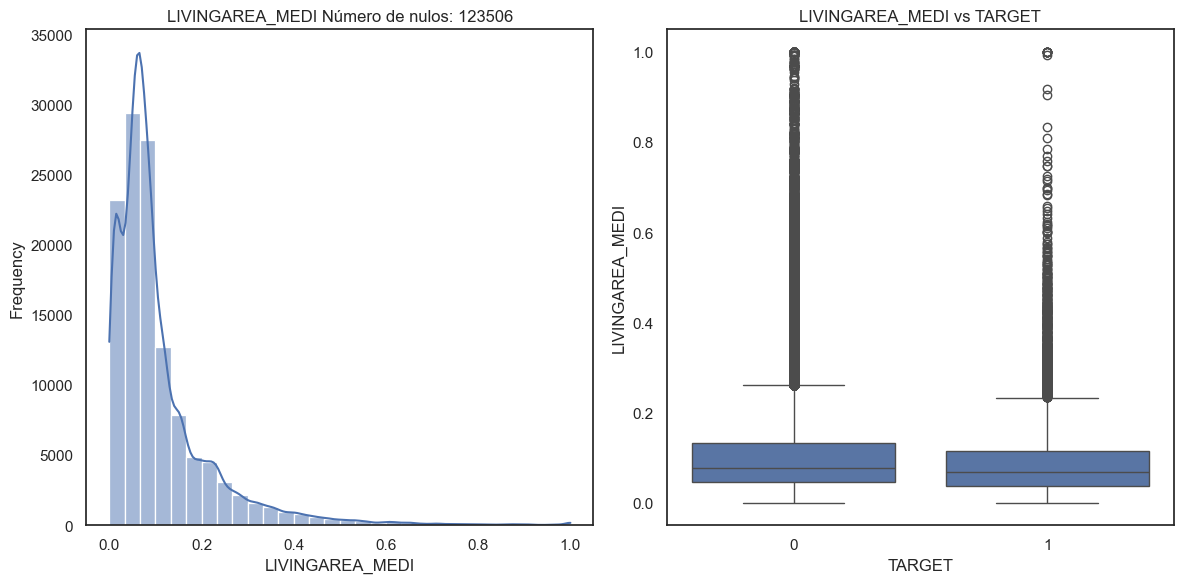

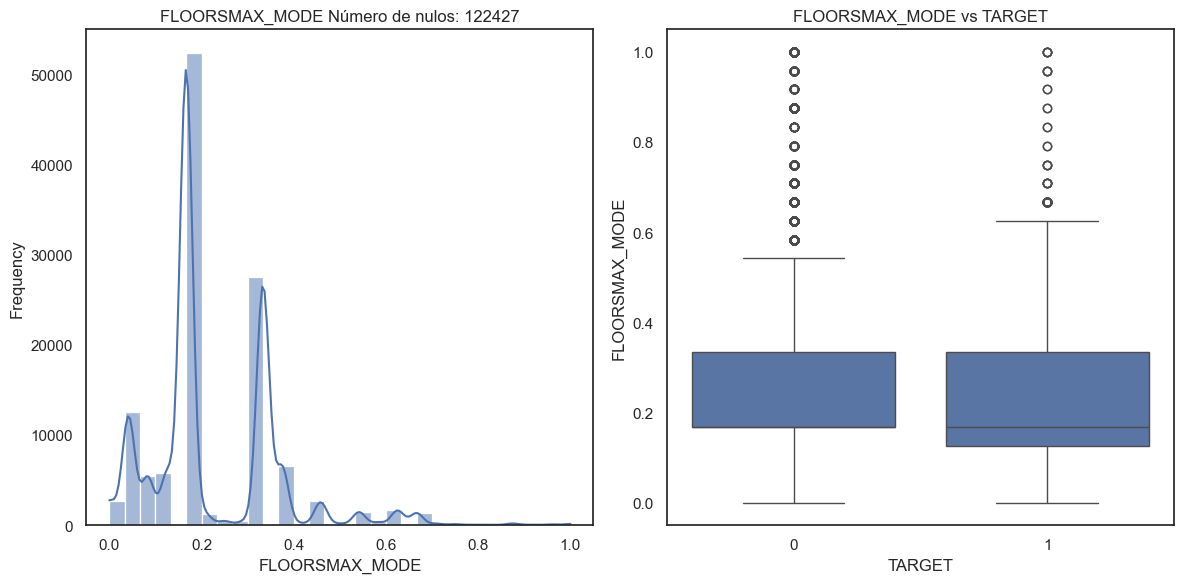

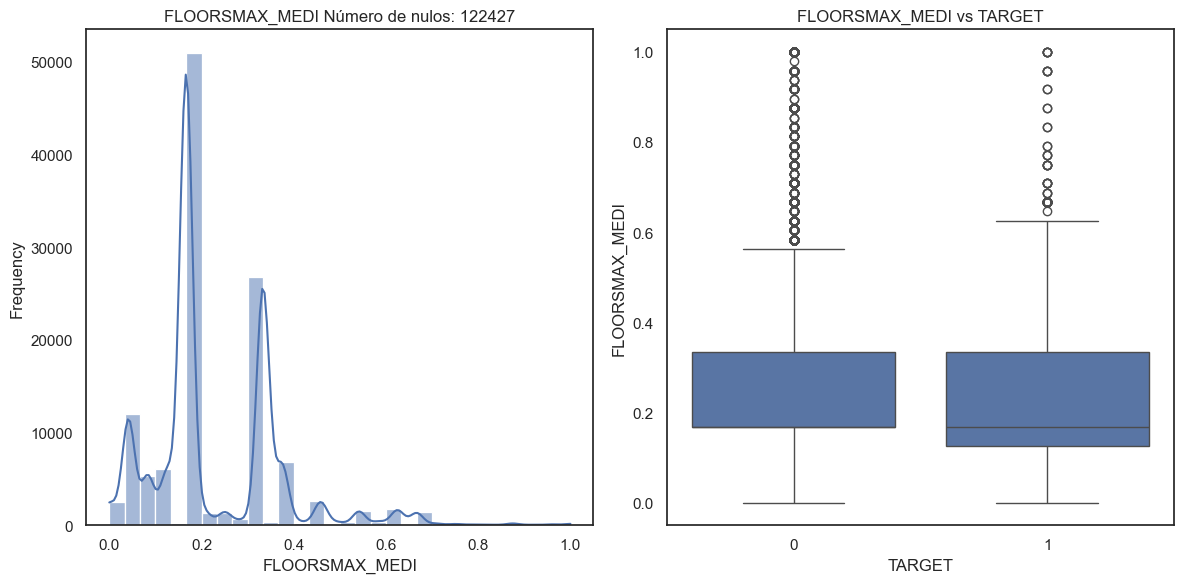

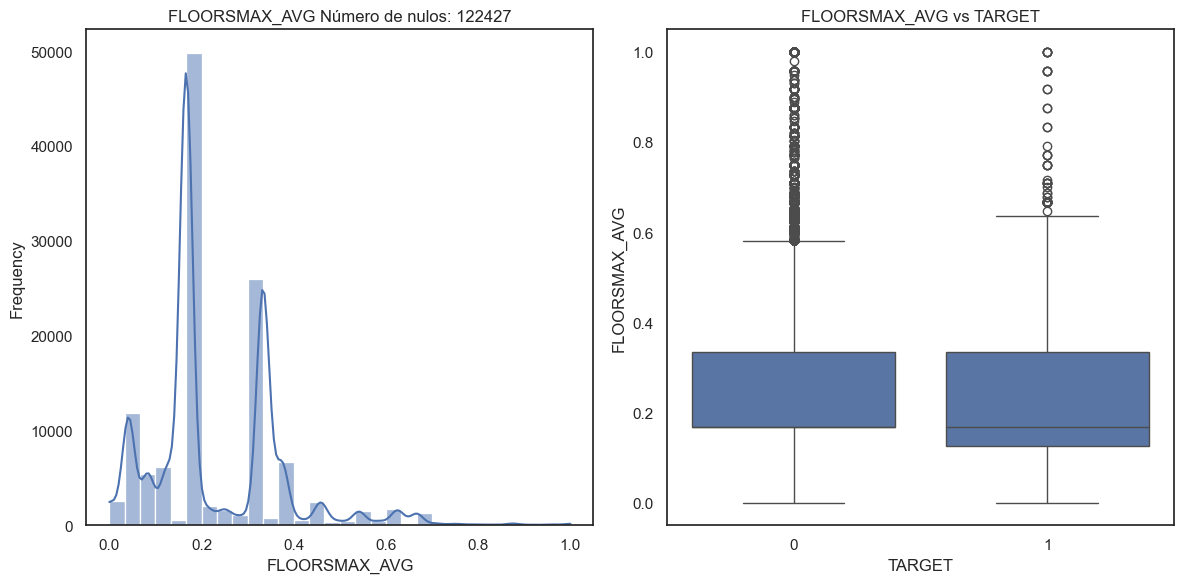

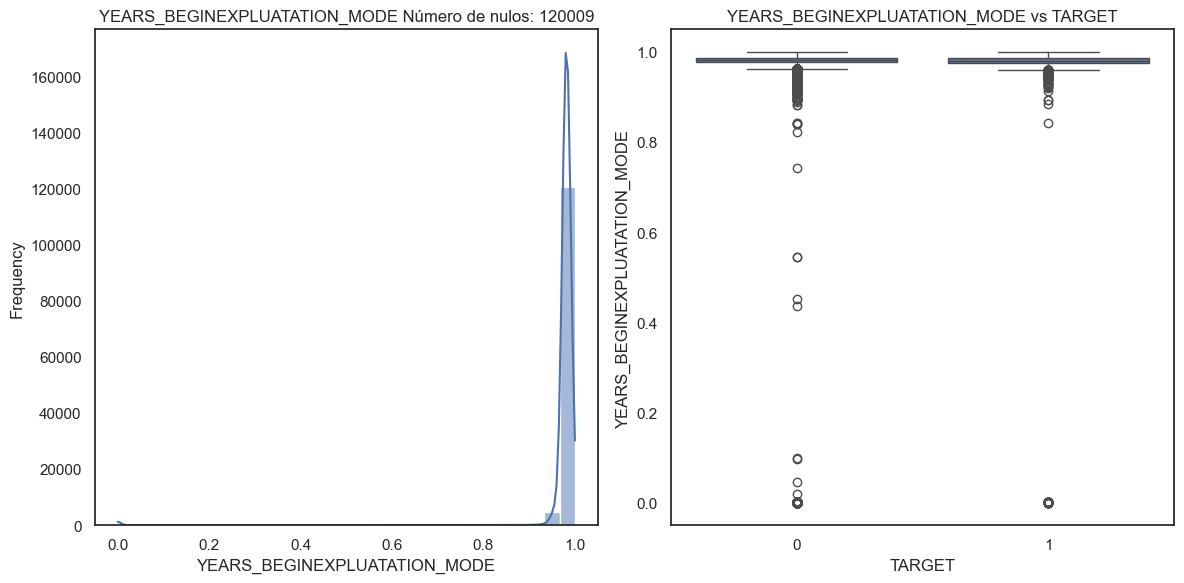

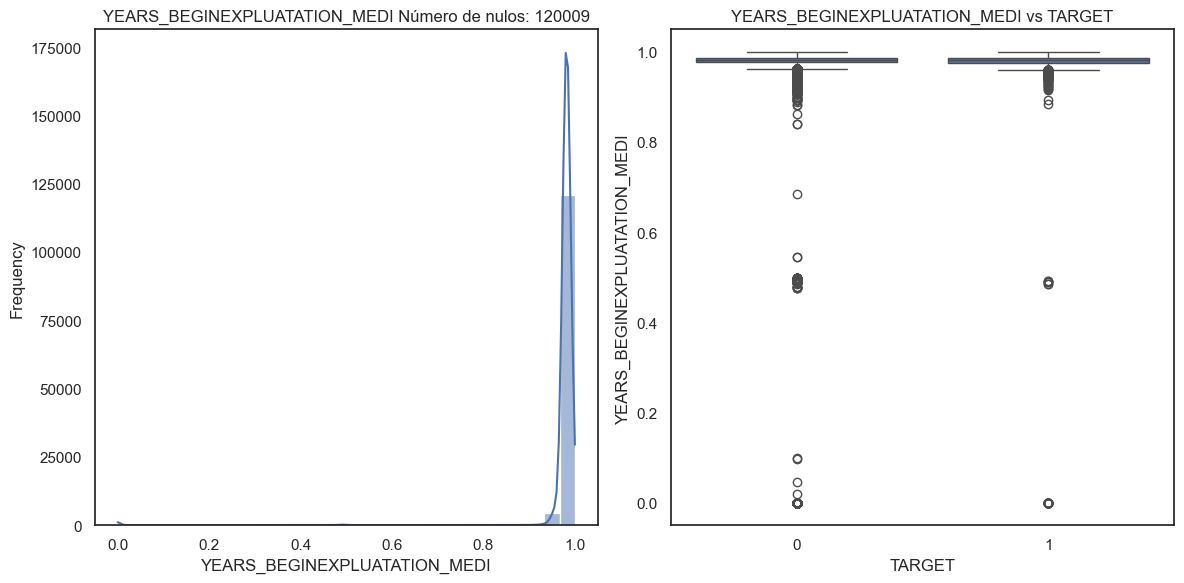

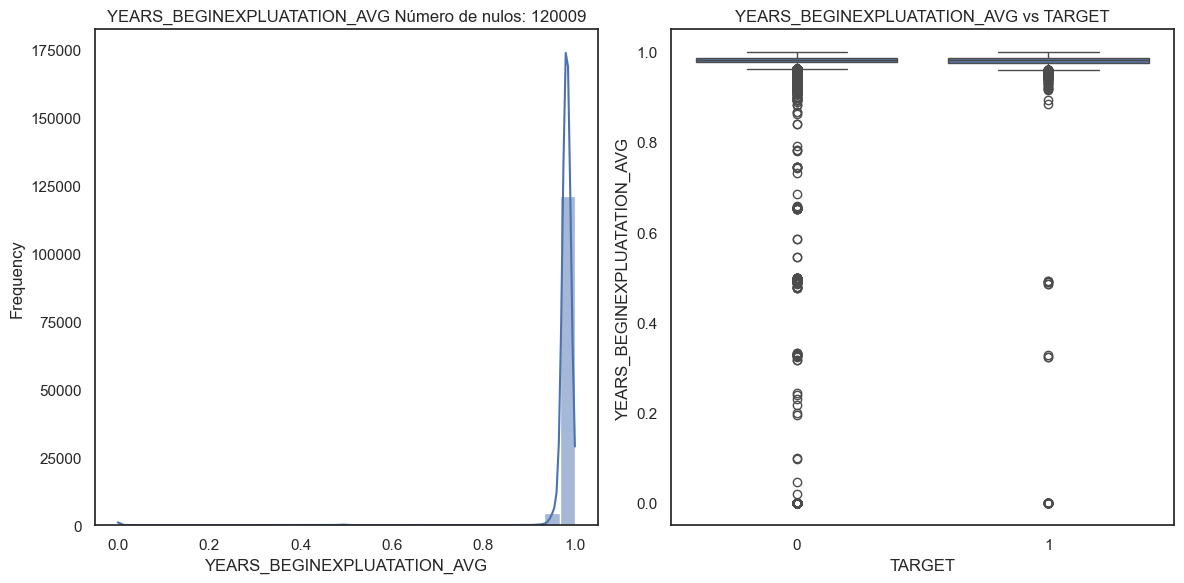

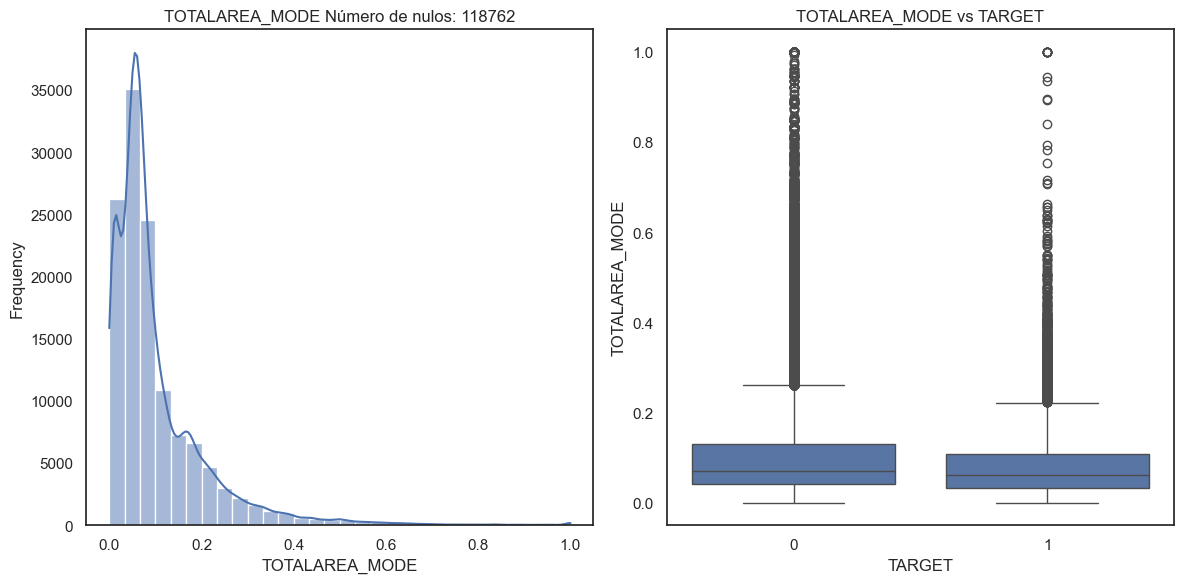

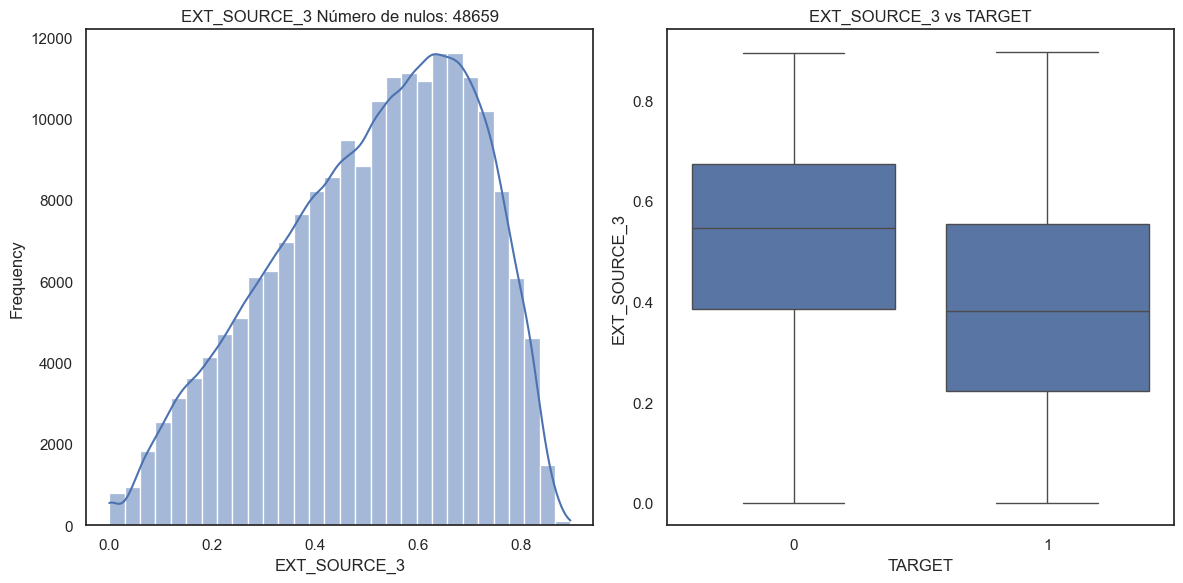

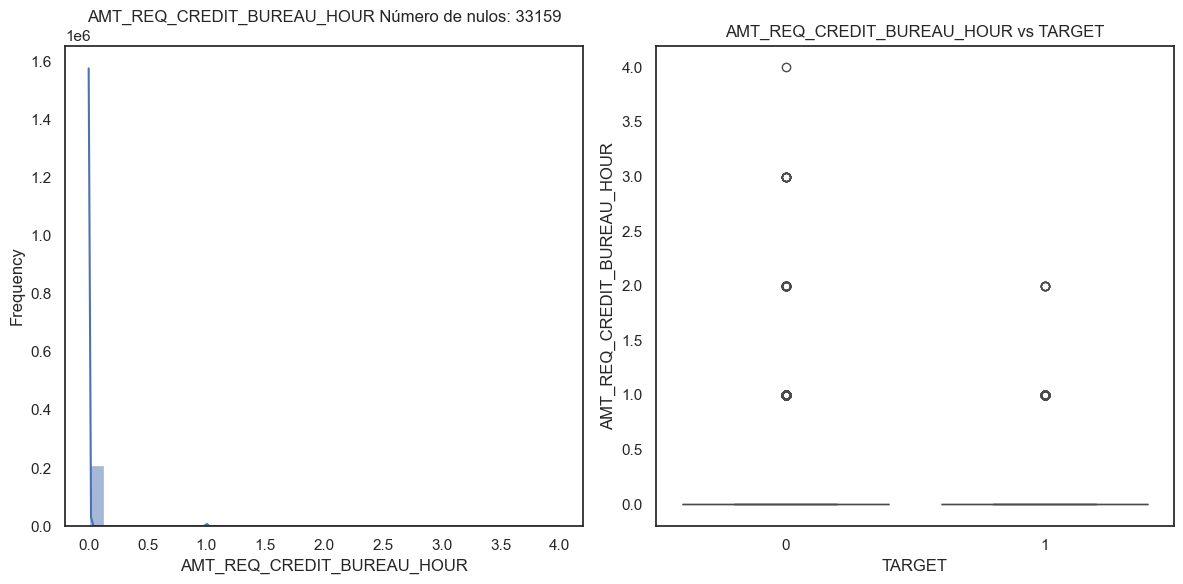

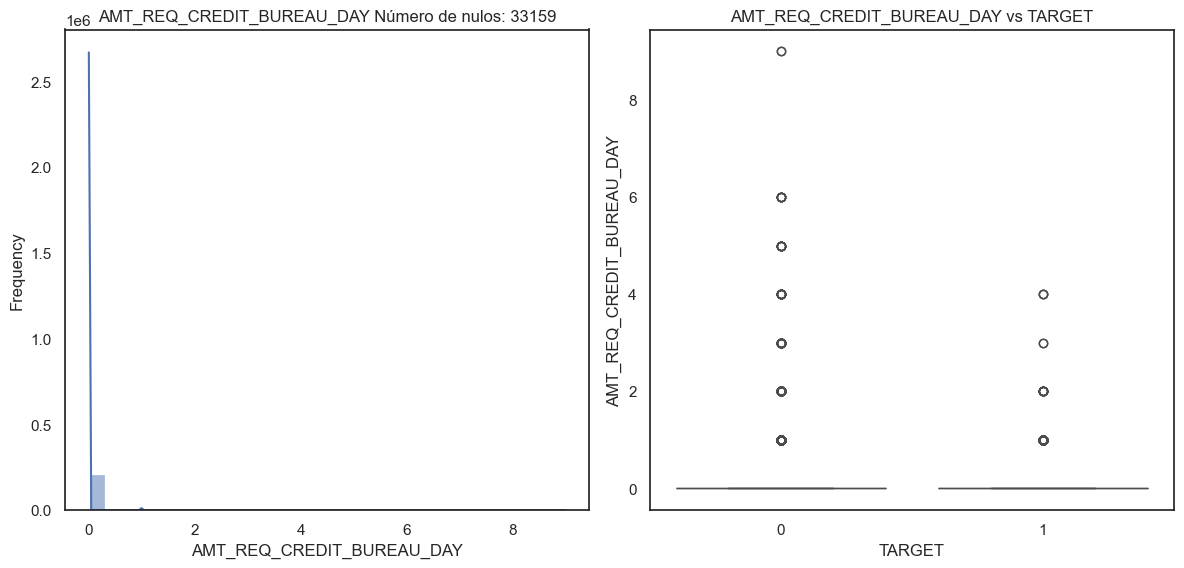

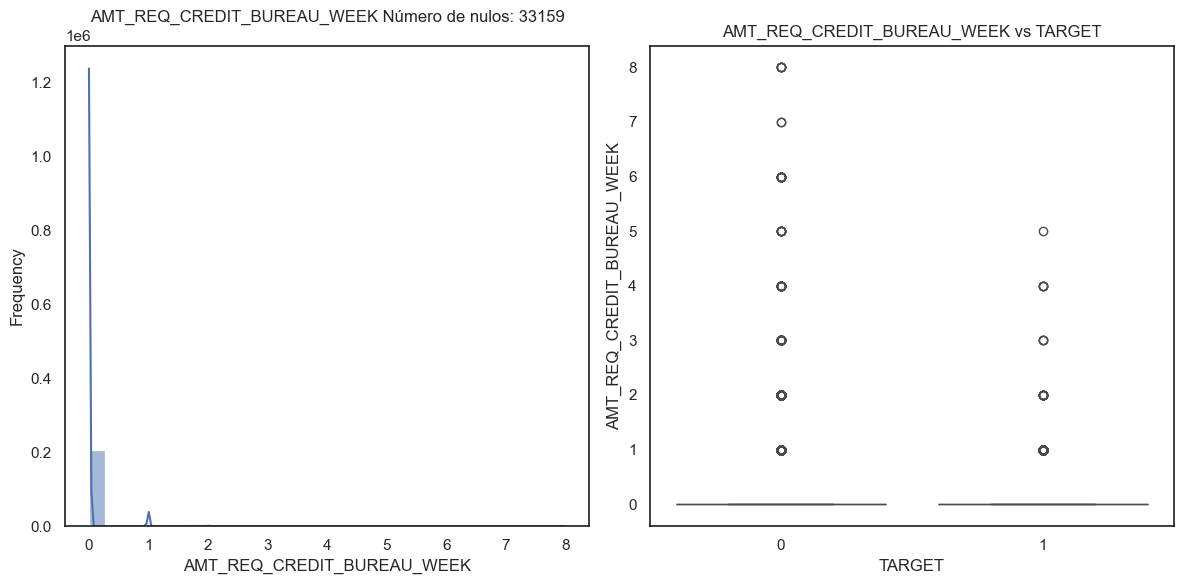

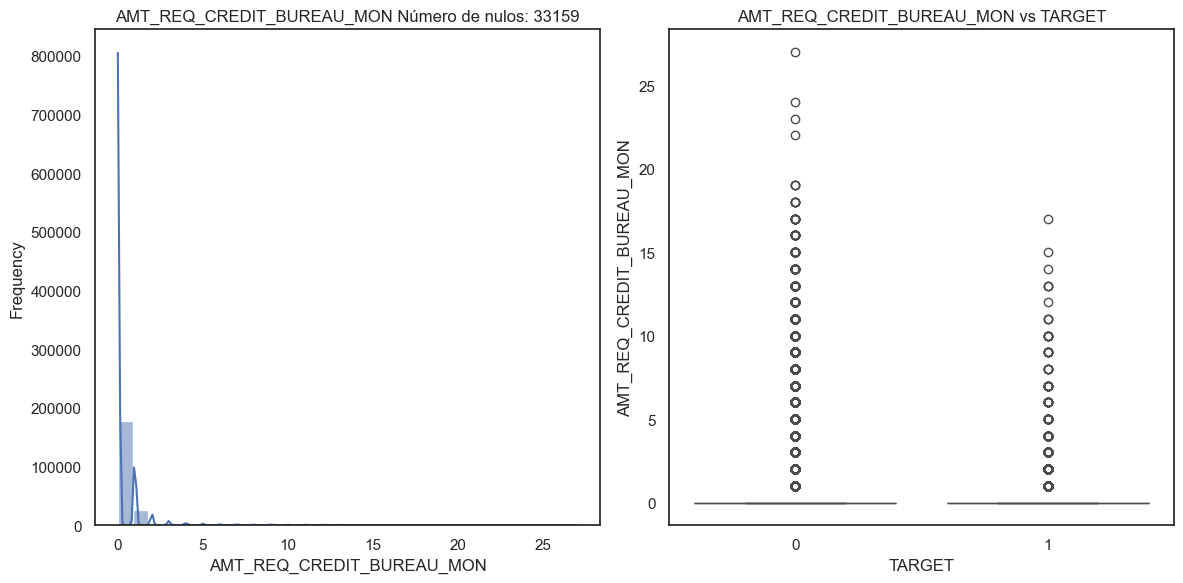

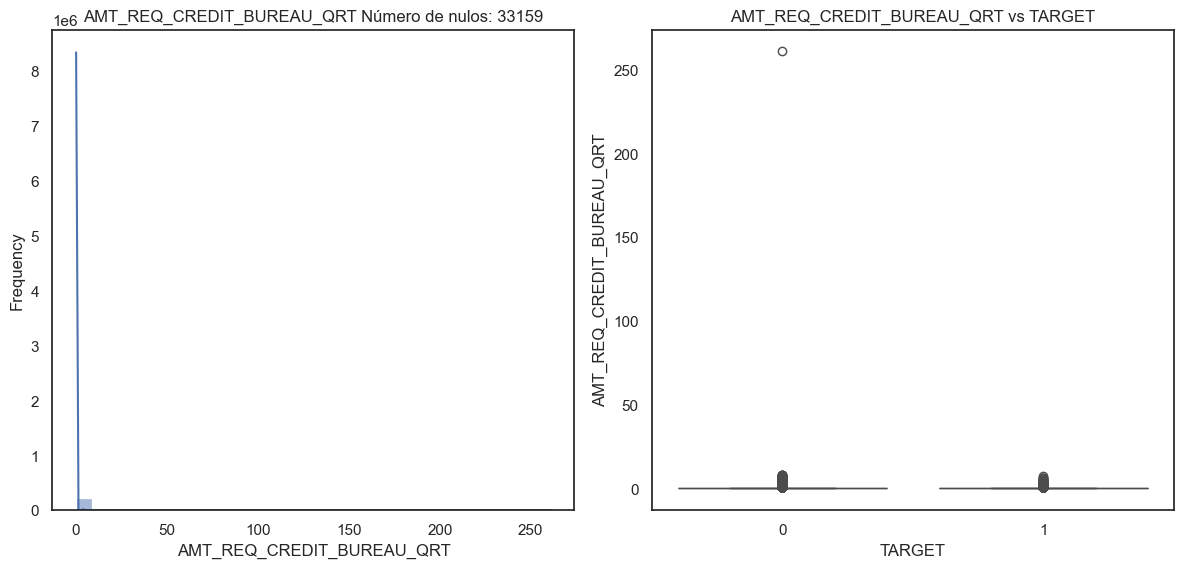

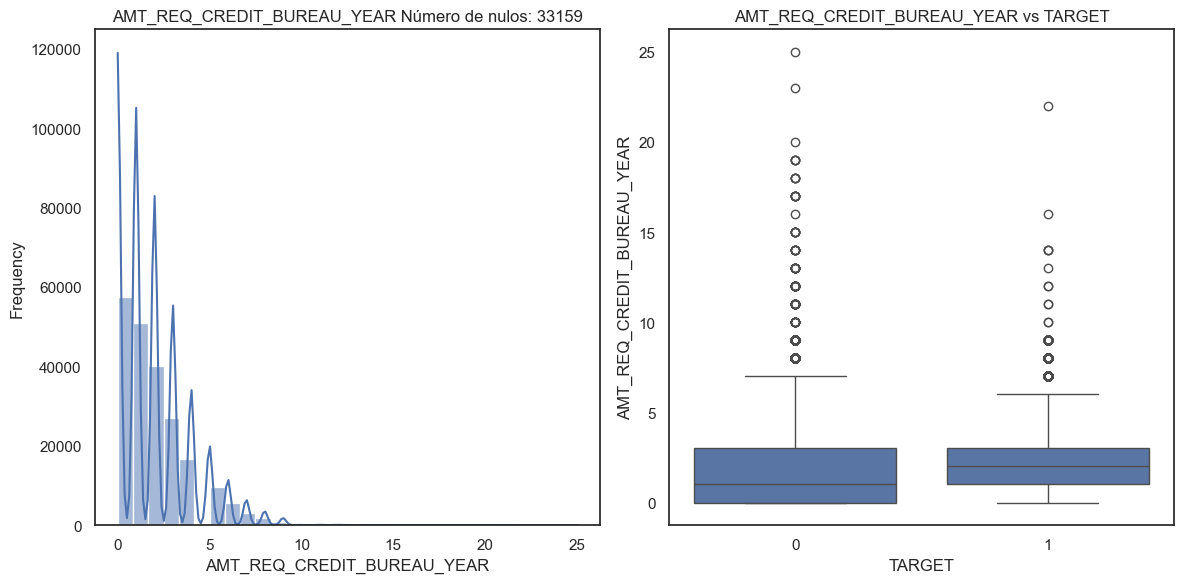

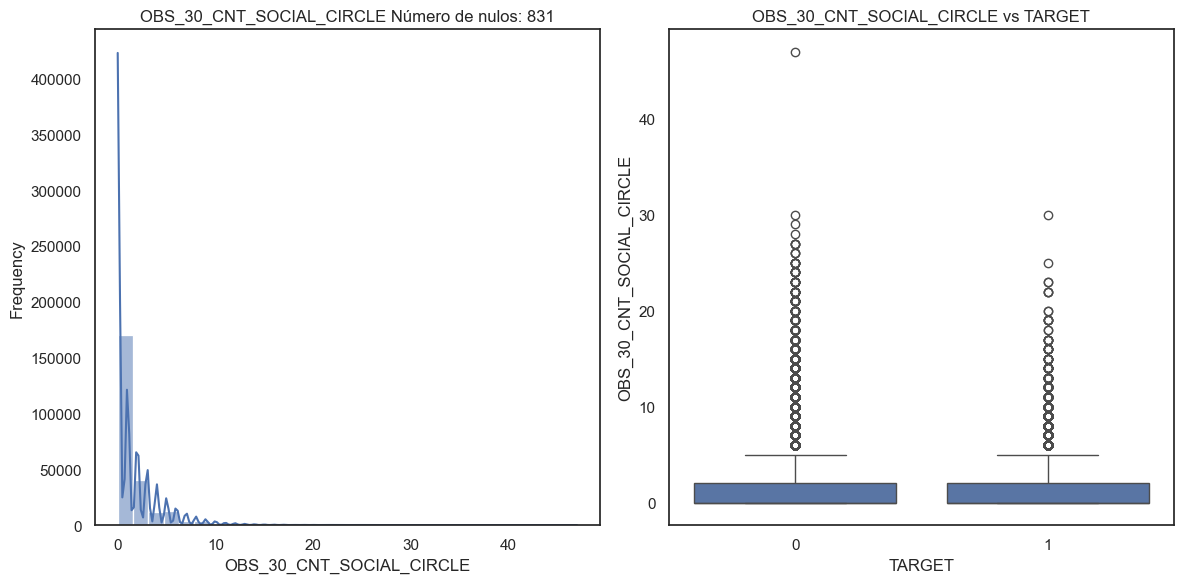

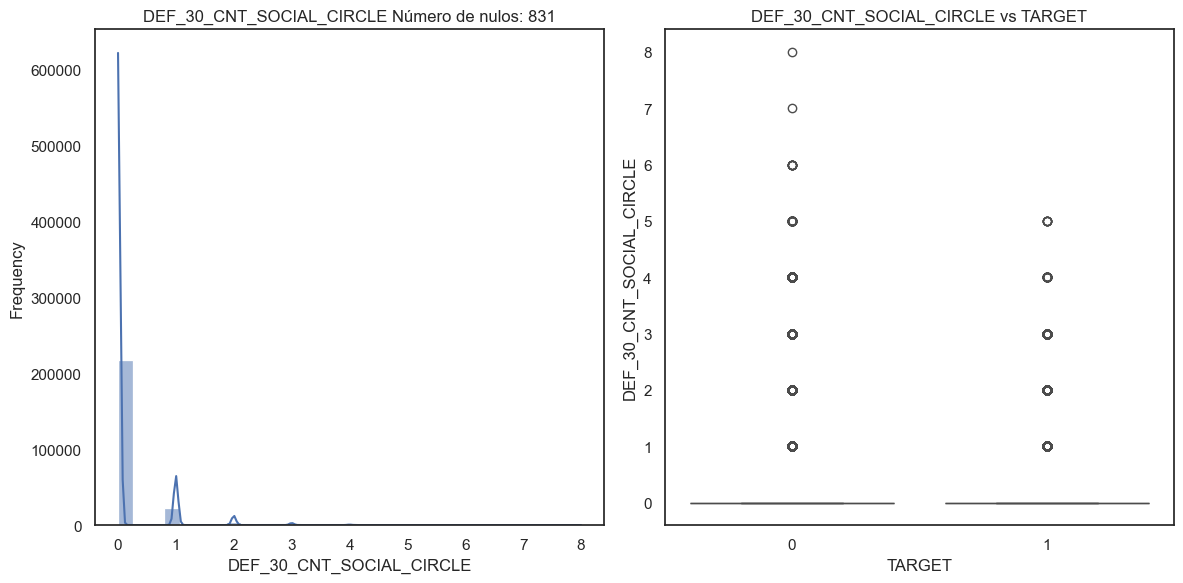

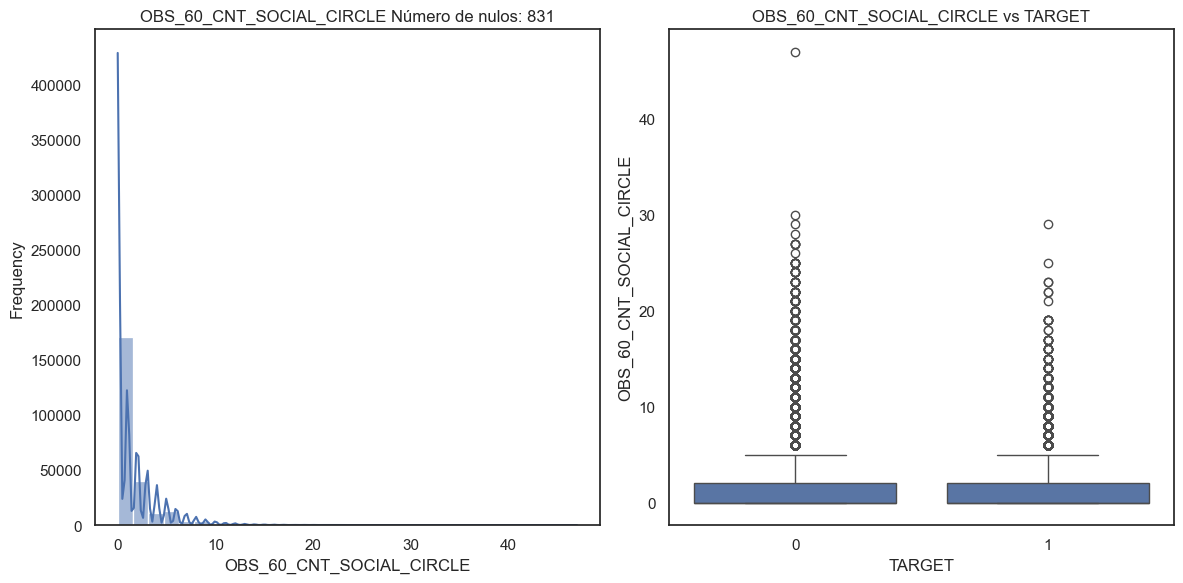

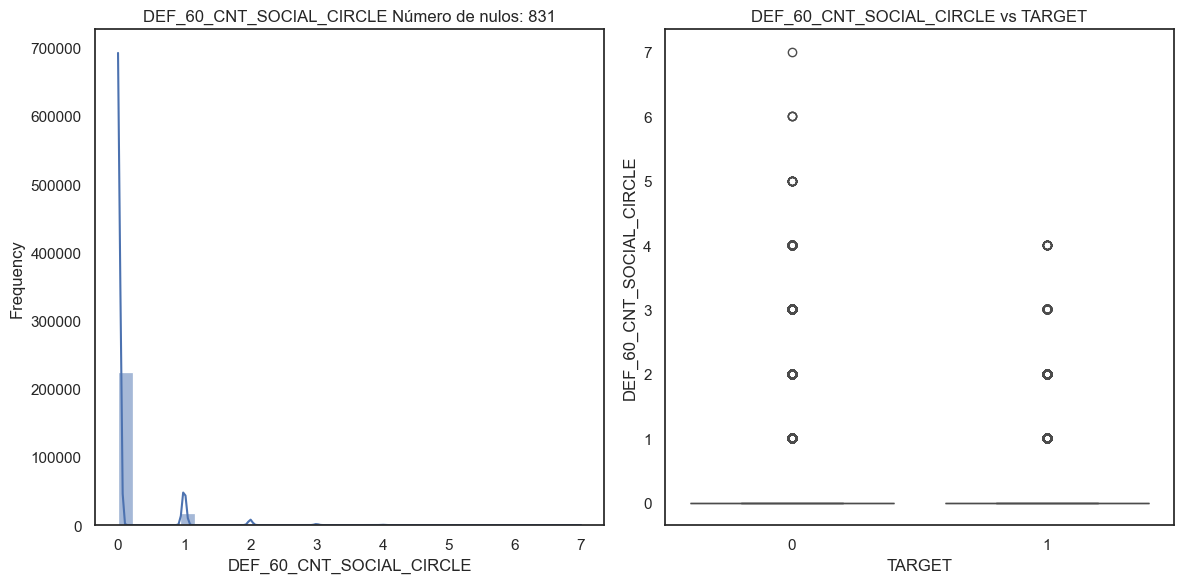

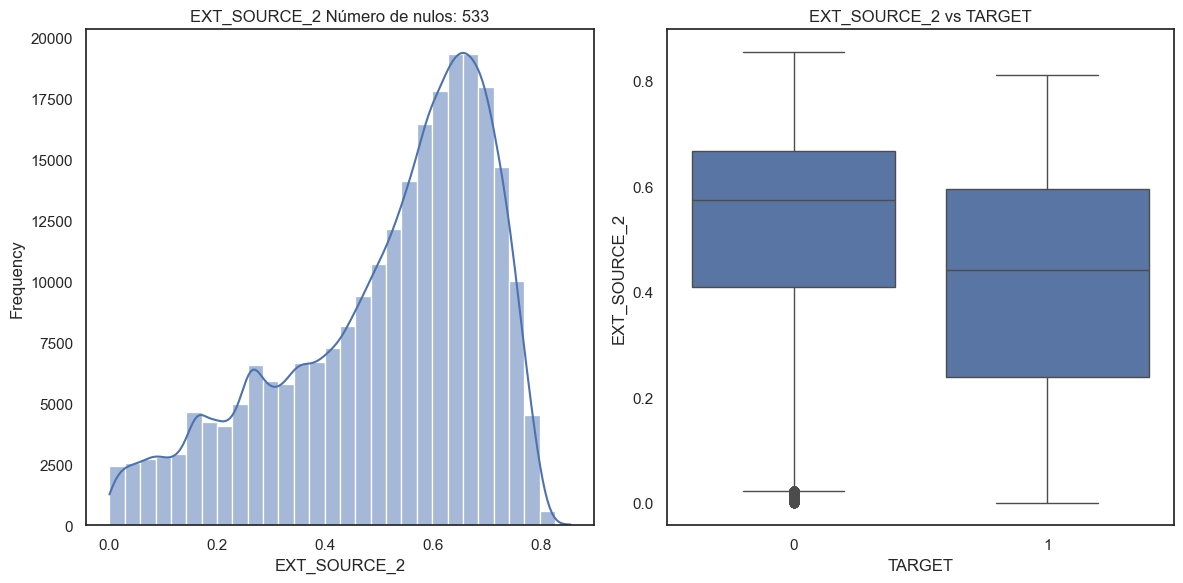

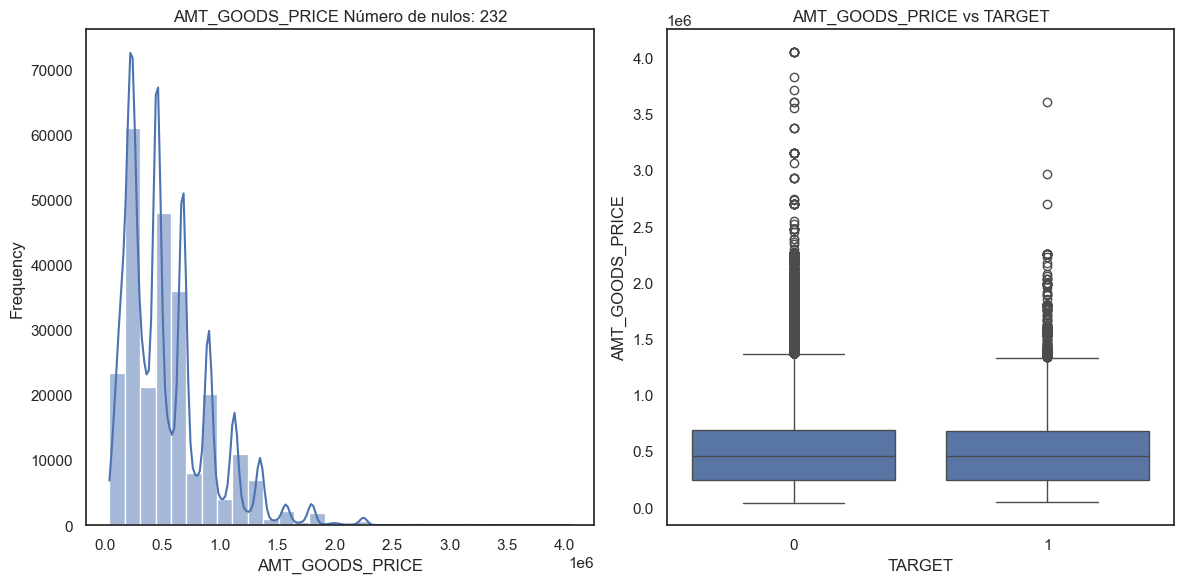

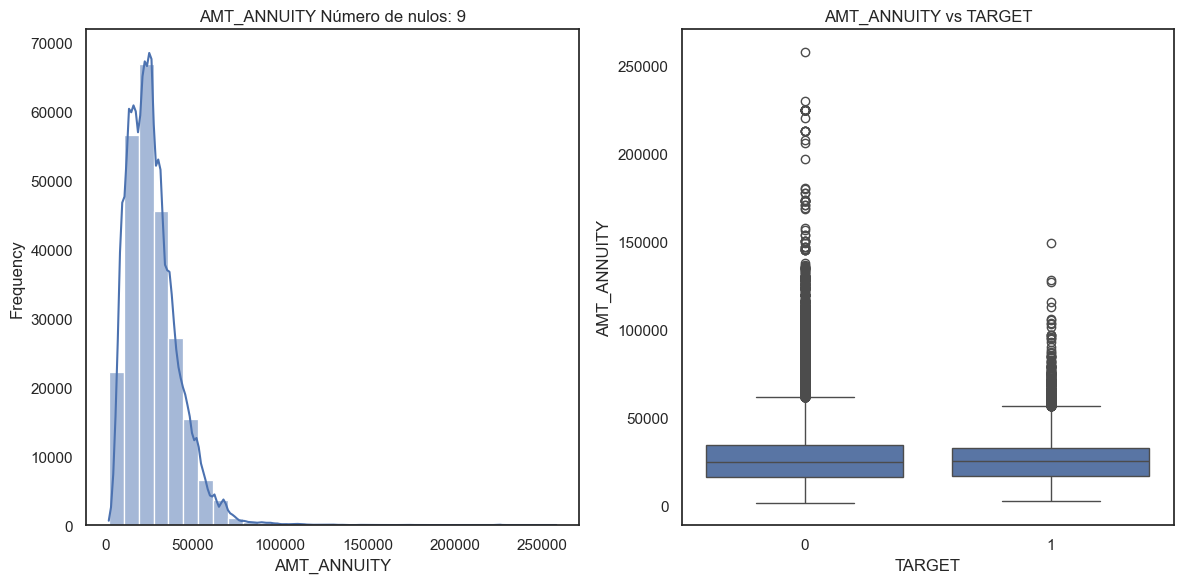

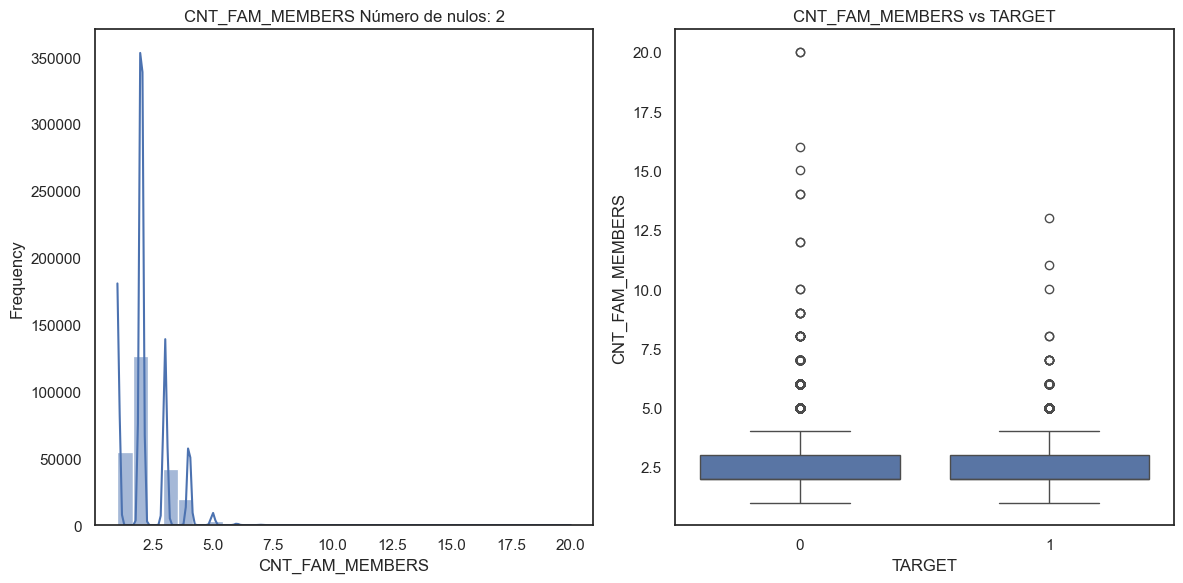

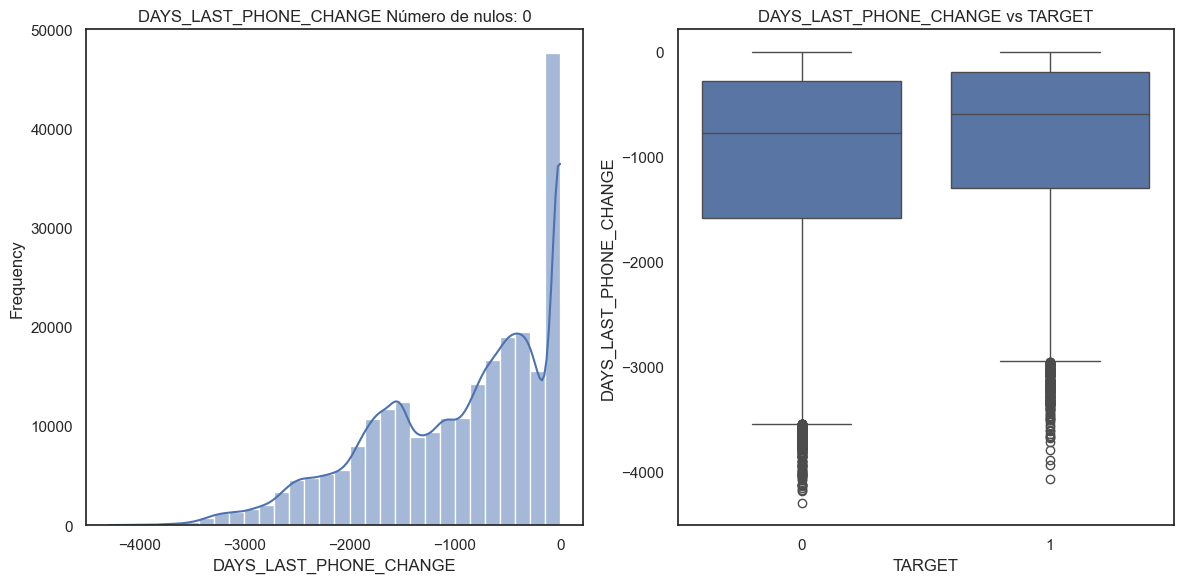

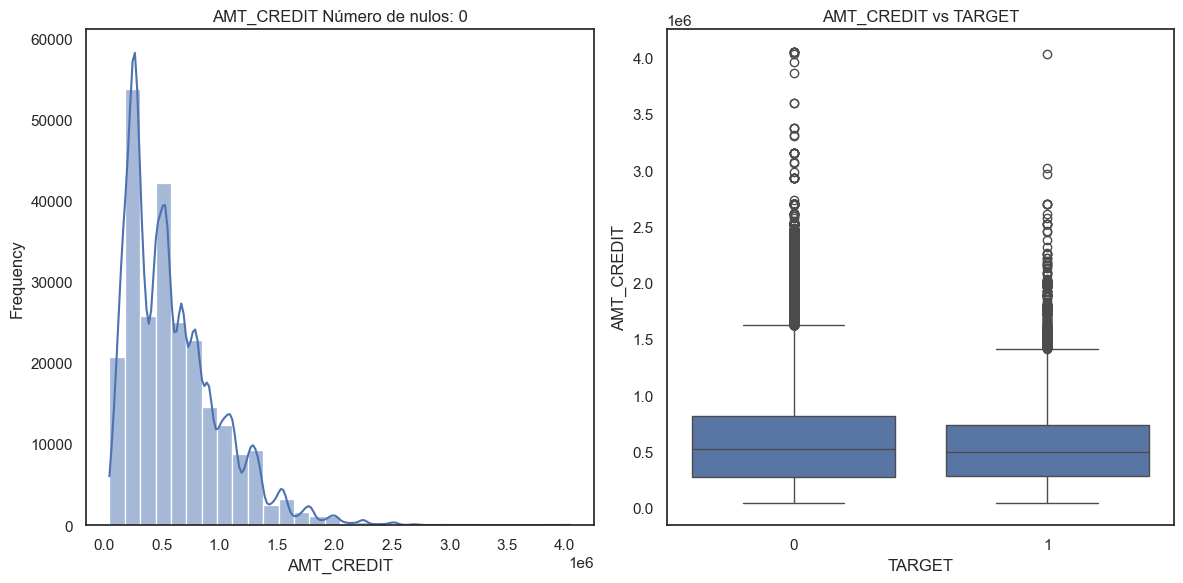

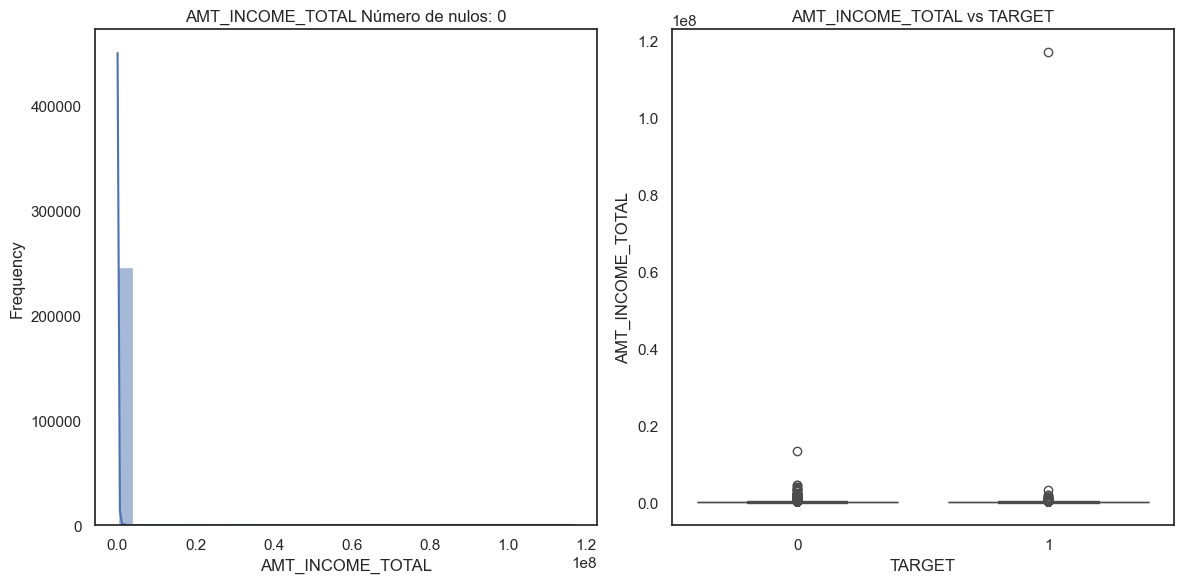

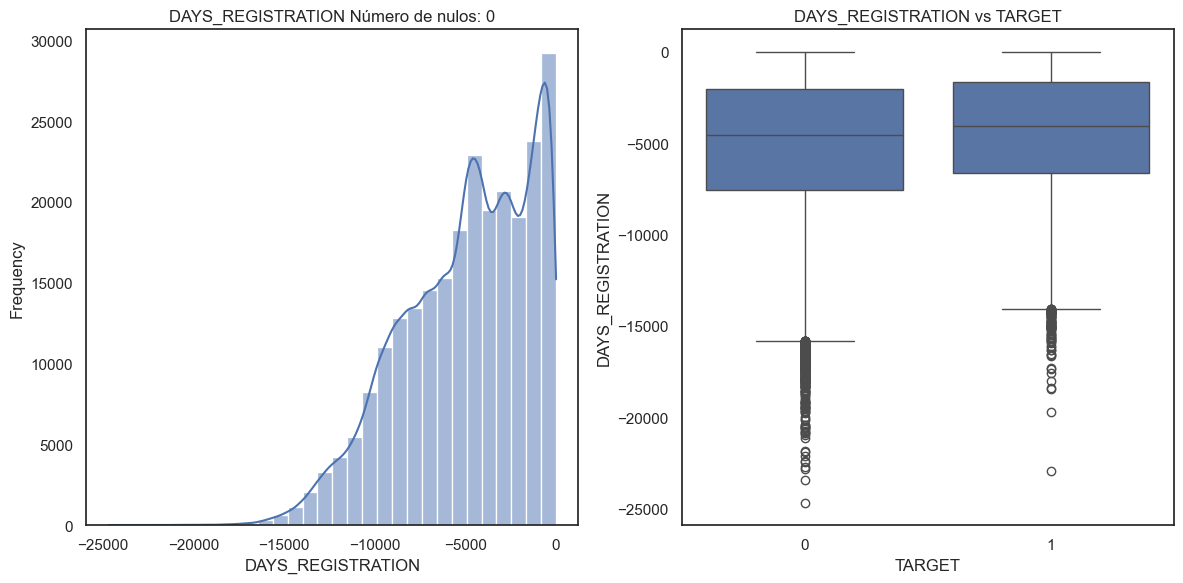

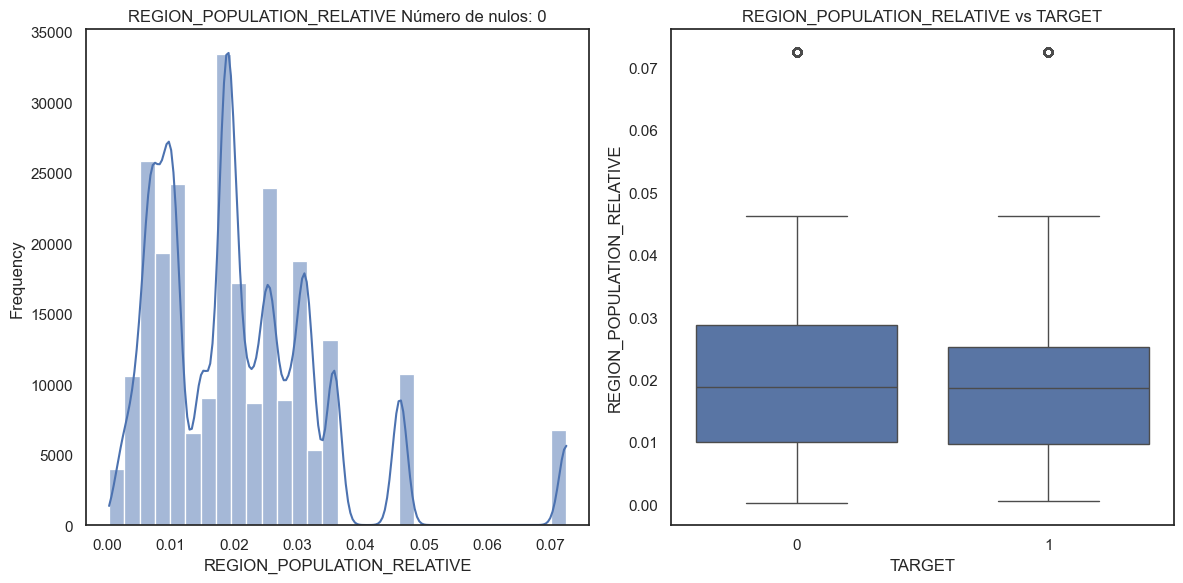

In [61]:
for variable in list_var_continuous:  # Lista de variables continuas
    if variable != "TARGET":
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Histograma
        sns.histplot(data=pd_loan_train, x=variable, kde=True, ax=axes[0], bins=30)
        axes[0].set_title(f'{variable} Número de nulos: {pd_loan_train[variable].isna().sum()}')
        axes[0].set_ylabel('Frequency')

        # Boxplot vs TARGET
        sns.boxplot(data=pd_loan_train, x='TARGET', y=variable, ax=axes[1])
        axes[1].set_title(f'{variable} vs TARGET')
        axes[1].set_ylabel(variable)
        axes[1].set_xlabel('TARGET')

        # Ajustar diseño
        plt.tight_layout()
        plt.show()

Una vez realizados los gráficos de las variables continuas con la variable objetivo (TARGET), procederemos a realizar algunos comentarios de algunas variables que puedan influir
en la misma, así como algunas que no sean tan significativas para tener un ejemplo de todo. A continuación, veremos cuáles son las variables elegidas.

OWN_CAR_AGE (Edad del coche propio).
Como vemos en el gráfico de la izquierda, hay un número considerable de valores nulos, concretamente 162.426, lo que indica que muchas personas no poseen automóvil o no hay información a cerca de ellos. Esto se debería gestionar mediante, por ejemplo, con la imputación o creando una categoría específica para los que no tienen automóvil. La mayoría de los coches tienen entre 0 y 20 años, con una concentración importante sobre todo de 0 a 10. No hay casi valores más allá de los 40 años, solo unos pocos datos sobrepasan los 60 años. En cuanto a su relación con TARGET, vemos en los boxplots que no hay grandes diferencias en la mediana ni en el rango intercuartílico para 0 y para 1, lo que nos puede indicar que no el coche propio puede no ser un factor influyente en cuanto a devolver o no el crédito.

EXT_SOURCE_1 (Puntuaciones de riesgo crediticio para los solicitantes que provienen de fuentes externas).
En el gráfico de la izquierda se puede observar que la variable sigue una distribución simétrica con forma similar a una distribución normal. Esta variable tiene una elevada cantidad de valores lo que indica que puede ser útil para discriminar entre distintos tipos de solicitantes. En cuanto a su relación con TARGET, observamos que el boxplot muestra que la mediana para los clientes que no incumplen (TARGET=0) es algo mayor que la de los que sí incumplen (TARGET=1) tienden a tener valores más altos, lo que puede decir que esta variable está asociada con un menor riesgo de incumplimiento.El rango intercuartílico es algo mayor también en los clientes cumplidores que en los que no. Podemos decir que esta variable puede tener un cierto poder predictivo.Los valores altos de EXT_SOURCE_1 se asocian con un menor riesgo de incumplimiento.


CNT_FAM_MEMBERS (Numero de miembros de la familia).
En el gráfico de la izquierda vemos que la variable posee 2 valores nulos, algo que no es significativo dentro del total de datos. En el histograma se muestra que la mayoría de los datos se encuentran entre 2 y 4 miembros, concentrándose sobre todo en 2, sugiriendo que una gran parte de las familias son pequeñas. En relación con TARGET, el boxplot muestra que la distribución es similiar tanto para los cumplidores como para los que no. Tanto la mediana como el rango intercuartílico son iguales, lo que indica que no hay una gran relación con la probabilidad de impago. Hay algunas familias con un número elevado de miembros, aunque no parece que tengan un efecto significativo.


AMT_INCOME_TOTAL (Ingresos totales).
Esta variable no posee valores nulos, por lo que podría ser representativa. En cuanto al histograma, la distribución de la variable está sesgada hacia la izquierda, lo que indica que la mayoría de clientes tienen ingresos bajos. La distribuación de los ingresos para TARGET=0 y TARGET=1 es muy similar, La mediana y el rango intercuartílico son también casi iguales, lo que indica que el nivel de ingresos no tiene una relación directa con la posibilidad de impago.

EXT_SOURCE_2 (Puntuaciones de riesgo crediticio para los solicitantes que provienen de fuentes externas)
En este caso, presenta pocos valores nulos con respecto al total de los datos, aunque se podrían imputar para no perder demasiada información. En el histograma vemos que la mayoría de los valores están concentrados entre 0.4 y 0.8, es decir, sesgados a la derecha, mientras que los valores extremos son menos comunes.En cuanto a su relación con TARGET, vemos que los valores más altos están relacionados con los clientes que no incumplen. La mediana es mas alta para los clientes que no incumplen, lo que un valor más alto de la variable podría estar asociado con un menor riesgo de incumplimiento. El rango intercuartílico es bastante parecido, aunque se observa que los valores bajos se concentran más en los clientes que presentan incumplimiento, por lo que podemos decir que esta variable puede ser un buen predictor.

EXT_SOURCE_3 (Puntuaciones de riesgo crediticio para los solicitantes que provienen de fuentes externas)
Al igual que en las variables anteriores como EXT_SOURCE_1 y EXT_SOURCE_2, prsenta los valores más altos asocidados a clientes que no incumplen el préstamo, lo que indica que valores bajos poseen un mayor riesgo de incumplimiento. Por lo tanto, podemos concluir que la información externa sobre clientes solicitantes de préstamo es una buena variable predictora.



In [ ]:
funciones.get_deviation_of_mean_perc(pd_loan_train, list_var_continuous, target='TARGET', multiplier=3)

0.0       1.0                    variable  sum_outlier_values  \
0   0.953812  0.046188             COMMONAREA_MEDI                1364   
1   0.954647  0.045353              COMMONAREA_AVG                1345   
2   0.950370  0.049630             COMMONAREA_MODE                1350   
3   0.923792  0.076208    NONLIVINGAPARTMENTS_MODE                 538   
4   0.929310  0.070690     NONLIVINGAPARTMENTS_AVG                 580   
..       ...       ...                         ...                 ...   
57  0.958084  0.041916      DAYS_LAST_PHONE_CHANGE                 501   
58  0.961612  0.038388                  AMT_CREDIT                2605   
59  0.948113  0.051887            AMT_INCOME_TOTAL                 212   
60  0.960265  0.039735           DAYS_REGISTRATION                 604   
61  0.961283  0.038717  REGION_POPULATION_RELATIVE                6767   

    porcentaje_sum_null_values  
0                     0.005545  
1                     0.005467  
2                     0.005488  
3                     0.002187  
4                     0.002358  
..                         ...  
57                    0.002037  
58                    0.010589  
59                    0.000862  
60                    0.002455  
61                    0.027507  

[62 rows x 5 columns]

CORRELACIONES

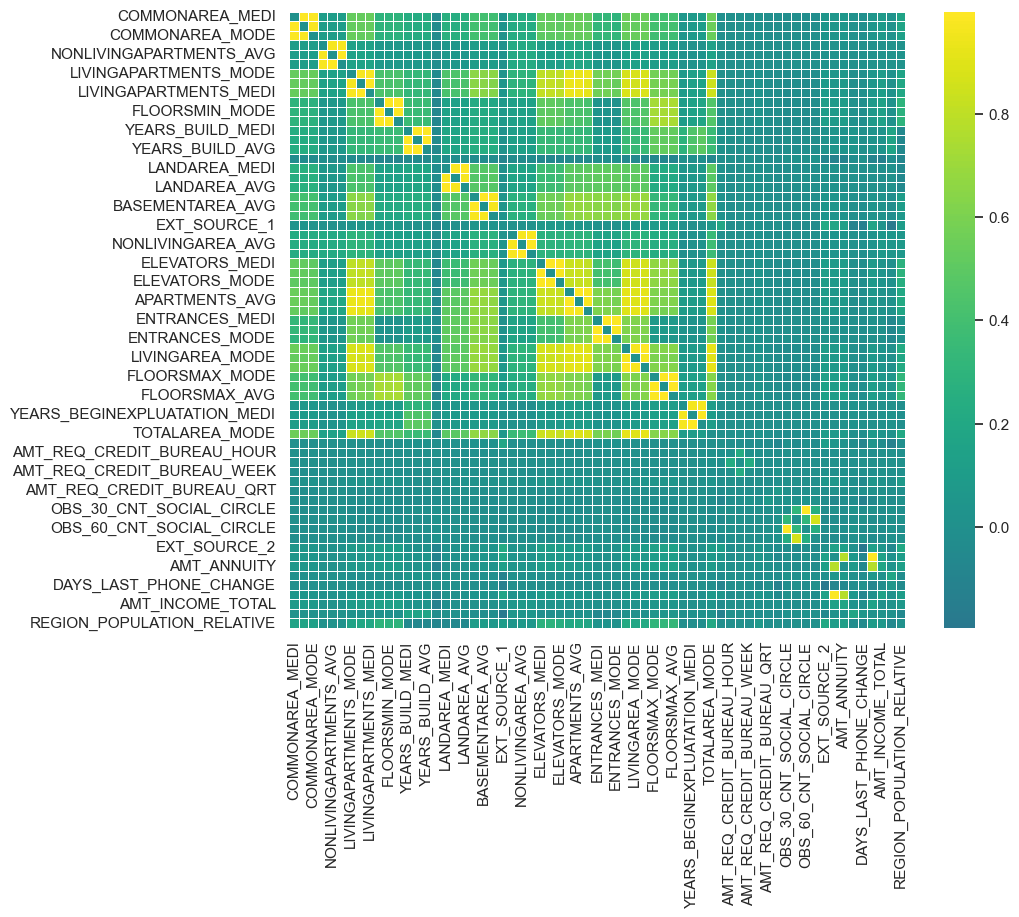

0

In [ ]:
funciones.get_corr_matrix(dataset = pd_loan_train[list_var_continuous], 
                metodo='pearson', size_figure=[10,8])

Según la matriz de correlación obtenida, podemos observar variables con una alta correlación como aquellas que se tratan de áreas o tamaños de vivienda. Sin embargo, esto nos puede llevar a pensar que hay redundancia de las variables en nuestro dataset, por lo que podríamos plantear en un futuro realizar un análisis de reducción de variables como PCA para simplificar nuestro modelo, ya que la redundancia podría generar problemas de multicolinealidad. Además, vemos que la matriz es prácticamente azul, lo que significa que la correlación entre las variables es cercana a 0, lo que indica alta independencia de las variables. 

In [64]:
corr = pd_loan_train[list_var_continuous].corr('pearson')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) # below main lower triangle of an array
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.6]

level_0                   level_1  correlation
922            YEARS_BUILD_AVG          YEARS_BUILD_MEDI     0.998447
3562  OBS_60_CNT_SOCIAL_CIRCLE  OBS_30_CNT_SOCIAL_CIRCLE     0.998368
724             FLOORSMIN_MEDI             FLOORSMIN_AVG     0.997226
2639             FLOORSMAX_AVG            FLOORSMAX_MEDI     0.996940
2177             ENTRANCES_AVG            ENTRANCES_MEDI     0.996882
...                        ...                       ...          ...
2564            FLOORSMAX_MEDI           APARTMENTS_MEDI     0.612727
2175             ENTRANCES_AVG            APARTMENTS_AVG     0.612504
2499            FLOORSMAX_MODE           APARTMENTS_MEDI     0.611150
2110            ENTRANCES_MEDI            APARTMENTS_AVG     0.608939
2506            FLOORSMAX_MODE           LIVINGAREA_MODE     0.604359

[200 rows x 3 columns]

In [65]:
corr = pd_loan_train[list_var_continuous].corr('spearman')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) 
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.6]

level_0                       level_1  correlation
922               YEARS_BUILD_AVG              YEARS_BUILD_MEDI     0.998367
2837  YEARS_BEGINEXPLUATATION_AVG  YEARS_BEGINEXPLUATATION_MEDI     0.997444
3562     OBS_60_CNT_SOCIAL_CIRCLE      OBS_30_CNT_SOCIAL_CIRCLE     0.997300
1186                 LANDAREA_AVG                 LANDAREA_MEDI     0.996328
527         LIVINGAPARTMENTS_MEDI          LIVINGAPARTMENTS_AVG     0.996237
...                           ...                           ...          ...
2437              LIVINGAREA_MEDI                ENTRANCES_MEDI     0.605250
2373              LIVINGAREA_MODE                 ENTRANCES_AVG     0.602201
2372              LIVINGAREA_MODE                ENTRANCES_MEDI     0.601345
2862               TOTALAREA_MODE               COMMONAREA_MODE     0.600812
2307               LIVINGAREA_AVG                ENTRANCES_MEDI     0.600325

[227 rows x 3 columns]

También hemos hecho la matriz de spearman. Ambas matrices proporcionan resultados muy parecidos, por lo que llegamos a la conclusión de que es necesario realizar una simplificación de las variables para evitar problemas en el modelado, ya que muchas de nuestras variables no nos están aportando un valor añadido y nos hace el trabajo más complejo.

TRATAMIENTO DE VALORES NULOS

En este caso, volvemos a hacer uso de una función establecida al principio del notebook para encontrar la suma y porcentaje de valores nulos por cada columna.

In [ ]:
funciones.get_percent_null_values_target(pd_loan_train, list_var_continuous, target='TARGET')

0.0       1.0                      variable  sum_null_values  \
0   0.914116  0.085884               COMMONAREA_MEDI           171941   
1   0.914116  0.085884                COMMONAREA_AVG           171941   
2   0.914116  0.085884               COMMONAREA_MODE           171941   
3   0.914000  0.086000      NONLIVINGAPARTMENTS_MODE           170849   
4   0.914000  0.086000       NONLIVINGAPARTMENTS_AVG           170849   
5   0.914000  0.086000      NONLIVINGAPARTMENTS_MEDI           170849   
6   0.913616  0.086384         LIVINGAPARTMENTS_MODE           168179   
7   0.913616  0.086384          LIVINGAPARTMENTS_AVG           168179   
8   0.913616  0.086384         LIVINGAPARTMENTS_MEDI           168179   
9   0.913509  0.086491                 FLOORSMIN_AVG           166930   
10  0.913509  0.086491                FLOORSMIN_MODE           166930   
11  0.913509  0.086491                FLOORSMIN_MEDI           166930   
12  0.913131  0.086869              YEARS_BUILD_MEDI           163648   
13  0.913131  0.086869              YEARS_BUILD_MODE           163648   
14  0.913131  0.086869               YEARS_BUILD_AVG           163648   
15  0.914887  0.085113                   OWN_CAR_AGE           162548   
16  0.911809  0.088191                 LANDAREA_MEDI           146114   
17  0.911809  0.088191                 LANDAREA_MODE           146114   
18  0.911809  0.088191                  LANDAREA_AVG           146114   
19  0.910969  0.089031             BASEMENTAREA_MEDI           143995   
20  0.910969  0.089031              BASEMENTAREA_AVG           143995   
21  0.910969  0.089031             BASEMENTAREA_MODE           143995   
22  0.915013  0.084987                  EXT_SOURCE_1           138633   
23  0.909629  0.090371            NONLIVINGAREA_MODE           135885   
24  0.909629  0.090371             NONLIVINGAREA_AVG           135885   
25  0.909629  0.090371            NONLIVINGAREA_MEDI           135885   
26  0.909011  0.090989                ELEVATORS_MEDI           131170   
27  0.909011  0.090989                 ELEVATORS_AVG           131170   
28  0.909011  0.090989                ELEVATORS_MODE           131170   
29  0.908666  0.091334               APARTMENTS_MEDI           124828   
30  0.908666  0.091334                APARTMENTS_AVG           124828   
31  0.908666  0.091334               APARTMENTS_MODE           124828   
32  0.908416  0.091584                ENTRANCES_MEDI           123853   
33  0.908416  0.091584                 ENTRANCES_AVG           123853   
34  0.908416  0.091584                ENTRANCES_MODE           123853   
35  0.908790  0.091210                LIVINGAREA_AVG           123506   
36  0.908790  0.091210               LIVINGAREA_MODE           123506   
37  0.908790  0.091210               LIVINGAREA_MEDI           123506   
38  0.908272  0.091728                FLOORSMAX_MODE           122427   
39  0.908272  0.091728                FLOORSMAX_MEDI           122427   
40  0.908272  0.091728                 FLOORSMAX_AVG           122427   
41  0.908182  0.091818  YEARS_BEGINEXPLUATATION_MODE           120009   
42  0.908182  0.091818  YEARS_BEGINEXPLUATATION_MEDI           120009   
43  0.908182  0.091818   YEARS_BEGINEXPLUATATION_AVG           120009   
44  0.907942  0.092058                TOTALAREA_MODE           118762   
45  0.907848  0.092152                  EXT_SOURCE_3            48659   
46  0.897916  0.102084    AMT_REQ_CREDIT_BUREAU_HOUR            33159   
47  0.897916  0.102084     AMT_REQ_CREDIT_BUREAU_DAY            33159   
48  0.897916  0.102084    AMT_REQ_CREDIT_BUREAU_WEEK            33159   
49  0.897916  0.102084     AMT_REQ_CREDIT_BUREAU_MON            33159   
50  0.897916  0.102084     AMT_REQ_CREDIT_BUREAU_QRT            33159   
51  0.897916  0.102084    AMT_REQ_CREDIT_BUREAU_YEAR            33159   
52  0.963899  0.036101      OBS_30_CNT_SOCIAL_CIRCLE              831   
53  0.963899  0.036101      DEF_30_CNT_SOCIAL_CIRCLE              8

Vamos a cambiar los valores nulos de las columnas continuas por la mediana de los valores no nulos de la columna, se ha elegido la mediana ya que a diferencia de la media (promedio), la mediana no se ve afectada por valores atípicos o extremos en los datos. Al tener un dataset con variables con valores muy extremos (como se puede observar en los gráficos) la mediana es una mejor medida de tendencia central porque representa el punto medio de la distribución.

In [67]:
medianas_train = pd_loan_train[list_var_continuous].median()
pd_loan_train[list_var_continuous] = pd_loan_train[list_var_continuous].fillna(medianas_train)
pd_loan_test[list_var_continuous] = pd_loan_test[list_var_continuous].fillna(medianas_train)

In [ ]:
funciones.get_percent_null_values_target(pd_loan_train, list_var_continuous, target='TARGET')

No existen variables con valores nulos


Empty DataFrame
Columns: []
Index: []

TRATAMIENTO VARIABLES CATEGÓRICAS

In [69]:
cramers_v_results = {}

for col in list_var_cat:
    # Calculamos la matriz de confusión entre las variable categórica y TARGET
    confusion_matrix = pd.crosstab(pd_loan_train["TARGET"], pd_loan_train[col])
    
    # Calculamos el Cramér's V para esta matriz
    cramers_v_value = cramers_v(confusion_matrix.values)
    
    # Guardamos el resultado en el diccionario
    cramers_v_results[col] = cramers_v_value

cramers_v_df = pd.DataFrame(list(cramers_v_results.items()), columns=['Variable', 'Cramér\'s V'])
cramers_v_df = cramers_v_df.sort_values(by='Cramér\'s V', ascending=False)

print(cramers_v_df)

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\3511808062.py:141: RuntimeWarning:

invalid value encountered in divide



                       Variable  Cramér's V
33                       TARGET    0.999973
4               OCCUPATION_TYPE    0.081028
43            ORGANIZATION_TYPE    0.073921
50             NAME_INCOME_TYPE    0.063113
39  REGION_RATING_CLIENT_W_CITY    0.060447
40         REGION_RATING_CLIENT    0.057878
49          NAME_EDUCATION_TYPE    0.057583
8                   CODE_GENDER    0.052601
32       REG_CITY_NOT_WORK_CITY    0.050022
45               FLAG_EMP_PHONE    0.046588
11              FLAG_DOCUMENT_3    0.044727
34       REG_CITY_NOT_LIVE_CITY    0.043457
48           NAME_FAMILY_STATUS    0.040578
47            NAME_HOUSING_TYPE    0.038197
31      LIVE_CITY_NOT_WORK_CITY    0.032110
7            NAME_CONTRACT_TYPE    0.030575
1            WALLSMATERIAL_MODE    0.030448
44              FLAG_WORK_PHONE    0.029439
14              FLAG_DOCUMENT_6    0.029240
30                   FLAG_PHONE    0.023576
9                  FLAG_OWN_CAR    0.022449
0            FONDKAPREMONT_MODE 

OPCIÓN 2

In [ ]:
confusion_matrix = pd.crosstab(pd_loan_train["TARGET"], pd_loan_train["TARGET"])
print(confusion_matrix)
funciones.cramers_v(confusion_matrix.values)

TARGET       0      1
TARGET               
0       226148      0
1            0  19860


np.float64(0.9999726128248573)

En esta opción, estamos imputando los valores nulos por la mediana de las variables que son contínuas.

In [ ]:
confusion_matrix = pd.crosstab(pd_loan_train["TARGET"], pd_loan_train["TARGET"])
funciones.cramers_v(confusion_matrix.values)

np.float64(0.9999726128248573)

In [ ]:
confusion_matrix = pd.crosstab(pd_loan_train["TARGET"], pd_loan_train["OWN_CAR_AGE"])
funciones.cramers_v(confusion_matrix.values)

np.float64(0.04027711777321073)

In [ ]:
pd_loan_train[list_var_cat] = pd_loan_train[list_var_cat].astype("object").fillna("SIN VALOR").astype("category")
pd_loan_test[list_var_cat] = pd_loan_test[list_var_cat].astype("object").fillna("SIN VALOR").astype("category")

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1031770619.py:1: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\Sara\AppData\Local\Temp\ipykernel_10580\1031770619.py:2: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



            Unnamed: 0  COMMONAREA_MEDI  COMMONAREA_AVG  COMMONAREA_MODE  \
SK_ID_CURR                                                                 
224853          107621           0.0151          0.0150           0.0151   
156765           49021           0.0209          0.0211           0.0191   
391482          251913           0.0209          0.0211           0.0191   
381835          243438           0.0209          0.0211           0.0191   
217049          100815           0.0341          0.0339           0.0342   
...                ...              ...             ...              ...   
267555          144501           0.0209          0.0211           0.0191   
311101          182134           0.0209          0.0211           0.0191   
438940          292574           0.0209          0.0211           0.0191   
267529          144479           0.0209          0.0211           0.0191   
402763          261556           0.0209          0.0211           0.0191   

           

En las variables categóricas, hemos decidido que cambiará los valores nulos por "SIN VALOR"

In [74]:
pd_loan_train.isna().sum().sum()

np.int64(0)

In [75]:
pd_loan_train.to_csv("../data/pd_loan_train.csv")
pd_loan_test.to_csv("../data/pd_loan_test.csv")